## Below the steps to identify the most promising stocks using the EPS X appraoch

1. have an excel file with all the tickers extracted from a filter on tradingview
2. Compute the FP (see below) for all the companies
3. Compute PFV (see below) for the all the companies
4. Create a flag column "below eps_pfv" indicating whether the price is below pfv
5. take the tickers respecting the condition 4 and create history plots
6. select by hand the most promising stocks
7. for the selected ones get the price to pfv ratio
8. do an ascending sort of the stocks with the values computed in 7 and see the most promising tickers

### Formula

* $FP = EPS \cdot (1 + Growth)^{Years} \cdot PE$

* $PFV = \frac{FP}{(1 + Return)^{Years}}$

In the equations : 

* `FP` means *Future Price* and refers to the price that the stock should have in the future
* `PFV` mean *Present Fair Value* and refers to the price that the company should be trading today in the market
* `EPS` refers to the EPS that we see of the company today (now, avg TTM, MRQ, etc)
* `Growth` refers to what I think the company is going to grow in the following years
* `Years` are the number of years to take into consideration when doing the calculation
* `PE` refers to what I think is going to be the PE ratio after all the years considered. Thus, this is an estimated future PE ratio
* `Return` refers to what I think is going to be the avg yearly return of the investment during all the years considered

### Imports

In [13]:
import certifi
import ssl
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import requests
from urllib.request import urlopen, Request
from datetime import timedelta
from typing import List, Any, Tuple, Dict

### Constants

In [2]:
current_assets_factors = {
    "receivables_factor": 0.8,
    "inventory_factor": 0.6,
    "ppe_factor": 0.67,
}

bs_cols = [
    "fillingDate",
    "symbol",
    "totalEquity",
    "totalCurrentAssets",
    "totalAssets",
    "totalCurrentLiabilities", 
    "totalLiabilities",
    "totalStockholdersEquity",
    "totalDebt",
    "goodwillAndIntangibleAssets",
    "goodwill",
    "intangibleAssets",
]
is_cols = [
    "fillingDate",
    "eps",
    "weightedAverageShsOutDil",
    "revenue",
    "netIncome",
    
]

### Functions

In [3]:
def compute_fp(
    eps:float,
    growth_value: float,
    years: int,
    future_pe: float,
) -> float:
    capped_growth_value = min(0.40, growth_value)
    capped_future_pe = min(20, future_pe)
    return eps * ((1 + capped_growth_value) ** years) * capped_future_pe

def compute_pfv(fp: float, return_value: float, years: int) -> float:
    capped_return_value = min(0.20, return_value)
    return fp / ((1 + capped_return_value) ** years)

def compute_pex_value_handler(
    eps: float,
    growth_value: float,
    return_value: float,
    future_pe: float,
    years: int,
) -> float:
    fp = compute_fp(eps, growth_value, years, future_pe)
    pfv = compute_pfv(fp, return_value, years)
    return pfv

In [33]:
def get_income_stmt_info(ticker: str, nb_years: int = 10) -> List[Dict[str, Any]]:
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit={nb_years}&apikey={KEY}"
    #response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
    context = ssl.create_default_context(cafile=certifi.where())
    response_income_stmt = urlopen(Request(url_income_stmt), context=context)
    data_income_stmt = response_income_stmt.read().decode("utf-8")
    data_income_stmt = json.loads(data_income_stmt)
    return data_income_stmt

def get_balance_sheet_info(ticker: str, nb_years: int = 10) -> List[Dict[str, Any]]:
    url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit={nb_years}&apikey={KEY}"
    #response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
    context = ssl.create_default_context(cafile=certifi.where())
    response_balance_sheet = urlopen(Request(url_balance_sheet), context=context)
    data_balance_sheet = response_balance_sheet.read().decode("utf-8")
    data_balance_sheet = json.loads(data_balance_sheet)
    return data_balance_sheet

def get_key_from_iterator(iterator: List[Dict[str, Any]], key: str) -> List[float]:
    all_eps = [element[key] for element in iterator]
    return all_eps

def compute_historical_growth(iterator: List[float]) -> List[float]:
    all_growth = [np.nan]
    for idx in range(1, len(iterator)):
        all_growth.append((iterator[idx] - iterator[idx-1]) / (iterator[idx-1] + 1e-6))
    return all_growth

def drop_nans(iterator: List[float]) -> List[float]:
    iterator_wo_nans = [element for element in iterator if not np.isnan(element)]
    return iterator_wo_nans

def compute_stat_bound(
    iterator: List[float], q_inf: float = 0.25, q_sup: float = 0.75, distance: int = 3
) -> Tuple[float, float]:
    q1 = np.quantile(iterator, q_inf)
    q3 = np.quantile(iterator, q_sup)
    iqr = q3 - q1
    lower_bound = q1 - distance*iqr
    upper_bound = q3 + distance*iqr
    return lower_bound, upper_bound

def compute_avg_value(iterator: List[float]) -> float:
    return np.mean(iterator)

In [19]:
def get_reporting_window(financial_info: Dict[str, Any]) -> Tuple[str, str]:
    last_report_date = financial_info["date"]
    window_start = pd.to_datetime(last_report_date) + pd.DateOffset(days=30)
    window_start = str(window_start.date())
    window_end = pd.to_datetime(last_report_date) + pd.DateOffset(days=46)
    window_end = str(window_end.date())
    return window_start, window_end

# this is the new get_prices_in_range function
def get_prices_in_range(ticker: str, window_start: str, window_end: str) -> List[Dict[str, Any]]:
    url_prices =  f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={window_start}&to={window_end}&apikey={KEY}"
    #response_prices = urlopen(url_prices, cafile=certifi.where())
    context = ssl.create_default_context(cafile=certifi.where())
    response_prices = urlopen(Request(url_prices), context=context)
    data_prices = response_prices.read().decode("utf-8")
    data_prices = json.loads(data_prices)
    return data_prices

def handling_negative_pe(iterator: List[float]) -> List[float]:
    positive_historical_pe = [val if val > 0 else 0 for val in iterator]
    return positive_historical_pe

In [31]:
def get_current_price(ticker):
    url_price = f"https://financialmodelingprep.com/api/v3/quote/{ticker}?limit=1&apikey={KEY}"
    #response_price = urlopen(url_price, cafile=certifi.where())
    context = ssl.create_default_context(cafile=certifi.where())
    response_price = urlopen(Request(url_price), context=context)
    data_price = response_price.read().decode("utf-8")
    data_price = json.loads(data_price)
    print(data_price)
    if len(data_price) > 0:
        data_price = data_price[0]
        return data_price["price"]
    return None

### Constants

In [7]:
KEY_PATH = "fmi-personal-key.txt"
with open(KEY_PATH, "r") as f:
    KEY = f.read()

In [8]:
with open("tickers_list_03092023.txt", "r") as f:
    TICKERS = f.read().split("\n")

In [9]:
TICKERS = list(set(TICKERS))

In [24]:
"CTHR" in TICKERS

True

Example of EPS X calculation for CTHR

There are 4 things that we need to decide to compute the value : 

* Return : I am going to use a standard of 20%
* Growth : I am going to use the data of the last 10 years and the what has been the avg growth. I am going to try it with EPS and then see if it's possible to do it with equity
* PE : The future PE ratio will be (10Y max - 10Ymin) / 2. I need to get the data from the last 10 years For the EPS it'll be straightforward, for the price I should match the eps of year X with the avg price of 3 months after the data of the report of year X
* Years : Number of years to consider in the calculations. I will use 7 (in between 5 and 10) cuz 5 is too short and 10 is too long

#### Return value

In [26]:
return_value = 0.2
return_value

0.2

#### Growth value

In [27]:
# step by step

In [10]:
ticker = "SSY"
url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=10&apikey={KEY}"
response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
data_income_stmt = response_income_stmt.read().decode("utf-8")
data_income_stmt = json.loads(data_income_stmt)

url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=10&apikey={KEY}"
response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
data_balance_sheet = response_balance_sheet.read().decode("utf-8")
data_balance_sheet = json.loads(data_balance_sheet)

/var/folders/mr/pm_1h_jn1gs2n48rx1j1ygsr0000gn/T/ipykernel_96017/1957278362.py:3: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
/var/folders/mr/pm_1h_jn1gs2n48rx1j1ygsr0000gn/T/ipykernel_96017/1957278362.py:8: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())


In [16]:
def get_income_stmt_info(ticker: str, nb_years: int = 10) -> List[Dict[str, Any]]:
    url_income_stmt = f"https://financialmodelingpr.com/api/v3/income-statement/{ticker}?"

    params = {
        "limit": nb_years,
        "apikey": KEY,
    }

    try:
        response = requests.get(url_income_stmt, params=params)
        response.raise_for_status()
        data_income_stmt = response.json()
        return data_income_stmt
    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
    except json.JSONDecodeError as e:
        print(f"JSON decoding error: {e}")

In [29]:
all_eps = [element["eps"] for element in data_income_stmt]
all_eps

[0.08, 0.44, -0.22, 0.1, -0.0214, -0.22, -0.47, -0.65, -0.0649, 0.23]

In [30]:
all_equity = [element["totalStockholdersEquity"] for element in data_balance_sheet]
all_equity

[59557767,
 55689016,
 41435577,
 45719024,
 34858626,
 34868621,
 38388777,
 46018173,
 57427673,
 56677176]

In [31]:
all_growth = []
for idx in range(1, len(all_equity)):
    all_growth.append((all_equity[idx-1] - all_equity[idx]) / all_equity[idx])

In [32]:
all_growth

[0.06947062954030289,
 0.343990358816531,
 -0.09369069208476541,
 0.31155553864917107,
 -0.00028664741287015626,
 -0.09169752920234994,
 -0.16579093655021898,
 -0.1986759937147375,
 0.013241608932668065]

In [33]:
# Cap the extreme growth rates for a more conservative approach
# Not the extrem drops since it'll help put numbers down
q1 = np.quantile(all_growth, 0.25)
q3 = np.quantile(all_growth, 0.75)
iqr = q3 - q1
lower_bound = q1 - 3*iqr
upper_bound = q3 + 3*iqr

all_growth_wo_extremes = [min(element, upper_bound) for element in all_growth]# if lower_bound < element < upper_bound]
all_growth_wo_extremes

[0.06947062954030289,
 0.343990358816531,
 -0.09369069208476541,
 0.31155553864917107,
 -0.00028664741287015626,
 -0.09169752920234994,
 -0.16579093655021898,
 -0.1986759937147375,
 0.013241608932668065]

In [34]:
lower_bound, upper_bound

(-0.5831746569599703, 0.5589545944155078)

In [35]:
growth_value = np.mean(all_growth_wo_extremes)#np.mean(all_growth)

In [36]:
growth_value

0.020901815219303448

In [37]:
growths = []
for nb_years in [5, 6, 7, 8, 9]:
    single_growth = (all_equity[0] / all_equity[nb_years-1]) ** (1/(nb_years-1)) - 1
    print(f"CAGR in {nb_years} years: {single_growth}")
    growths.append(single_growth)

CAGR in 5 years: 0.14329165986605852
CAGR in 6 years: 0.11301425562317413
CAGR in 7 years: 0.07594239856681617
CAGR in 8 years: 0.03753149897223684
CAGR in 9 years: 0.004562931154219685


In [38]:
growth_5y = (all_equity[0] / all_equity[4]) ** (1/4) - 1
growth_10y = (all_equity[0] / all_equity[-1]) ** (1/9) - 1

(growth_5y + growth_10y) / 2, growth_5y, growth_10y, (all_equity[0] / all_equity[-4]) ** (1/6)

(0.07440760299122118,
 0.14329165986605852,
 0.005523546116383837,
 1.0759423985668162)

In [39]:
# using methods

In [40]:
ticker = "CTHR"
data_income_stmt = get_income_stmt_info(ticker=ticker, nb_years=10)
#all_eps = get_key_from_iterator(iterator=data_income_stmt, key="eps")
all_equity = get_key_from_iterator(iterator=data_balance_sheet, key="totalStockholdersEquity")
#all_growth = compute_historical_growth(all_eps)
all_growth = compute_historical_growth(all_equity)
growth_5y = (all_equity[0] / all_equity[4]) ** (1/4) - 1
growth_10y = (all_equity[0] / all_equity[-1]) ** (1/9) - 1
growth_value = (growth_5y + growth_10y) / 2
growths = []
for nb_years in [5, 6, 7, 8, 9]:
    single_growth = (all_equity[0] / all_equity[nb_years-1]) ** (1/(nb_years-1)) - 1
    growths.append(single_growth)
growth_value = np.median(growths)
growth_value

0.07594239856681617

#### Future PE

In [41]:
# The reporting of a period is expected between 30 - 45 days after the ending of that period
all_prices = []
for single_income_stmt in data_income_stmt:
    reporting_window_start = pd.to_datetime(single_income_stmt["date"]) + pd.DateOffset(days=30)
    reporting_window_start = str(reporting_window_start.date())
    reporting_window_end = pd.to_datetime(single_income_stmt["date"]) + pd.DateOffset(days=46)
    reporting_window_end = str(reporting_window_end.date())
    
    url_prices =  f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={reporting_window_start}&to={reporting_window_end}&apikey={KEY}"
    response_prices = urlopen(url_prices, cafile=certifi.where())
    data_prices = response_prices.read().decode("utf-8")
    data_prices = json.loads(data_prices)
    
    price_at_report = np.mean([element["low"] for element in data_prices["historical"]])
    
    all_prices.append(price_at_report)

/var/folders/mr/pm_1h_jn1gs2n48rx1j1ygsr0000gn/T/ipykernel_69488/972142955.py:10: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response_prices = urlopen(url_prices, cafile=certifi.where())


In [27]:
all_prices

[1.3108909090909093,
 2.601818181818182,
 0.6971416666666667,
 1.430392307692308,
 1.3241153846153846,
 0.9940923076923075,
 0.8430099999999999,
 1.6518181818181816,
 4.059833333333333,
 3.7731538461538467]

In [28]:
# I don't like a pe of zero cuz we mask very big drops that could hide info
historical_pe = list(np.array(all_prices) / np.array(all_eps))
historical_pe = [val if val > 0 else 0 for val in historical_pe]
historical_pe

[16.386136363636368,
 5.913223140495869,
 0,
 14.303923076923079,
 0,
 0,
 0,
 0,
 0,
 16.40501672240803]

In [29]:
future_pe = np.mean(historical_pe)

In [30]:
future_pe

5.300829930346334

In [31]:
def get_reporting_window(financial_info: Dict[str, Any]) -> Tuple[str, str]:
    last_report_date = financial_info["date"]
    window_start = pd.to_datetime(last_report_date) + pd.DateOffset(days=30)
    window_start = str(window_start.date())
    window_end = pd.to_datetime(last_report_date) + pd.DateOffset(days=46)
    window_end = str(window_end.date())
    return window_start, window_end

# this is the old get_prices_in_range function
"""def get_prices_in_range(ticker: str, window_start: str, window_end: str) -> List[Dict[str, Any]]:
    url_prices =  f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={window_start}&to={window_end}&apikey={KEY}"
    response_prices = urlopen(url_prices, cafile=certifi.where())
    data_prices = response_prices.read().decode("utf-8")
    data_prices = json.loads(data_prices)
    return data_prices"""

def handling_negative_pe(iterator: List[float]) -> List[float]:
    positive_historical_pe = [val if val > 0 else 0 for val in iterator]
    return positive_historical_pe

In [32]:
# using methods

In [33]:
all_prices = []
for single_income_stmt in data_income_stmt:#[::-1]:
    reporting_start, reporting_end = get_reporting_window(single_income_stmt)
    data_prices = get_prices_in_range(ticker,  reporting_start, reporting_end)
    range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
    avg_price_at_report = compute_avg_value(range_price_lows)
    all_prices.append(avg_price_at_report)
    
historical_pe = list(np.array(all_prices) / np.array(all_eps))
historical_pe = handling_negative_pe(historical_pe)
future_pe = compute_avg_value(historical_pe)
future_pe

5.300829930346334

#### Years

In [34]:
years = 7

#### Calculations

Reminder:

* $FP = EPS \cdot (1 + Growth)^{Years} \cdot PE$

* $PFV = \frac{FP}{(1 + Return)^{Years}}$

In [35]:
growth_value

0.07594239856681617

In [41]:
eps = all_eps[0] # latest yearly EPS

fp = eps * ((1 + growth_value) ** years) * future_pe
pfv = fp / ((1 + return_value) ** years)

In [39]:
buy_price = pfv * 0.5
print(f"Present Faire Value:   {round(pfv, 2)}")
print(f"Buying Price:          {round(buy_price, 2)}")

Present Faire Value:   0.04
Buying Price:          0.02


**NOTES** : 

* The higher the future PE ratio the higher the present faire value. -> Choose a conservative PE ratio
* The higher the number of years the higher the present faire value (assuming the same number of years considered for both future price and present faire value). -> Choose a mid-term horizon
* For a fixed rate of return (return_value), the greater the growth_value the greater the present faire value. -> Choose a conservative growth value
* For a fixed growth_value, the greater the rate of return the lower the present faire value. -> Choose a slightly high rate of return

In [ ]:
pfv_conservative = compute_pex_value_handler(eps, growth_value, return_value, future_pe, years)

In [ ]:
buy_price_conservative = pfv_conservative * 0.5
print(f"Present Faire Value:   {round(pfv_conservative, 2)}")
print(f"Buying Price:          {round(buy_price_conservative, 2)}")

#### Next steps

* Compute the growth with the equity instead of the eps
* Compute the PE with the fillinDate instead of the range of dates selected by hand
* Information of the last 10 years to plot:
    * pfv
    * Equity (book value)
    * Tangible book value
    * Current ratio
    * Shares outstanding
    * PE ratio
    * The 3 DE ratios

In [ ]:
def compute_pex_value(deco, growth_value, return_value, future_pe, years) -> float:
    eps = deco.get("eps", 0)
    pfv = compute_pex_value_handler(
        eps, growth_value, return_value, future_pe, years
    )
    return pfv

In [ ]:
def compute_tangible_book_value(deco):
    if "goodwillAndIntangibleAssets" not in deco:
        intangible_assets = deco.get("goodwill", 0) + deco.get("intangibleAssets", 0)
    else:
        intangible_assets = deco.get("goodwillAndIntangibleAssets", 0)
    tangible_assets = deco.get("totalAssets") - intangible_assets
    tangible_book_value = tangible_assets - deco.get("totalLiab", 0)
    return tangible_book_value

def compute_tangible_book_value_ps(deco):
    tangible_book_value = compute_tangible_book_value(deco)
    nb_outs_shares = deco.get("weightedAverageShsOutDil", np.Inf)
    if nb_outs_shares == 0:
        nb_outs_shares = np.Inf
    return tangible_book_value / nb_outs_shares

def compute_discounted_tangible_book_value(deco, factors_deco):
    if "goodwillAndIntangibleAssets" not in deco:
        intangible_assets = deco.get("goodwill", 0) + deco.get("intangibleAssets", 0)
    else:
        intangible_assets = deco.get("goodwillAndIntangibleAssets", 0)
    discounted_tangible_assets = (
        deco.get("totalAssets") - intangible_assets - (
            (1 - factors_deco["receivables_factor"]) * deco.get("netReceivables", 0) +
            (1 - factors_deco["inventory_factor"]) * deco.get("inventory", 0) +
            (1 - factors_deco["ppe_factor"]) * deco.get("propertyPlantEquipmentNet", 0)
        )
    )
    discounted_tangible_book_value = discounted_tangible_assets - deco.get("totalLiab", 0)
    return discounted_tangible_book_value

def compute_discounted_tangible_book_value_ps(deco, factors_deco):
    tangible_book_value = compute_discounted_tangible_book_value(deco, factors_deco)
    nb_outs_shares = deco.get("weightedAverageShsOutDil", np.Inf)
    return tangible_book_value / nb_outs_shares

In [ ]:
def compute_current_ratio(deco) -> float:
    return deco.get("totalCurrentAssets", 0) / (deco.get("totalCurrentLiabilities", 0) + 0.1)

In [ ]:
# this is the old compute_price_at_reporting_date function
"""def compute_price_at_reporting_date(deco):
    filling_date = deco.get("filling_date", None)
    if filling_date is None:
        # if we don't have a filling date we will take a window of 30 - 45 days for the price
        reporting_start, reporting_end = get_reporting_window(single_income_stmt)
        data_prices = get_prices_in_range(ticker,  reporting_start, reporting_end)
        range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
        avg_price_at_report = compute_avg_value(range_price_lows)
    else:
        # if we have a filling date we will take the price from that day and the following trading day
        reporting_start = filling_date
        reporting_datetime = pd.to_datetime(filling_date) + pd.DateOffset(days=3)
        reporting_end = str(reporting_datetime.date())
        data_prices = get_prices_in_range(ticker,  reporting_start, reporting_end)
        data_prices = data_prices[:2]
        range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
        avg_price_at_report = compute_avg_value(range_price_lows)
    return avg_price_at_report"""

def compute_pe_ratio(deco):
    eps = deco.get("eps", 0)
    pps = deco.get("reporting_date_price", 1e-5)
    return eps/pps

In [ ]:
def compute_de_ratio1(deco) -> float:
    return deco["totalLiabilities"] / (deco["totalStockholdersEquity"] + 0.1)

def compute_de_ratio2(deco) -> float:
    return deco["totalCurrentLiabilities"] / (deco["totalStockholdersEquity"] + 0.1)

def compute_de_ratio3(deco) -> float:
    return deco["totalDebt"] / (deco["totalStockholdersEquity"] + 0.1)

In [ ]:
def plot_indicators(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(1, 13, figsize=(26, 3))
    df["pfvps"].plot.bar(ax=ax[0], title = "pfvps")
    df["pe_ratio"].plot.bar(ax=ax[1], title = "pe ratio")
    df["revenue"].plot.bar(ax=ax[2], title = "revenues")
    df["netIncome"].plot.bar(ax=ax[3], title = "net income")
    df["eps"].plot.bar(ax=ax[4], title = "eps")
    df["totalAssets"].plot.bar(ax=ax[5], title = "total assets")
    df["totalLiabilities"].plot.bar(ax=ax[6], title = "total liab")
    min_ylim, max_ylim = (
        min(df["totalAssets"].min(), df["totalLiabilities"].min()),
        max(df["totalAssets"].max(), df["totalLiabilities"].max()),
    )
    ax[5].set_ylim([min_ylim, max_ylim])
    ax[6].set_ylim([min_ylim, max_ylim])
    del min_ylim
    del max_ylim
    df["totalEquity"].plot.bar(ax=ax[7], title = "total equity")
    df["tangible_book_value_ps"].plot.bar(ax=ax[8], title = "tangible book value")
    #df["dct_tangible_book_value_ps"].plot.bar(ax=ax[3], title = "dct tangible book value")
    #df["current_ratio"].plot.bar(ax=ax[4], title = "current ratio")
    df["weightedAverageShsOutDil"].plot.bar(ax=ax[9], title = "shares outs")
    df["de_ratio1"].plot.bar(ax=ax[10], title = "total liab / shares outs")
    df["de_ratio2"].plot.bar(ax=ax[11], title = "current liab / shares outs")
    df["de_ratio3"].plot.bar(ax=ax[12], title = "total debt / shares outs")
    min_ylim, max_ylim = (
        min(df["de_ratio1"].min(), df["de_ratio2"].min(), df["de_ratio3"].min()),
        max(df["de_ratio1"].max(), df["de_ratio2"].max(), df["de_ratio3"].max())
    )
    ax[10].set_ylim([min_ylim, max_ylim])
    ax[11].set_ylim([min_ylim, max_ylim])
    ax[12].set_ylim([min_ylim, max_ylim])
    del min_ylim
    del max_ylim
    plt.tight_layout()
    plt.show()

In [ ]:
for ticker in ["CTHR"]:
    # define urls
    url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=10&apikey={KEY}"
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=10&apikey={KEY}"
    try:
        # load data
        response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
        response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
    except:
        missed_tickers.append(ticker)
    data_balance_sheet = response_balance_sheet.read().decode("utf-8")
    data_balance_sheet = json.loads(data_balance_sheet)
    if len(data_balance_sheet) < 5:
        continue

    data_income_stmt = response_income_stmt.read().decode("utf-8")
    data_income_stmt = json.loads(data_income_stmt)
    if len(data_income_stmt) < 5:
        continue
        
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]
    balance_sheet_df = balance_sheet_df.rename(columns={"fillingDate":"fillingDateBalanceSheet"})

    fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    
    # compute PFV
    fs_df["pfvps"] = fs_df.apply(compute_pex_value, args=(growth_value, return_value, future_pe, years,), axis=1)
    # compute tangible book value per share
    fs_df["tangible_book_value_ps"] = fs_df.apply(compute_tangible_book_value_ps, axis=1)
    # compute discounted tangible book value per share
    #fs_df["dct_tangible_book_value_ps"] = fs_df.apply(compute_discounted_tangible_book_value_ps, args=(current_assets_factors, ), axis=1)
    # compute current ratio
    #fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # get price at report date
    fs_df["reporting_date_price"] = fs_df.apply(compute_price_at_reporting_date, axis=1)
    # compute pe ratio
    fs_df["pe_ratio"] = fs_df.apply(compute_pe_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio1, axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio2, axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio3, axis=1)

    # plot indicators
    print(ticker)
    plot_indicators(fs_df)

In [ ]:
growths = []
for nb_years in [5, 6, 7, 8, 9]:
    single_growth = (all_equity[0] / all_equity[nb_years-1]) ** (1/(nb_years-1)) - 1
    print(f"CAGR in {nb_years} years: {single_growth}")
    growths.append(single_growth)

In [ ]:
np.median(growths)

TODO :

* The growth in equity is computed with growth and not with equity_growth (though it sounds stupid I just did that)
* To filter out companies from the first list I can use negative equity and price > pfv

## For all the companies

**NOTE:** The years and the return value will not change. The values that will depend on the ticker are the growth value and the future pe ratio

In [ ]:
missing_tickers = []
overvalued_tickers = []
for ticker in tqdm(TICKERS):
    #if ticker != "CMC":
    #    continue
    # Get income stmt and balance sheet information
    try:
        data_income_stmt = get_income_stmt_info(ticker=ticker, nb_years=10)
        data_balance_sheet = get_balance_sheet_info(ticker=ticker, nb_years=10)
    except:
        missing_tickers.append(ticker)
        
    # Do data manipulations
    if len(data_balance_sheet) < 5 or len(data_income_stmt) < 5:
        continue
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]
    balance_sheet_df = balance_sheet_df.rename(columns={"fillingDate":"fillingDateBalanceSheet"})
    
    
    # compute growth value
    all_equity = get_key_from_iterator(iterator=data_balance_sheet, key="totalStockholdersEquity")
    all_growth = compute_historical_growth(all_equity)
    #growth_5y = (all_equity[0] / (all_equity[4] + 0.001)) ** (1/4) - 1
    #growth_10y = (all_equity[0] / (all_equity[-1] + 0.001)) ** (1/9) - 1
    #growth_value = (growth_5y + growth_10y) / 2
    growths = []
    for nb_years in range(5, len(all_equity)+1):#6, 7, 8, 9]:
        single_growth = (all_equity[0] / (all_equity[nb_years-1] + 0.001)) ** (1/(nb_years-1)) - 1
        growths.append(single_growth)
    growth_value = np.median(growths)
    # compute future pe ratio
    all_prices = []
    for single_income_stmt in data_income_stmt:
        reporting_start, reporting_end = get_reporting_window(single_income_stmt)
        data_prices = get_prices_in_range(ticker, reporting_start, reporting_end)
        #print(data_prices)
        #print()
        try: # if we cannot get the value of the price cuz empty dict, for now we set it to zero
            range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
            avg_price_at_report = compute_avg_value(range_price_lows)
        except:
            avg_price_at_report = 0
        all_prices.append(avg_price_at_report)
    all_eps = get_key_from_iterator(iterator=data_income_stmt, key="eps")
    all_eps = [val if val != 0 else 1e-6 for val in all_eps]
    historical_pe = list(np.array(all_prices) / np.array(all_eps))
    historical_pe = handling_negative_pe(historical_pe)
    future_pe = compute_avg_value(historical_pe)
    
    # compute present faire value
    pfvps = compute_pex_value(data_income_stmt[0], growth_value, return_value, future_pe, years)
    
    # get current price
    current_price = get_current_price(ticker)
    
    # filter out companies with price > fpv
    if current_price is None or current_price > pfvps:
        overvalued_tickers.append(ticker)
        continue
    # compute stuff to plot
    fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    
    # compute PFV
    fs_df["pfvps"] = fs_df.apply(compute_pex_value, args=(growth_value, return_value, future_pe, years,), axis=1)
    # compute tangible book value per share
    fs_df["tangible_book_value_ps"] = fs_df.apply(compute_tangible_book_value_ps, axis=1)
    # compute discounted tangible book value per share
    #fs_df["dct_tangible_book_value_ps"] = fs_df.apply(compute_discounted_tangible_book_value_ps, args=(current_assets_factors, ), axis=1)
    # compute current ratio
    #fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # get price at report date
    fs_df["reporting_date_price"] = pd.Series(fs_df.reset_index().apply(compute_price_at_reporting_date, axis=1), index=fs_df.index)
    # compute pe ratio
    fs_df["pe_ratio"] = fs_df.apply(compute_pe_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio1, axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio2, axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio3, axis=1)
    
    # plot indicators
    print(f"{ticker}.\t Current price: {current_price}.\t Faire price: {pfvps}")
    plot_indicators(fs_df)
    time.sleep(1)

In [ ]:
def get_reporting_window(financial_info: Dict[str, Any]) -> Tuple[str, str]:
    last_report_date = financial_info["date"]
    window_start = pd.to_datetime(last_report_date) + pd.DateOffset(days=30)
    window_start = str(window_start.date())
    window_end = pd.to_datetime(last_report_date) + pd.DateOffset(days=46)
    window_end = str(window_end.date())
    return window_start, window_end

# this is the right compute_price_at_reporting_date function
def compute_price_at_reporting_date(deco):
    filling_date = deco.get("fillingDate", None)
    if filling_date is None:
        # if we don't have a filling date we will take a window of 30 - 45 days for the price
        reporting_start, reporting_end = get_reporting_window(deco)
        data_prices = get_prices_in_range(ticker,  reporting_start, reporting_end)
        if len(data_prices):
            range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
            avg_price_at_report = compute_avg_value(range_price_lows)
        else:
            avg_price_at_report = 5000
    else:
        # if we have a filling date we will take the price from that day and the following trading day
        reporting_start = filling_date
        reporting_datetime = pd.to_datetime(filling_date) + pd.DateOffset(days=3)
        reporting_end = str(reporting_datetime.date())
        data_prices = get_prices_in_range(ticker,  reporting_start, reporting_end)
        if len(data_prices):
            data_prices_historical = data_prices["historical"][:2]
            range_price_lows = get_key_from_iterator(data_prices_historical, "low")
            avg_price_at_report = compute_avg_value(range_price_lows)
        else:
            avg_price_at_report = 1000
    return avg_price_at_report

# Usage of valuation module

In [1]:
import matplotlib.pyplot as plt
from valuation.extraction import *
from valuation.eps_multiple import *
from valuation.utils import *
from tqdm import tqdm
import time

In [2]:
import os

In [1]:
%env VALUATION_KEY=

env: VALUATION_KEY=


In [5]:
"""def plot_indicators(df: pd.DataFrame) -> None:
    num_cols = df.shape[1]
    num_plots = min(num_cols, 13)  # Limit to 13 subplots or the number of columns
    _, ax = plt.subplots(1, num_plots, figsize=(26, 3))

    for i in range(num_plots):
        col_name = COLS_TO_PLOT[i]
        df[col_name].plot.bar(ax=ax[i], title=col_name)
        for cols in COLS_WITH_SAME_SCALE:
            if col_name in cols:#["totalAssets", "totalLiabilities", "de_ratio1", "de_ratio2", "de_ratio3"]:
                #min_ylim, max_ylim = df[col_name].min(), df[col_name].max()
                min_ylim = df[cols].min().min() #min([df[col].min() for col in cols])
                max_ylim = df[cols].max().max() #max([df[col].max() for col in cols])
                ax[i].set_ylim([min_ylim, max_ylim])
                break

    plt.tight_layout()
    plt.show()"""
None

In [6]:
# We have to put this in a constant in value_investment

bs_cols = [
    "fillingDate",
    "symbol",
    "totalEquity",
    "totalCurrentAssets",
    "totalAssets",
    "totalCurrentLiabilities", 
    "totalLiabilities",
    "totalStockholdersEquity",
    "totalDebt",
    "goodwillAndIntangibleAssets",
    "goodwill",
    "intangibleAssets",
]
is_cols = [
    "fillingDate",
    "eps",
    "weightedAverageShsOutDil",
    "revenue",
    "netIncome",
    
]

return_value, years = 0.2, 7

In [7]:
KEY_PATH = "fmi-personal-key.txt"
with open(KEY_PATH, "r") as f:
    KEY = f.read()
    
with open("tickers_list_03092023.txt", "r") as f:
    TICKERS = f.read().split("\n")
    
TICKERS = list(set(TICKERS))

In [8]:
def growth_function(current, previous, nb_years):
    growth_value = round((current / previous) ** (1/nb_years) - 1, 4)
    return growth_value

def compute_growth(current, previous, nb_years):
    if current == 0:
        current = 1e-6
    if previous == 0:
        previous = 1e-6
    if current > 0 and previous < 0:
        gap = current - previous
        current += gap
        previous += gap
    elif current < 0 and previous > 0:
        gap = previous - current
        current += gap
        previous += gap
    elif current < 0 and previous < 0:
        previous, current = current, previous
        previous = abs(previous)
        current = abs(current)
    growth = growth_function(current, previous, nb_years)
    return growth

  0%|                                                                                                                               | 0/1495 [00:00<?, ?it/s]

length equals zero
less than 5 reports


  0%|                                                                                                                     | 1/1495 [00:02<1:02:42,  2.52s/it]

overvalued. price: None, pfvps: 34.03853288824448


  0%|▏                                                                                                                    | 3/1495 [00:18<2:45:31,  6.66s/it]

dates incoherence
length equals zero
less than 5 reports


  0%|▎                                                                                                                    | 4/1495 [00:20<2:07:02,  5.11s/it]

length equals zero
less than 5 reports


  0%|▍                                                                                                                    | 5/1495 [00:23<1:44:07,  4.19s/it]

overvalued. price: 1.58, pfvps: 0.19262452060218316


  0%|▍                                                                                                                    | 6/1495 [00:33<2:31:53,  6.12s/it]

overvalued. price: 0.65, pfvps: -0.808721621081947


  0%|▌                                                                                                                    | 7/1495 [00:43<3:02:51,  7.37s/it]

length equals zero
less than 5 reports


  1%|▋                                                                                                                    | 8/1495 [00:45<2:23:44,  5.80s/it]

length equals zero
less than 5 reports


  1%|▋                                                                                                                    | 9/1495 [00:48<1:57:20,  4.74s/it]

only negative pe in history


  1%|▊                                                                                                                   | 10/1495 [00:55<2:13:42,  5.40s/it]

less than 5 reports


  1%|▊                                                                                                                   | 11/1495 [00:57<1:50:45,  4.48s/it]

length equals zero
less than 5 reports


  1%|▉                                                                                                                   | 12/1495 [00:59<1:35:04,  3.85s/it]

length equals zero
less than 5 reports


  1%|█                                                                                                                   | 13/1495 [01:02<1:24:06,  3.40s/it]

length equals zero
less than 5 reports


  1%|█                                                                                                                   | 14/1495 [01:04<1:17:23,  3.14s/it]

length equals zero
less than 5 reports


  1%|█▏                                                                                                                  | 15/1495 [01:07<1:12:08,  2.92s/it]

overvalued. price: 0.26, pfvps: 0.0


  1%|█▏                                                                                                                  | 16/1495 [01:14<1:44:46,  4.25s/it]

length equals zero
less than 5 reports


  1%|█▎                                                                                                                  | 17/1495 [01:17<1:32:57,  3.77s/it]

length equals zero
less than 5 reports


  1%|█▍                                                                                                                  | 18/1495 [01:20<1:26:38,  3.52s/it]

overvalued. price: 26.4, pfvps: -43.77085220144229


  1%|█▍                                                                                                                  | 19/1495 [01:30<2:13:46,  5.44s/it]

less than 5 reports


  1%|█▌                                                                                                                  | 20/1495 [01:32<1:51:17,  4.53s/it]

length equals zero
less than 5 reports


  1%|█▋                                                                                                                  | 21/1495 [01:34<1:36:26,  3.93s/it]

length equals zero
less than 5 reports


  1%|█▋                                                                                                                  | 22/1495 [01:37<1:25:25,  3.48s/it]

length equals zero
less than 5 reports


  2%|█▊                                                                                                                  | 23/1495 [01:39<1:17:37,  3.16s/it]

overvalued. price: 3.08, pfvps: -9.587925170347546


  2%|█▊                                                                                                                  | 24/1495 [01:49<2:07:45,  5.21s/it]

overvalued. price: 0.25, pfvps: 0.08790098874599894


  2%|█▉                                                                                                                  | 25/1495 [02:00<2:48:25,  6.87s/it]

length equals zero
less than 5 reports


  2%|██                                                                                                                  | 26/1495 [02:02<2:15:33,  5.54s/it]

overvalued. price: 1.95, pfvps: -4.259337942458275


  2%|██                                                                                                                  | 27/1495 [02:12<2:47:58,  6.87s/it]

length equals zero
less than 5 reports


  2%|██▏                                                                                                                 | 28/1495 [02:15<2:15:52,  5.56s/it]

negative growth


  2%|██▎                                                                                                                 | 29/1495 [02:17<1:52:24,  4.60s/it]

overvalued. price: 90.24, pfvps: 75.27425447497805


  2%|██▎                                                                                                                 | 30/1495 [02:28<2:40:32,  6.57s/it]

length equals zero
less than 5 reports


  2%|██▍                                                                                                                 | 31/1495 [02:31<2:09:50,  5.32s/it]

negative growth


  2%|██▍                                                                                                                 | 32/1495 [02:33<1:48:02,  4.43s/it]

only negative pe in history


  2%|██▌                                                                                                                 | 33/1495 [02:39<1:57:53,  4.84s/it]

less than 5 reports


  2%|██▋                                                                                                                 | 34/1495 [02:41<1:39:32,  4.09s/it]

overvalued. price: None, pfvps: 17.295524348108117


  2%|██▋                                                                                                                 | 35/1495 [02:48<1:59:18,  4.90s/it]

length equals zero
less than 5 reports


  2%|██▊                                                                                                                 | 36/1495 [02:51<1:40:58,  4.15s/it]

overvalued. price: 0.38, pfvps: 0.16994711067886942


  2%|██▊                                                                                                                 | 37/1495 [02:58<2:07:37,  5.25s/it]

less than 5 reports


  3%|██▉                                                                                                                 | 38/1495 [03:01<1:46:32,  4.39s/it]

only negative pe in history


  3%|███                                                                                                                 | 39/1495 [03:10<2:24:40,  5.96s/it]

length equals zero
less than 5 reports


  3%|███                                                                                                                 | 40/1495 [03:13<1:58:49,  4.90s/it]

negative growth


  3%|███▏                                                                                                                | 41/1495 [03:15<1:40:26,  4.14s/it]

length equals zero
less than 5 reports


  3%|███▎                                                                                                                | 42/1495 [03:18<1:28:04,  3.64s/it]

length equals zero
less than 5 reports


  3%|███▎                                                                                                                | 43/1495 [03:20<1:19:01,  3.27s/it]

overvalued. price: None, pfvps: 8.462864399353041


  3%|███▍                                                                                                                | 44/1495 [03:30<2:07:11,  5.26s/it]

length equals zero
less than 5 reports


  3%|███▍                                                                                                                | 45/1495 [03:32<1:46:24,  4.40s/it]

less than 5 reports


  3%|███▌                                                                                                                | 46/1495 [03:35<1:31:41,  3.80s/it]

negative growth


  3%|███▋                                                                                                                | 47/1495 [03:37<1:23:21,  3.45s/it]

length equals zero
less than 5 reports


  3%|███▋                                                                                                                | 48/1495 [03:40<1:16:08,  3.16s/it]

less than 5 reports


  3%|███▊                                                                                                                | 49/1495 [03:43<1:13:39,  3.06s/it]

length equals zero
less than 5 reports


  3%|███▉                                                                                                                | 50/1495 [03:45<1:09:23,  2.88s/it]

less than 5 reports


  3%|███▉                                                                                                                | 51/1495 [03:48<1:05:25,  2.72s/it]

length equals zero
less than 5 reports


  3%|████                                                                                                                | 52/1495 [03:50<1:03:20,  2.63s/it]

length equals zero
less than 5 reports


  4%|████                                                                                                                | 53/1495 [03:53<1:04:11,  2.67s/it]

length equals zero
less than 5 reports


  4%|████▏                                                                                                               | 54/1495 [03:57<1:15:12,  3.13s/it]

length equals zero
less than 5 reports


  4%|████▎                                                                                                               | 55/1495 [04:00<1:13:29,  3.06s/it]

only negative pe in history


  4%|████▎                                                                                                               | 56/1495 [04:09<1:58:36,  4.95s/it]

length equals zero
less than 5 reports


  4%|████▍                                                                                                               | 57/1495 [04:12<1:40:34,  4.20s/it]

length equals zero
less than 5 reports


  4%|████▌                                                                                                               | 58/1495 [04:14<1:27:44,  3.66s/it]

length equals zero
less than 5 reports


  4%|████▌                                                                                                               | 59/1495 [04:16<1:18:45,  3.29s/it]

negative growth


  4%|████▋                                                                                                               | 60/1495 [04:19<1:12:25,  3.03s/it]

negative growth


  4%|████▋                                                                                                               | 61/1495 [04:21<1:07:55,  2.84s/it]

only negative pe in history


  4%|████▊                                                                                                               | 62/1495 [04:28<1:34:22,  3.95s/it]

length equals zero
less than 5 reports


  4%|████▉                                                                                                               | 63/1495 [04:30<1:23:26,  3.50s/it]

length equals zero
less than 5 reports


  4%|████▉                                                                                                               | 64/1495 [04:33<1:15:39,  3.17s/it]

length equals zero
less than 5 reports


  4%|█████                                                                                                               | 65/1495 [04:35<1:10:24,  2.95s/it]

overvalued. price: 2.92, pfvps: -158.2740819330132


  4%|█████                                                                                                               | 66/1495 [04:44<1:50:27,  4.64s/it]

length equals zero
less than 5 reports


  4%|█████▏                                                                                                              | 67/1495 [04:46<1:35:03,  3.99s/it]

length equals zero
less than 5 reports


  5%|█████▎                                                                                                              | 68/1495 [04:49<1:23:58,  3.53s/it]

MMND.	 Current price: 0.11.	 Faire price: 0.2264131545917163


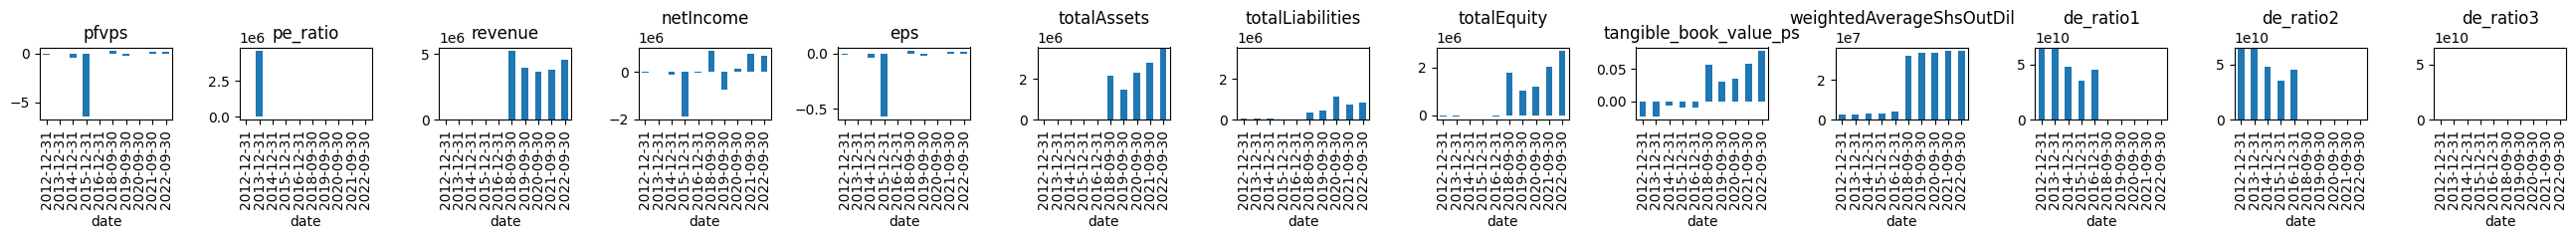

  5%|█████▎                                                                                                              | 69/1495 [05:08<3:18:28,  8.35s/it]

length equals zero
less than 5 reports


  5%|█████▍                                                                                                              | 70/1495 [05:11<2:36:11,  6.58s/it]

overvalued. price: 44.16, pfvps: 2.810015074438803


  5%|█████▌                                                                                                              | 71/1495 [05:20<2:55:10,  7.38s/it]

only negative pe in history


  5%|█████▌                                                                                                              | 72/1495 [05:29<3:09:15,  7.98s/it]

length equals zero
less than 5 reports


  5%|█████▋                                                                                                              | 73/1495 [05:32<2:29:48,  6.32s/it]

overvalued. price: 3.05, pfvps: -1.1592596586094224


  5%|█████▋                                                                                                              | 74/1495 [05:42<3:00:50,  7.64s/it]

overvalued. price: 13.72, pfvps: 4.407340121467244


  5%|█████▊                                                                                                              | 75/1495 [05:54<3:31:06,  8.92s/it]

length equals zero
less than 5 reports


  5%|█████▉                                                                                                              | 76/1495 [05:57<2:45:20,  6.99s/it]

overvalued. price: 847.79, pfvps: 566.0339624197388


  5%|█████▉                                                                                                              | 77/1495 [06:08<3:14:48,  8.24s/it]

length equals zero
less than 5 reports


  5%|██████                                                                                                              | 78/1495 [06:10<2:33:26,  6.50s/it]

negative growth


  5%|██████▏                                                                                                             | 79/1495 [06:13<2:04:03,  5.26s/it]

less than 5 reports


  5%|██████▏                                                                                                             | 80/1495 [06:15<1:44:00,  4.41s/it]

length equals zero
less than 5 reports


  5%|██████▎                                                                                                             | 81/1495 [06:18<1:30:05,  3.82s/it]

overvalued. price: 15.94, pfvps: 14.267160781045945


  5%|██████▎                                                                                                             | 82/1495 [06:27<2:12:28,  5.63s/it]

length equals zero
less than 5 reports


  6%|██████▍                                                                                                             | 83/1495 [06:30<1:52:34,  4.78s/it]

length equals zero
less than 5 reports


  6%|██████▌                                                                                                             | 84/1495 [06:33<1:36:00,  4.08s/it]

length equals zero
less than 5 reports


  6%|██████▌                                                                                                             | 85/1495 [06:35<1:24:13,  3.58s/it]

overvalued. price: 29.9, pfvps: 13.889869188355627


  6%|██████▋                                                                                                             | 86/1495 [06:45<2:09:55,  5.53s/it]

length equals zero
less than 5 reports


  6%|██████▊                                                                                                             | 87/1495 [06:48<1:48:09,  4.61s/it]

overvalued. price: 2.39, pfvps: 0.0


  6%|██████▊                                                                                                             | 88/1495 [06:58<2:29:32,  6.38s/it]

length equals zero
less than 5 reports


  6%|██████▉                                                                                                             | 89/1495 [07:01<2:01:56,  5.20s/it]

length equals zero
less than 5 reports


  6%|██████▉                                                                                                             | 90/1495 [07:03<1:42:24,  4.37s/it]

length equals zero
less than 5 reports


  6%|███████                                                                                                             | 91/1495 [07:06<1:28:45,  3.79s/it]

length equals zero
less than 5 reports


  6%|███████▏                                                                                                            | 92/1495 [07:09<1:24:13,  3.60s/it]

negative growth


  6%|███████▏                                                                                                            | 93/1495 [07:11<1:18:09,  3.34s/it]

length equals zero
less than 5 reports


  6%|███████▎                                                                                                            | 94/1495 [07:14<1:11:33,  3.06s/it]

length equals zero
less than 5 reports


  6%|███████▎                                                                                                            | 95/1495 [07:16<1:06:49,  2.86s/it]

negative growth


  6%|███████▍                                                                                                            | 96/1495 [07:19<1:03:19,  2.72s/it]

length equals zero
less than 5 reports


  6%|███████▌                                                                                                            | 97/1495 [07:21<1:01:20,  2.63s/it]

length equals zero
less than 5 reports


  7%|███████▌                                                                                                            | 98/1495 [07:24<1:00:25,  2.60s/it]

length equals zero
less than 5 reports


  7%|███████▊                                                                                                              | 99/1495 [07:26<59:15,  2.55s/it]

length equals zero
less than 5 reports


  7%|███████▊                                                                                                             | 100/1495 [07:28<58:18,  2.51s/it]

length equals zero
less than 5 reports


  7%|███████▉                                                                                                             | 101/1495 [07:31<57:43,  2.48s/it]

overvalued. price: 21.22, pfvps: 12.304315478272146


  7%|███████▊                                                                                                           | 102/1495 [07:41<1:49:17,  4.71s/it]

TBTC.	 Current price: 4.06.	 Faire price: 6.702966064713062


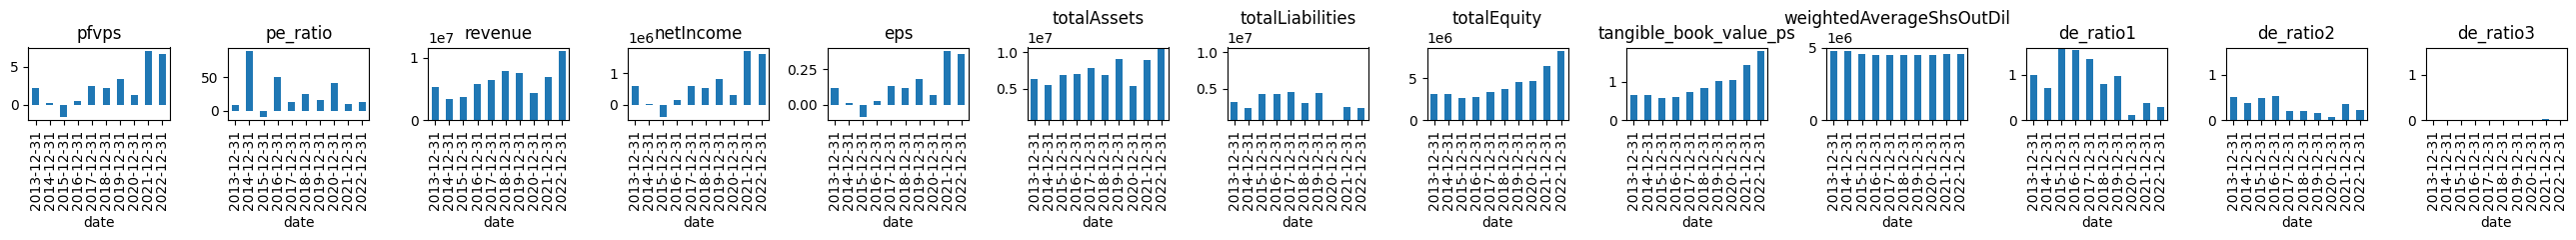

  7%|███████▉                                                                                                           | 103/1495 [08:02<3:41:30,  9.55s/it]

overvalued. price: 5.86, pfvps: -0.7415948950522543


  7%|████████                                                                                                           | 104/1495 [08:12<3:50:40,  9.95s/it]

length equals zero
less than 5 reports


  7%|████████                                                                                                           | 105/1495 [08:15<2:58:47,  7.72s/it]

length equals zero
less than 5 reports


  7%|████████▏                                                                                                          | 106/1495 [08:17<2:21:48,  6.13s/it]

length equals zero
less than 5 reports


  7%|████████▏                                                                                                          | 107/1495 [08:20<1:55:57,  5.01s/it]

only negative pe in history


  7%|████████▎                                                                                                          | 108/1495 [08:28<2:19:57,  6.05s/it]

negative growth


  7%|████████▍                                                                                                          | 109/1495 [08:31<1:54:10,  4.94s/it]

length equals zero
less than 5 reports


  7%|████████▍                                                                                                          | 110/1495 [08:33<1:36:41,  4.19s/it]

length equals zero
less than 5 reports


  7%|████████▌                                                                                                          | 111/1495 [08:35<1:24:14,  3.65s/it]

length equals zero
less than 5 reports


  7%|████████▌                                                                                                          | 112/1495 [08:38<1:15:43,  3.29s/it]

length equals zero
less than 5 reports


  8%|████████▋                                                                                                          | 113/1495 [08:40<1:09:52,  3.03s/it]

less than 5 reports


  8%|████████▊                                                                                                          | 114/1495 [08:43<1:05:28,  2.84s/it]

length equals zero
less than 5 reports


  8%|████████▊                                                                                                          | 115/1495 [08:45<1:02:30,  2.72s/it]

length equals zero
less than 5 reports


  8%|████████▉                                                                                                          | 116/1495 [08:48<1:01:49,  2.69s/it]

length equals zero
less than 5 reports


  8%|█████████                                                                                                          | 117/1495 [08:50<1:00:12,  2.62s/it]

length equals zero
less than 5 reports


  8%|█████████▏                                                                                                           | 118/1495 [08:53<58:38,  2.56s/it]

length equals zero
less than 5 reports


  8%|█████████▎                                                                                                           | 119/1495 [08:55<57:31,  2.51s/it]

negative growth


  8%|█████████▍                                                                                                           | 120/1495 [08:57<56:26,  2.46s/it]

length equals zero
less than 5 reports


  8%|█████████▍                                                                                                           | 121/1495 [09:00<57:55,  2.53s/it]

ET.	 Current price: 14.03.	 Faire price: 22.74625093117159


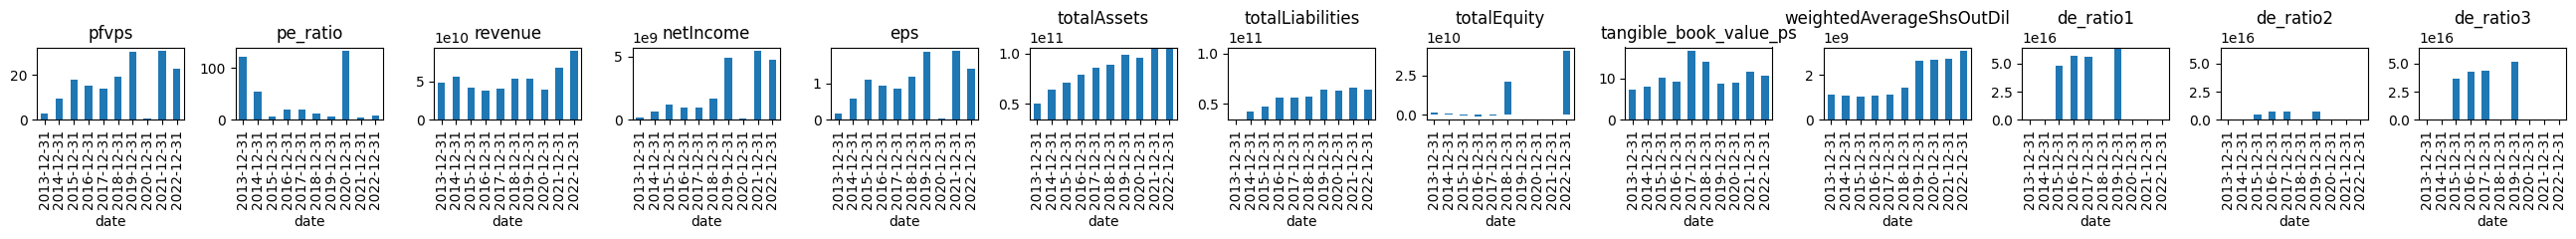

  8%|█████████▍                                                                                                         | 122/1495 [09:19<2:47:43,  7.33s/it]

length equals zero
less than 5 reports


  8%|█████████▍                                                                                                         | 123/1495 [09:21<2:13:47,  5.85s/it]

length equals zero
less than 5 reports


  8%|█████████▌                                                                                                         | 124/1495 [09:24<1:51:19,  4.87s/it]

length equals zero
less than 5 reports


  8%|█████████▌                                                                                                         | 125/1495 [09:26<1:34:30,  4.14s/it]

length equals zero
less than 5 reports


  8%|█████████▋                                                                                                         | 126/1495 [09:29<1:26:55,  3.81s/it]

only negative pe in history


  8%|█████████▊                                                                                                         | 127/1495 [09:36<1:50:32,  4.85s/it]

overvalued. price: 3.18, pfvps: 2.2701300197636836


  9%|█████████▊                                                                                                         | 128/1495 [09:48<2:40:03,  7.03s/it]

only negative pe in history


  9%|█████████▉                                                                                                         | 129/1495 [09:55<2:39:24,  7.00s/it]

less than 5 reports


  9%|██████████                                                                                                         | 130/1495 [09:58<2:07:28,  5.60s/it]

negative growth


  9%|██████████                                                                                                         | 131/1495 [10:00<1:45:23,  4.64s/it]

length equals zero
less than 5 reports


  9%|██████████▏                                                                                                        | 132/1495 [10:03<1:30:13,  3.97s/it]

less than 5 reports


  9%|██████████▏                                                                                                        | 133/1495 [10:06<1:24:10,  3.71s/it]

overvalued. price: 6.13, pfvps: 1.512731932718615


  9%|██████████▎                                                                                                        | 134/1495 [10:17<2:13:24,  5.88s/it]

less than 5 reports


  9%|██████████▍                                                                                                        | 135/1495 [10:19<1:49:31,  4.83s/it]

length equals zero
less than 5 reports


  9%|██████████▍                                                                                                        | 136/1495 [10:27<2:08:03,  5.65s/it]

only negative pe in history


  9%|██████████▌                                                                                                        | 137/1495 [10:36<2:36:10,  6.90s/it]

length equals zero
less than 5 reports


  9%|██████████▌                                                                                                        | 138/1495 [10:39<2:07:55,  5.66s/it]

length equals zero
less than 5 reports


  9%|██████████▋                                                                                                        | 139/1495 [10:42<1:45:57,  4.69s/it]

CRAWA.	 Current price: 28.08.	 Faire price: 89.02034186891466


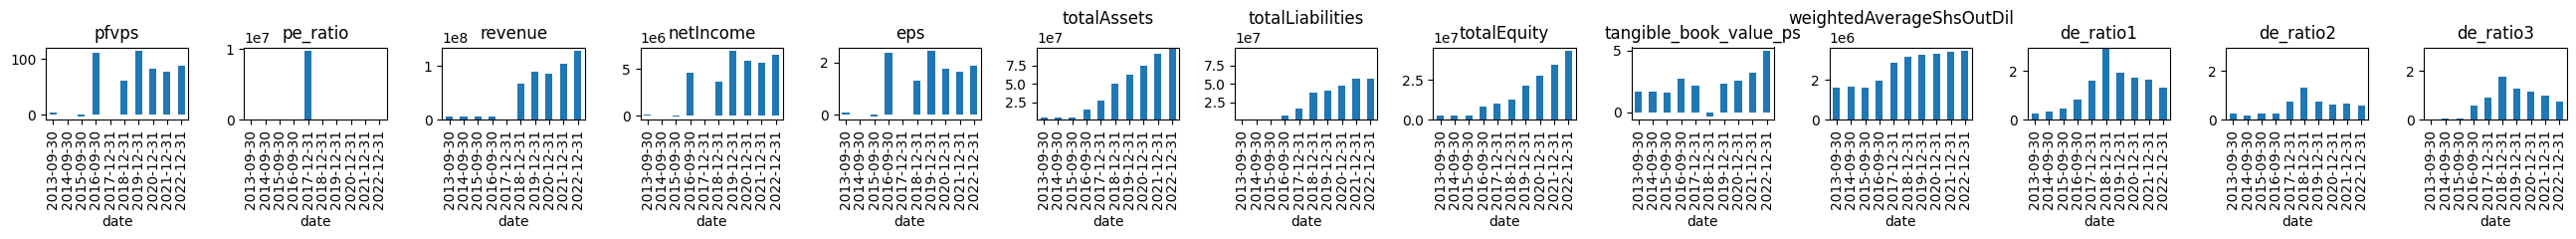

  9%|██████████▊                                                                                                        | 140/1495 [11:01<3:24:29,  9.06s/it]

overvalued. price: 4.41, pfvps: 2.1843588445216047


  9%|██████████▊                                                                                                        | 141/1495 [11:09<3:20:30,  8.89s/it]

less than 5 reports


  9%|██████████▉                                                                                                        | 142/1495 [11:12<2:36:16,  6.93s/it]

negative growth


 10%|███████████                                                                                                        | 143/1495 [11:14<2:05:32,  5.57s/it]

length equals zero
less than 5 reports


 10%|███████████                                                                                                        | 144/1495 [11:17<1:46:25,  4.73s/it]

length equals zero
less than 5 reports


 10%|███████████▏                                                                                                       | 145/1495 [11:20<1:34:09,  4.18s/it]

CODA.	 Current price: 6.2.	 Faire price: 8.559039363516815


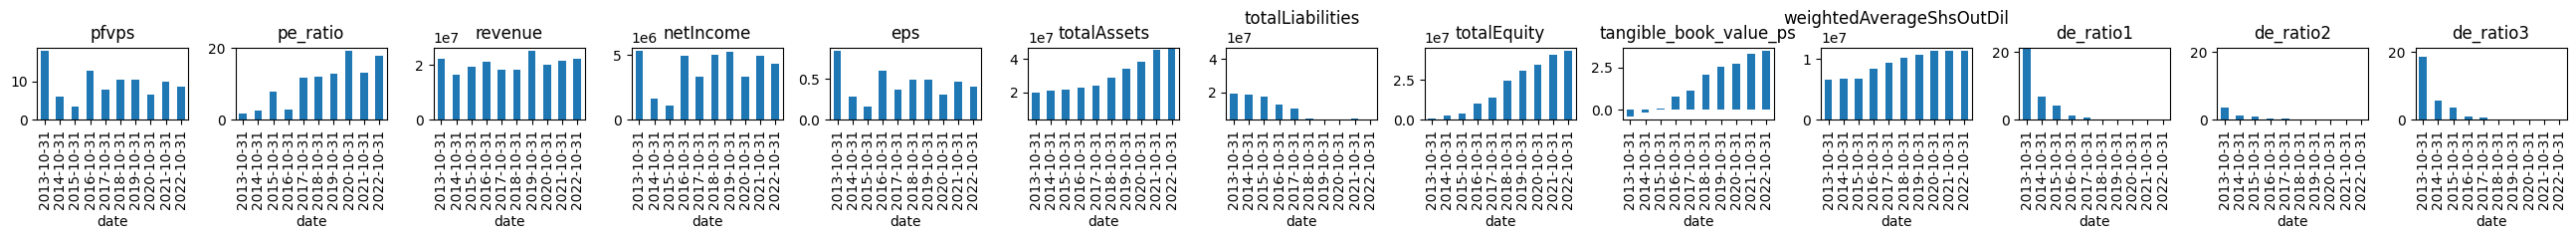

 10%|███████████▏                                                                                                       | 146/1495 [11:38<3:11:38,  8.52s/it]

overvalued. price: None, pfvps: 31.97190998815287


 10%|███████████▎                                                                                                       | 147/1495 [11:48<3:21:08,  8.95s/it]

less than 5 reports


 10%|███████████▍                                                                                                       | 148/1495 [11:51<2:36:48,  6.98s/it]

length equals zero
less than 5 reports


 10%|███████████▍                                                                                                       | 149/1495 [11:53<2:06:26,  5.64s/it]

length equals zero
less than 5 reports


 10%|███████████▌                                                                                                       | 150/1495 [11:56<1:44:48,  4.68s/it]

length equals zero
less than 5 reports


 10%|███████████▌                                                                                                       | 151/1495 [11:58<1:29:25,  3.99s/it]

overvalued. price: 27.38, pfvps: 15.052339637592706


 10%|███████████▋                                                                                                       | 152/1495 [12:08<2:11:20,  5.87s/it]

length equals zero
less than 5 reports


 10%|███████████▊                                                                                                       | 153/1495 [12:11<1:51:45,  5.00s/it]

length equals zero
less than 5 reports


 10%|███████████▊                                                                                                       | 154/1495 [12:14<1:39:44,  4.46s/it]

overvalued. price: 1.4, pfvps: 0.6098873121502251


 10%|███████████▉                                                                                                       | 155/1495 [12:24<2:15:31,  6.07s/it]

length equals zero
less than 5 reports


 10%|████████████                                                                                                       | 156/1495 [12:27<1:51:05,  4.98s/it]

only negative pe in history


 11%|████████████                                                                                                       | 157/1495 [12:36<2:19:40,  6.26s/it]

length equals zero
less than 5 reports


 11%|████████████▏                                                                                                      | 158/1495 [12:38<1:53:55,  5.11s/it]

length equals zero
less than 5 reports


 11%|████████████▏                                                                                                      | 159/1495 [12:41<1:35:53,  4.31s/it]

length equals zero
less than 5 reports


 11%|████████████▎                                                                                                      | 160/1495 [12:43<1:23:13,  3.74s/it]

length equals zero
less than 5 reports


 11%|████████████▍                                                                                                      | 161/1495 [12:46<1:18:39,  3.54s/it]

length equals zero
less than 5 reports


 11%|████████████▍                                                                                                      | 162/1495 [12:49<1:11:22,  3.21s/it]

negative growth


 11%|████████████▌                                                                                                      | 163/1495 [12:51<1:05:30,  2.95s/it]

overvalued. price: 0.168, pfvps: -13.547278258508923


 11%|████████████▌                                                                                                      | 164/1495 [13:01<1:54:34,  5.17s/it]

VTSI.	 Current price: 5.58.	 Faire price: 6.485159767048919


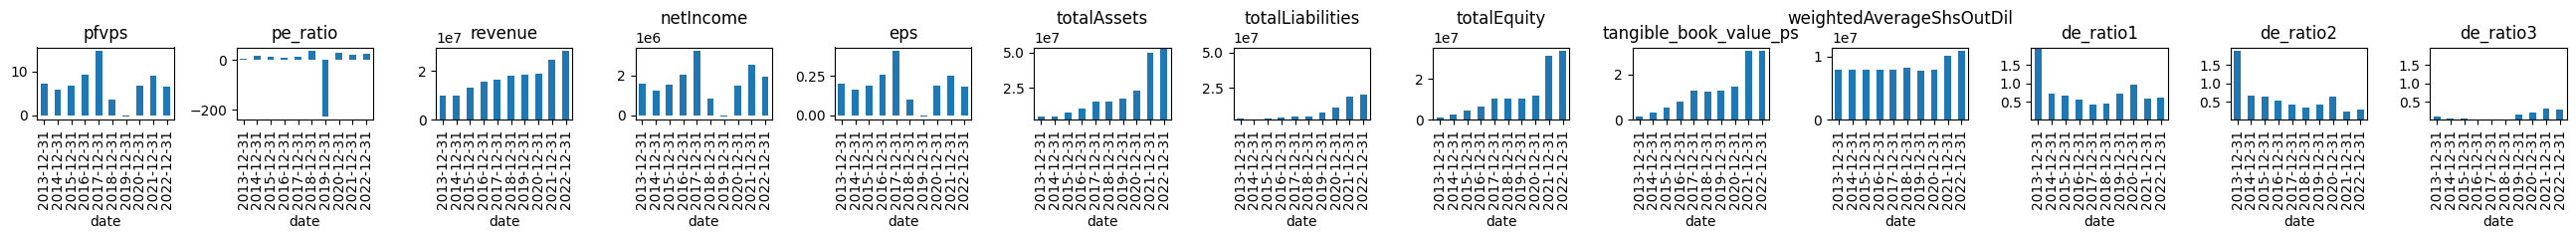

 11%|████████████▋                                                                                                      | 165/1495 [13:20<3:23:13,  9.17s/it]

only negative pe in history


 11%|████████████▊                                                                                                      | 166/1495 [13:29<3:25:23,  9.27s/it]

only negative pe in history


 11%|████████████▊                                                                                                      | 167/1495 [13:35<3:02:39,  8.25s/it]

length equals zero
less than 5 reports


 11%|████████████▉                                                                                                      | 168/1495 [13:38<2:23:40,  6.50s/it]

length equals zero
less than 5 reports


 11%|█████████████                                                                                                      | 169/1495 [13:40<1:57:03,  5.30s/it]

length equals zero
less than 5 reports


 11%|█████████████                                                                                                      | 170/1495 [13:43<1:41:51,  4.61s/it]

overvalued. price: 7.78, pfvps: -18.618480501633837


 11%|█████████████▏                                                                                                     | 171/1495 [13:54<2:23:46,  6.52s/it]

length equals zero
less than 5 reports


 12%|█████████████▏                                                                                                     | 172/1495 [13:57<1:56:46,  5.30s/it]

length equals zero
less than 5 reports


 12%|█████████████▎                                                                                                     | 173/1495 [13:59<1:37:49,  4.44s/it]

length equals zero
less than 5 reports


 12%|█████████████▍                                                                                                     | 174/1495 [14:02<1:27:58,  4.00s/it]

overvalued. price: None, pfvps: -4.6150981862909


 12%|█████████████▍                                                                                                     | 175/1495 [14:12<2:06:16,  5.74s/it]

negative growth


 12%|█████████████▌                                                                                                     | 176/1495 [14:14<1:43:50,  4.72s/it]

overvalued. price: 0.214, pfvps: -0.5709500857830277


 12%|█████████████▌                                                                                                     | 177/1495 [14:25<2:25:28,  6.62s/it]

length equals zero
less than 5 reports


 12%|█████████████▋                                                                                                     | 178/1495 [14:28<1:57:40,  5.36s/it]

overvalued. price: 8.44, pfvps: -0.43748671389174276


 12%|█████████████▊                                                                                                     | 179/1495 [14:38<2:27:30,  6.73s/it]

length equals zero
less than 5 reports


 12%|█████████████▊                                                                                                     | 180/1495 [14:40<1:59:40,  5.46s/it]

negative growth


 12%|█████████████▉                                                                                                     | 181/1495 [14:42<1:39:19,  4.54s/it]

length equals zero
less than 5 reports


 12%|██████████████                                                                                                     | 182/1495 [14:45<1:28:39,  4.05s/it]

overvalued. price: 14.56, pfvps: -0.25940969522601065


 12%|██████████████                                                                                                     | 183/1495 [14:57<2:14:58,  6.17s/it]

negative growth


 12%|██████████████▏                                                                                                    | 184/1495 [14:59<1:50:03,  5.04s/it]

FRD.	 Current price: 13.4.	 Faire price: 32.04700786729041


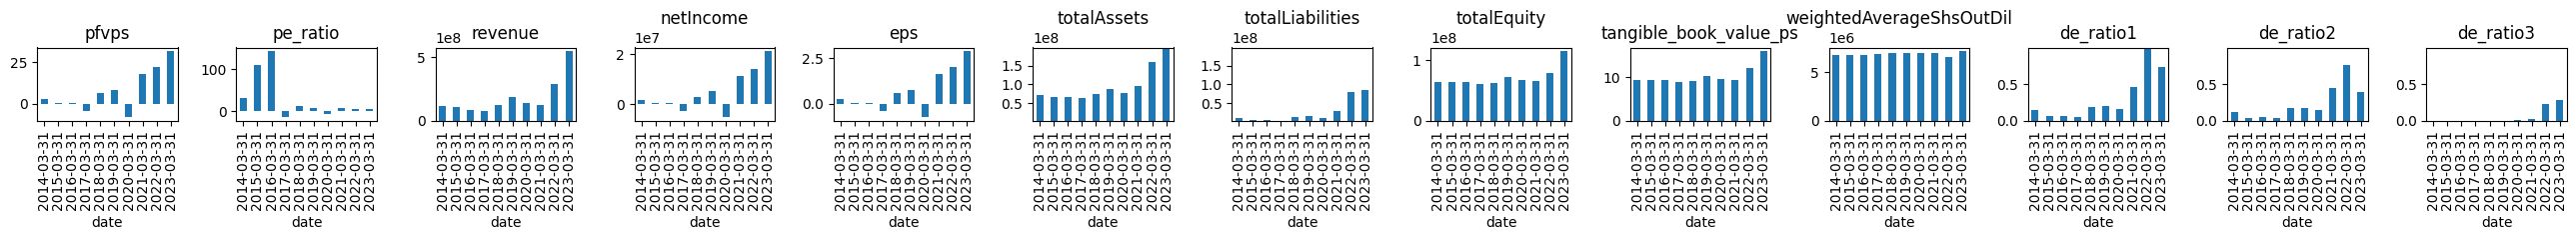

 12%|██████████████▏                                                                                                    | 185/1495 [15:19<3:25:54,  9.43s/it]

length equals zero
less than 5 reports


 12%|██████████████▎                                                                                                    | 186/1495 [15:21<2:39:40,  7.32s/it]

length equals zero
less than 5 reports


 13%|██████████████▍                                                                                                    | 187/1495 [15:23<2:07:54,  5.87s/it]

length equals zero
less than 5 reports


 13%|██████████████▍                                                                                                    | 188/1495 [15:26<1:46:22,  4.88s/it]

length equals zero
less than 5 reports


 13%|██████████████▌                                                                                                    | 189/1495 [15:29<1:35:47,  4.40s/it]

less than 5 reports


 13%|██████████████▌                                                                                                    | 190/1495 [15:32<1:22:33,  3.80s/it]

length equals zero
less than 5 reports


 13%|██████████████▋                                                                                                    | 191/1495 [15:34<1:13:24,  3.38s/it]

length equals zero
less than 5 reports


 13%|██████████████▊                                                                                                    | 192/1495 [15:37<1:07:56,  3.13s/it]

length equals zero
less than 5 reports


 13%|██████████████▊                                                                                                    | 193/1495 [15:39<1:04:29,  2.97s/it]

length equals zero
less than 5 reports


 13%|██████████████▉                                                                                                    | 194/1495 [15:42<1:00:44,  2.80s/it]

overvalued. price: 90.94, pfvps: 26.097296450020117


 13%|███████████████                                                                                                    | 195/1495 [15:52<1:51:19,  5.14s/it]

less than 5 reports


 13%|███████████████                                                                                                    | 196/1495 [15:55<1:36:32,  4.46s/it]

negative growth


 13%|███████████████▏                                                                                                   | 197/1495 [15:58<1:23:00,  3.84s/it]

length equals zero
less than 5 reports


 13%|███████████████▏                                                                                                   | 198/1495 [16:00<1:13:46,  3.41s/it]

overvalued. price: 47.03, pfvps: 16.36492137242987


 13%|███████████████▎                                                                                                   | 199/1495 [16:10<1:57:28,  5.44s/it]

length equals zero
less than 5 reports


 13%|███████████████▍                                                                                                   | 200/1495 [16:13<1:37:55,  4.54s/it]

overvalued. price: 25.08, pfvps: 9.336703458317336


 13%|███████████████▍                                                                                                   | 201/1495 [16:20<1:55:18,  5.35s/it]

length equals zero
less than 5 reports


 14%|███████████████▌                                                                                                   | 202/1495 [16:22<1:36:20,  4.47s/it]

length equals zero
less than 5 reports


 14%|███████████████▌                                                                                                   | 203/1495 [16:25<1:23:17,  3.87s/it]

length equals zero
less than 5 reports


 14%|███████████████▋                                                                                                   | 204/1495 [16:27<1:14:02,  3.44s/it]

length equals zero
less than 5 reports


 14%|███████████████▊                                                                                                   | 205/1495 [16:30<1:07:24,  3.14s/it]

length equals zero
less than 5 reports


 14%|███████████████▊                                                                                                   | 206/1495 [16:32<1:04:53,  3.02s/it]

length equals zero
less than 5 reports


 14%|███████████████▉                                                                                                   | 207/1495 [16:35<1:00:59,  2.84s/it]

only negative pe in history


 14%|████████████████                                                                                                   | 208/1495 [16:43<1:32:44,  4.32s/it]

length equals zero
less than 5 reports


 14%|████████████████                                                                                                   | 209/1495 [16:45<1:21:45,  3.81s/it]

negative growth


 14%|████████████████▏                                                                                                  | 210/1495 [16:48<1:16:11,  3.56s/it]

negative growth


 14%|████████████████▏                                                                                                  | 211/1495 [16:50<1:08:35,  3.21s/it]

overvalued. price: 5.04, pfvps: -6.425402648974079


 14%|████████████████▎                                                                                                  | 212/1495 [17:01<1:52:55,  5.28s/it]

overvalued. price: 65.42, pfvps: 1.5292909770829026


 14%|████████████████▍                                                                                                  | 213/1495 [17:11<2:22:32,  6.67s/it]

only negative pe in history


 14%|████████████████▍                                                                                                  | 214/1495 [17:22<2:55:15,  8.21s/it]

length equals zero
less than 5 reports


 14%|████████████████▌                                                                                                  | 215/1495 [17:25<2:18:02,  6.47s/it]

overvalued. price: 11.01, pfvps: -6.675381533747173


 14%|████████████████▌                                                                                                  | 216/1495 [17:35<2:39:57,  7.50s/it]

overvalued. price: 12.3, pfvps: -52.93962046301621


 15%|████████████████▋                                                                                                  | 217/1495 [17:45<2:59:43,  8.44s/it]

length equals zero
less than 5 reports


 15%|████████████████▊                                                                                                  | 218/1495 [17:48<2:23:10,  6.73s/it]

length equals zero
less than 5 reports


 15%|████████████████▊                                                                                                  | 219/1495 [17:51<1:59:28,  5.62s/it]

length equals zero
less than 5 reports


 15%|████████████████▉                                                                                                  | 220/1495 [17:53<1:39:15,  4.67s/it]

overvalued. price: 4.81, pfvps: -6.859322494787853


 15%|█████████████████                                                                                                  | 221/1495 [18:03<2:13:05,  6.27s/it]

overvalued. price: 28.66, pfvps: 23.935132936927882


 15%|█████████████████                                                                                                  | 222/1495 [18:13<2:35:39,  7.34s/it]

CLFD.	 Current price: 28.66.	 Faire price: 56.28704823942882


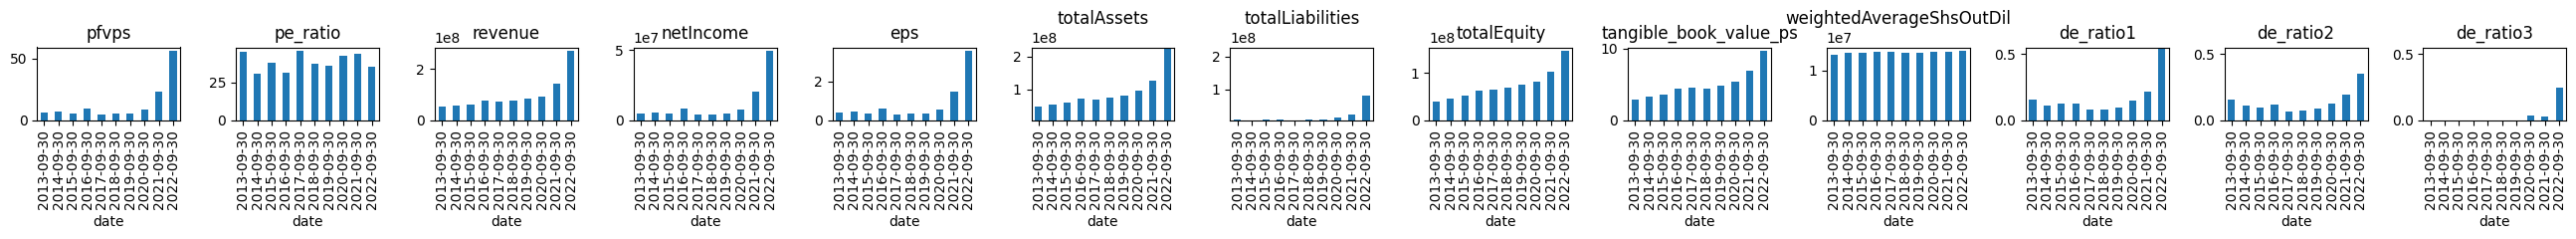

 15%|█████████████████▏                                                                                                 | 223/1495 [18:33<3:55:06, 11.09s/it]

length equals zero
less than 5 reports


 15%|█████████████████▏                                                                                                 | 224/1495 [18:36<2:59:56,  8.49s/it]

overvalued. price: 52.8, pfvps: 20.906247209092673


 15%|█████████████████▎                                                                                                 | 225/1495 [18:47<3:20:42,  9.48s/it]

overvalued. price: 0.5722, pfvps: 0.16545486194257683


 15%|█████████████████▍                                                                                                 | 226/1495 [18:58<3:25:07,  9.70s/it]

length equals zero
less than 5 reports


 15%|█████████████████▍                                                                                                 | 227/1495 [19:00<2:40:17,  7.58s/it]

length equals zero
less than 5 reports


 15%|█████████████████▌                                                                                                 | 228/1495 [19:03<2:07:28,  6.04s/it]

length equals zero
less than 5 reports


 15%|█████████████████▌                                                                                                 | 229/1495 [19:05<1:44:25,  4.95s/it]

overvalued. price: 0.7649, pfvps: -13.192301924732662


 15%|█████████████████▋                                                                                                 | 230/1495 [19:12<1:54:27,  5.43s/it]

overvalued. price: 0.1426, pfvps: -41.18656407178783


 15%|█████████████████▊                                                                                                 | 231/1495 [19:19<2:04:24,  5.91s/it]

negative growth


 16%|█████████████████▊                                                                                                 | 232/1495 [19:21<1:41:59,  4.85s/it]

overvalued. price: 2.18, pfvps: -0.08216719532321673


 16%|█████████████████▉                                                                                                 | 233/1495 [19:32<2:19:18,  6.62s/it]

length equals zero
less than 5 reports


 16%|██████████████████                                                                                                 | 234/1495 [19:35<1:55:45,  5.51s/it]

less than 5 reports


 16%|██████████████████                                                                                                 | 235/1495 [19:37<1:36:07,  4.58s/it]

negative growth


 16%|██████████████████▏                                                                                                | 236/1495 [19:40<1:23:02,  3.96s/it]

overvalued. price: 33.58, pfvps: 26.539553831452942


 16%|██████████████████▏                                                                                                | 237/1495 [19:51<2:10:51,  6.24s/it]

only negative pe in history


 16%|██████████████████▎                                                                                                | 238/1495 [19:57<2:07:49,  6.10s/it]

length equals zero
less than 5 reports


 16%|██████████████████▍                                                                                                | 239/1495 [20:00<1:47:49,  5.15s/it]

length equals zero
less than 5 reports


 16%|██████████████████▍                                                                                                | 240/1495 [20:03<1:32:44,  4.43s/it]

length equals zero
less than 5 reports


 16%|██████████████████▌                                                                                                | 241/1495 [20:06<1:22:50,  3.96s/it]

length equals zero
less than 5 reports


 16%|██████████████████▌                                                                                                | 242/1495 [20:08<1:13:37,  3.53s/it]

overvalued. price: 4.64, pfvps: -0.012267747451587799


 16%|██████████████████▋                                                                                                | 243/1495 [20:17<1:48:56,  5.22s/it]

overvalued. price: 35.32, pfvps: 18.30643245227495


 16%|██████████████████▊                                                                                                | 244/1495 [20:27<2:19:41,  6.70s/it]

length equals zero
less than 5 reports


 16%|██████████████████▊                                                                                                | 245/1495 [20:30<1:56:43,  5.60s/it]

length equals zero
less than 5 reports


 16%|██████████████████▉                                                                                                | 246/1495 [20:33<1:36:45,  4.65s/it]

length equals zero
less than 5 reports


 17%|███████████████████                                                                                                | 247/1495 [20:35<1:22:57,  3.99s/it]

length equals zero
less than 5 reports


 17%|███████████████████                                                                                                | 248/1495 [20:38<1:13:05,  3.52s/it]

length equals zero
less than 5 reports


 17%|███████████████████▏                                                                                               | 249/1495 [20:40<1:07:06,  3.23s/it]

length equals zero
less than 5 reports


 17%|███████████████████▏                                                                                               | 250/1495 [20:43<1:01:54,  2.98s/it]

less than 5 reports


 17%|███████████████████▋                                                                                                 | 251/1495 [20:45<58:25,  2.82s/it]

negative growth


 17%|███████████████████▋                                                                                                 | 252/1495 [20:48<57:50,  2.79s/it]

length equals zero
less than 5 reports


 17%|███████████████████▊                                                                                                 | 253/1495 [20:51<58:16,  2.81s/it]

less than 5 reports


 17%|███████████████████▉                                                                                                 | 254/1495 [20:53<55:23,  2.68s/it]

overvalued. price: 20.07, pfvps: -4.842021197329979


 17%|███████████████████▌                                                                                               | 255/1495 [21:05<1:50:28,  5.35s/it]

length equals zero
less than 5 reports


 17%|███████████████████▋                                                                                               | 256/1495 [21:07<1:32:28,  4.48s/it]

only negative pe in history


 17%|███████████████████▊                                                                                               | 257/1495 [21:16<2:01:18,  5.88s/it]

length equals zero
less than 5 reports


 17%|███████████████████▊                                                                                               | 258/1495 [21:19<1:39:48,  4.84s/it]

less than 5 reports


 17%|███████████████████▉                                                                                               | 259/1495 [21:22<1:28:02,  4.27s/it]

negative growth


 17%|████████████████████                                                                                               | 260/1495 [21:24<1:16:30,  3.72s/it]

length equals zero
less than 5 reports


 17%|████████████████████                                                                                               | 261/1495 [21:26<1:08:20,  3.32s/it]

negative growth


 18%|████████████████████▏                                                                                              | 262/1495 [21:29<1:02:40,  3.05s/it]

EDRY.	 Current price: 15.35.	 Faire price: 46.69165641828512


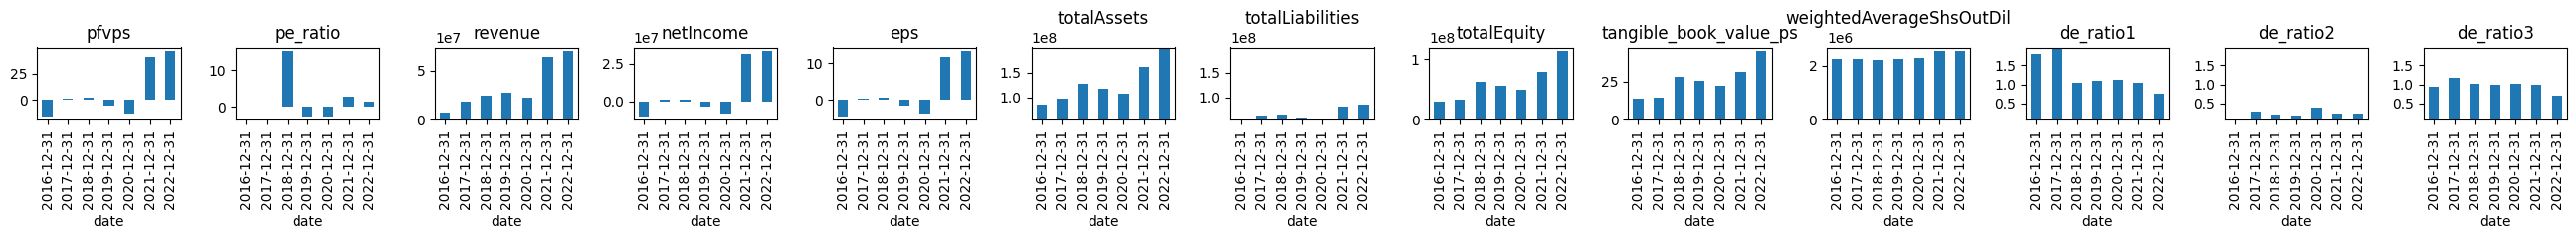

 18%|████████████████████▏                                                                                              | 263/1495 [21:43<2:10:17,  6.35s/it]

negative growth


 18%|████████████████████▎                                                                                              | 264/1495 [21:46<1:48:33,  5.29s/it]

length equals zero
less than 5 reports


 18%|████████████████████▍                                                                                              | 265/1495 [21:48<1:30:45,  4.43s/it]

length equals zero
less than 5 reports


 18%|████████████████████▍                                                                                              | 266/1495 [21:51<1:19:23,  3.88s/it]

length equals zero
less than 5 reports


 18%|████████████████████▌                                                                                              | 267/1495 [21:53<1:11:04,  3.47s/it]

METX.	 Current price: 2.03.	 Faire price: 2.8405179850186735


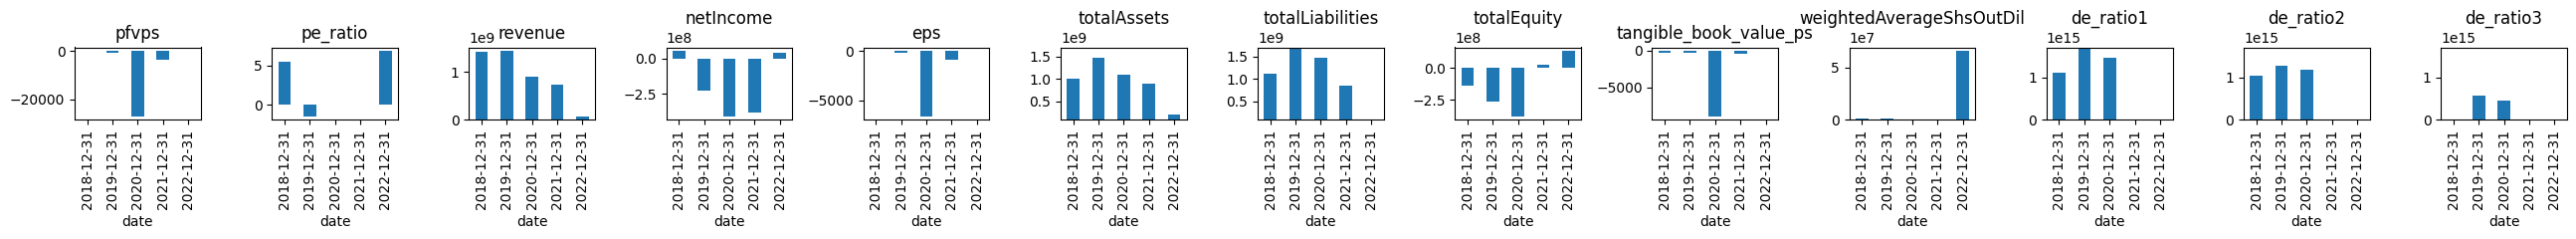

 18%|████████████████████▌                                                                                              | 268/1495 [22:06<2:06:01,  6.16s/it]

length equals zero
less than 5 reports


 18%|████████████████████▋                                                                                              | 269/1495 [22:08<1:43:01,  5.04s/it]

negative growth


 18%|████████████████████▊                                                                                              | 270/1495 [22:11<1:30:59,  4.46s/it]

negative growth


 18%|████████████████████▊                                                                                              | 271/1495 [22:14<1:18:18,  3.84s/it]

only negative pe in history


 18%|████████████████████▉                                                                                              | 272/1495 [22:20<1:31:45,  4.50s/it]

less than 5 reports


 18%|█████████████████████                                                                                              | 273/1495 [22:22<1:19:14,  3.89s/it]

length equals zero
less than 5 reports


 18%|█████████████████████                                                                                              | 274/1495 [22:25<1:10:27,  3.46s/it]

negative growth


 18%|█████████████████████▏                                                                                             | 275/1495 [22:27<1:03:50,  3.14s/it]

length equals zero
less than 5 reports


 18%|█████████████████████▌                                                                                               | 276/1495 [22:29<59:17,  2.92s/it]

length equals zero
less than 5 reports


 19%|█████████████████████▋                                                                                               | 277/1495 [22:32<58:01,  2.86s/it]

negative growth


 19%|█████████████████████▊                                                                                               | 278/1495 [22:34<55:05,  2.72s/it]

length equals zero
less than 5 reports


 19%|█████████████████████▊                                                                                               | 279/1495 [22:37<55:50,  2.76s/it]

AMX.	 Current price: 17.32.	 Faire price: 17.754149266089133


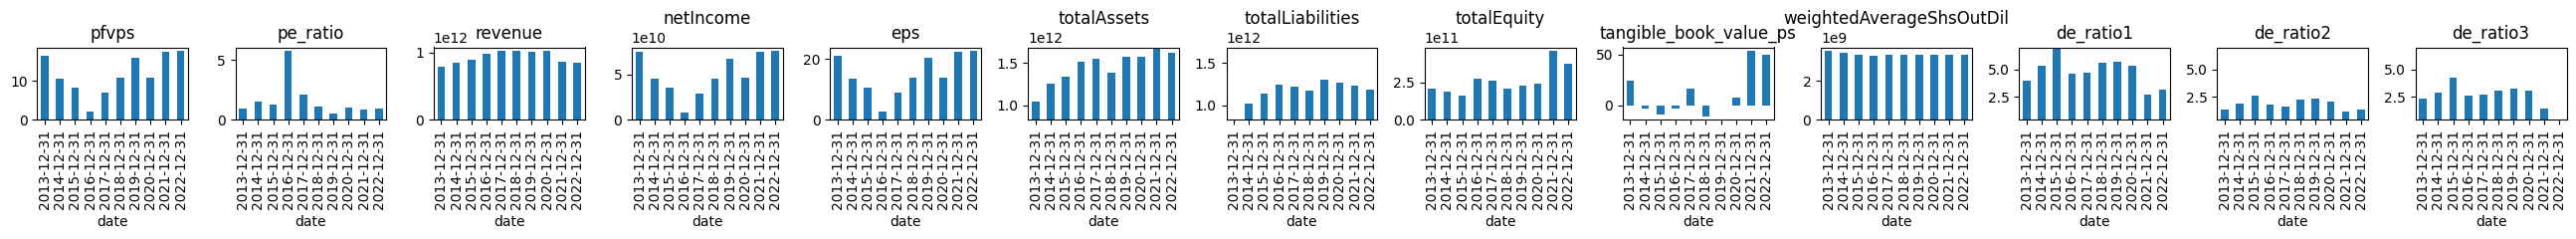

 19%|█████████████████████▌                                                                                             | 280/1495 [22:57<2:36:00,  7.70s/it]

length equals zero
less than 5 reports


 19%|█████████████████████▌                                                                                             | 281/1495 [23:00<2:07:44,  6.31s/it]

length equals zero
less than 5 reports


 19%|█████████████████████▋                                                                                             | 282/1495 [23:02<1:44:06,  5.15s/it]

STNG.	 Current price: 54.12.	 Faire price: 68.33504450003373


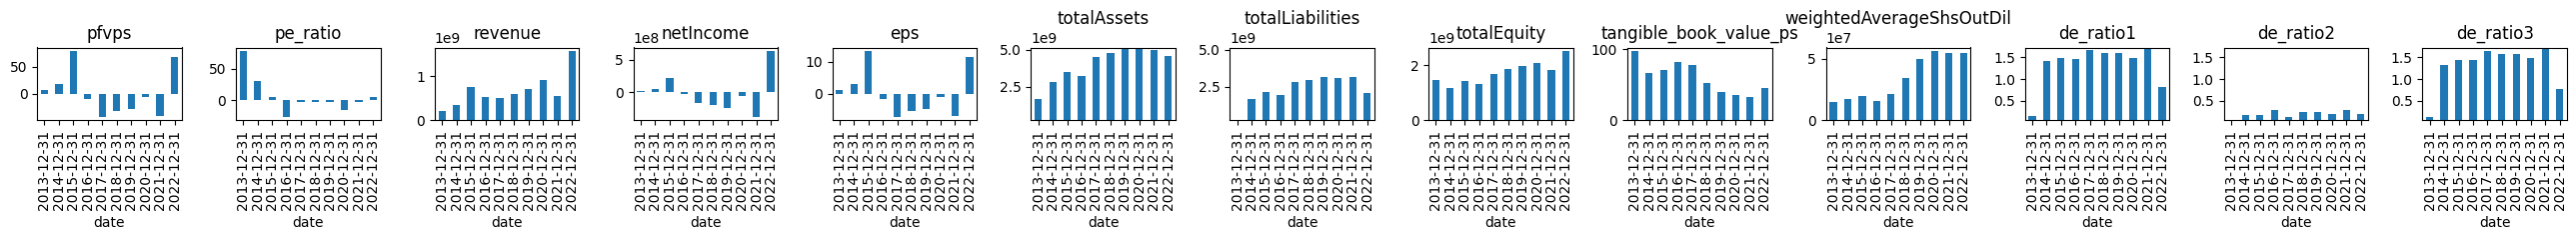

 19%|█████████████████████▊                                                                                             | 283/1495 [23:21<3:10:36,  9.44s/it]

overvalued. price: 3.29, pfvps: -0.5062686770039186


 19%|█████████████████████▊                                                                                             | 284/1495 [23:31<3:12:27,  9.54s/it]

negative growth


 19%|█████████████████████▉                                                                                             | 285/1495 [23:34<2:28:58,  7.39s/it]

length equals zero
less than 5 reports


 19%|██████████████████████                                                                                             | 286/1495 [23:36<1:59:03,  5.91s/it]

length equals zero
less than 5 reports


 19%|██████████████████████                                                                                             | 287/1495 [23:38<1:37:50,  4.86s/it]

length equals zero
less than 5 reports


 19%|██████████████████████▏                                                                                            | 288/1495 [23:41<1:23:02,  4.13s/it]

less than 5 reports


 19%|██████████████████████▏                                                                                            | 289/1495 [23:44<1:15:43,  3.77s/it]

length equals zero
less than 5 reports


 19%|██████████████████████▎                                                                                            | 290/1495 [23:47<1:10:33,  3.51s/it]

less than 5 reports


 19%|██████████████████████▍                                                                                            | 291/1495 [23:50<1:07:06,  3.34s/it]

length equals zero
less than 5 reports


 20%|██████████████████████▍                                                                                            | 292/1495 [23:52<1:01:18,  3.06s/it]

negative growth


 20%|██████████████████████▉                                                                                              | 293/1495 [23:55<57:22,  2.86s/it]

less than 5 reports


 20%|███████████████████████                                                                                              | 294/1495 [23:57<54:29,  2.72s/it]

less than 5 reports


 20%|███████████████████████                                                                                              | 295/1495 [24:00<56:14,  2.81s/it]

length equals zero
less than 5 reports


 20%|███████████████████████▏                                                                                             | 296/1495 [24:02<53:49,  2.69s/it]

length equals zero
less than 5 reports


 20%|███████████████████████▏                                                                                             | 297/1495 [24:05<53:15,  2.67s/it]

negative growth


 20%|███████████████████████▎                                                                                             | 298/1495 [24:08<53:46,  2.70s/it]

length equals zero
less than 5 reports


 20%|███████████████████████▍                                                                                             | 299/1495 [24:10<54:20,  2.73s/it]

overvalued. price: 10.33, pfvps: 2.999256853204757


 20%|███████████████████████                                                                                            | 300/1495 [24:21<1:43:14,  5.18s/it]

length equals zero
less than 5 reports


 20%|███████████████████████▏                                                                                           | 301/1495 [24:24<1:27:01,  4.37s/it]

length equals zero
less than 5 reports


 20%|███████████████████████▏                                                                                           | 302/1495 [24:27<1:18:16,  3.94s/it]

overvalued. price: 24.82, pfvps: 17.651384602194785


 20%|███████████████████████▎                                                                                           | 303/1495 [24:37<1:57:55,  5.94s/it]

length equals zero
less than 5 reports


 20%|███████████████████████▍                                                                                           | 304/1495 [24:40<1:36:54,  4.88s/it]

overvalued. price: 1.6, pfvps: -0.7926219768875741


 20%|███████████████████████▍                                                                                           | 305/1495 [24:55<2:35:52,  7.86s/it]

negative growth


 20%|███████████████████████▌                                                                                           | 306/1495 [24:57<2:05:11,  6.32s/it]

overvalued. price: 92.03, pfvps: 22.01551057564777


 21%|███████████████████████▌                                                                                           | 307/1495 [25:08<2:31:07,  7.63s/it]

overvalued. price: 228.46, pfvps: 89.28050941591576


 21%|███████████████████████▋                                                                                           | 308/1495 [25:20<2:57:44,  8.98s/it]

length equals zero
less than 5 reports


 21%|███████████████████████▊                                                                                           | 309/1495 [25:23<2:18:50,  7.02s/it]

length equals zero
less than 5 reports


 21%|███████████████████████▊                                                                                           | 310/1495 [25:25<1:51:31,  5.65s/it]

length equals zero
less than 5 reports


 21%|███████████████████████▉                                                                                           | 311/1495 [25:28<1:32:32,  4.69s/it]

length equals zero
less than 5 reports


 21%|████████████████████████                                                                                           | 312/1495 [25:30<1:20:01,  4.06s/it]

only negative pe in history


 21%|████████████████████████                                                                                           | 313/1495 [25:37<1:34:21,  4.79s/it]

length equals zero
less than 5 reports


 21%|████████████████████████▏                                                                                          | 314/1495 [25:39<1:20:20,  4.08s/it]

length equals zero
less than 5 reports


 21%|████████████████████████▏                                                                                          | 315/1495 [25:42<1:14:14,  3.77s/it]

overvalued. price: 46.52, pfvps: 22.987701375568506


 21%|████████████████████████▎                                                                                          | 316/1495 [25:53<1:53:59,  5.80s/it]

overvalued. price: 1.78, pfvps: -2.354354755181631


 21%|████████████████████████▍                                                                                          | 317/1495 [26:04<2:27:23,  7.51s/it]

length equals zero
less than 5 reports


 21%|████████████████████████▍                                                                                          | 318/1495 [26:07<2:01:09,  6.18s/it]

only negative pe in history


 21%|████████████████████████▌                                                                                          | 319/1495 [26:18<2:29:08,  7.61s/it]

length equals zero
less than 5 reports


 21%|████████████████████████▌                                                                                          | 320/1495 [26:21<1:58:45,  6.06s/it]

less than 5 reports


 21%|████████████████████████▋                                                                                          | 321/1495 [26:23<1:36:51,  4.95s/it]

length equals zero
less than 5 reports


 22%|████████████████████████▊                                                                                          | 322/1495 [26:25<1:22:06,  4.20s/it]

overvalued. price: 0.4099, pfvps: -0.7820895523756972


 22%|████████████████████████▊                                                                                          | 323/1495 [26:36<2:01:06,  6.20s/it]

negative growth


 22%|████████████████████████▉                                                                                          | 324/1495 [26:39<1:39:22,  5.09s/it]

overvalued. price: 0.9551, pfvps: 0.0952879907407313


 22%|█████████████████████████                                                                                          | 325/1495 [26:49<2:07:52,  6.56s/it]

overvalued. price: 3.53, pfvps: 0.334125385533492


 22%|█████████████████████████                                                                                          | 326/1495 [27:01<2:40:43,  8.25s/it]

length equals zero
less than 5 reports


 22%|█████████████████████████▏                                                                                         | 327/1495 [27:04<2:07:55,  6.57s/it]

LEAT.	 Current price: 12.01.	 Faire price: 48.398325360640186


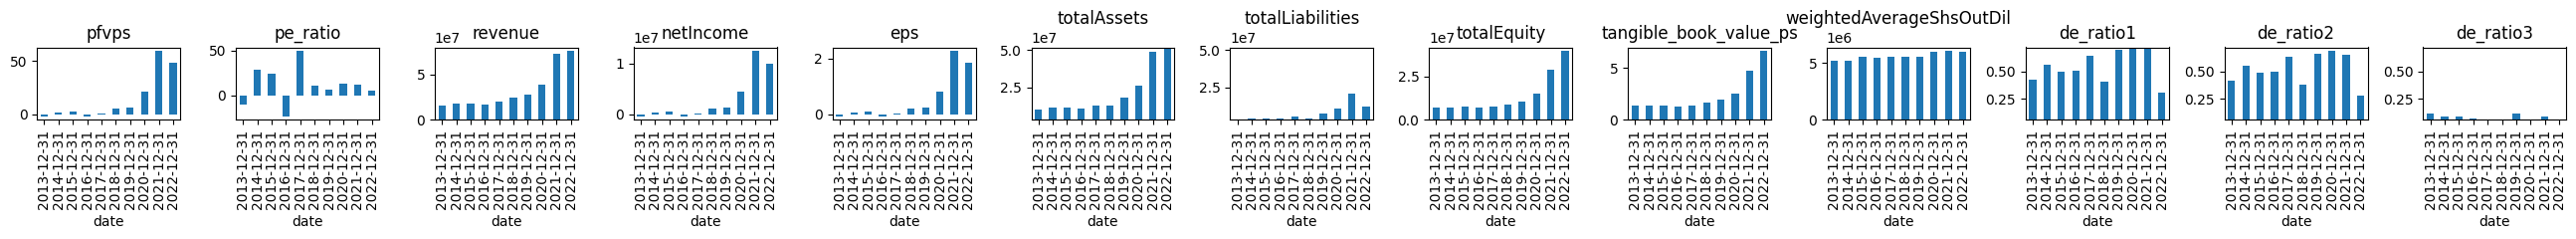

 22%|█████████████████████████▏                                                                                         | 328/1495 [27:22<3:18:29, 10.21s/it]

GLBS.	 Current price: 1.84.	 Faire price: 4.0453561266479126


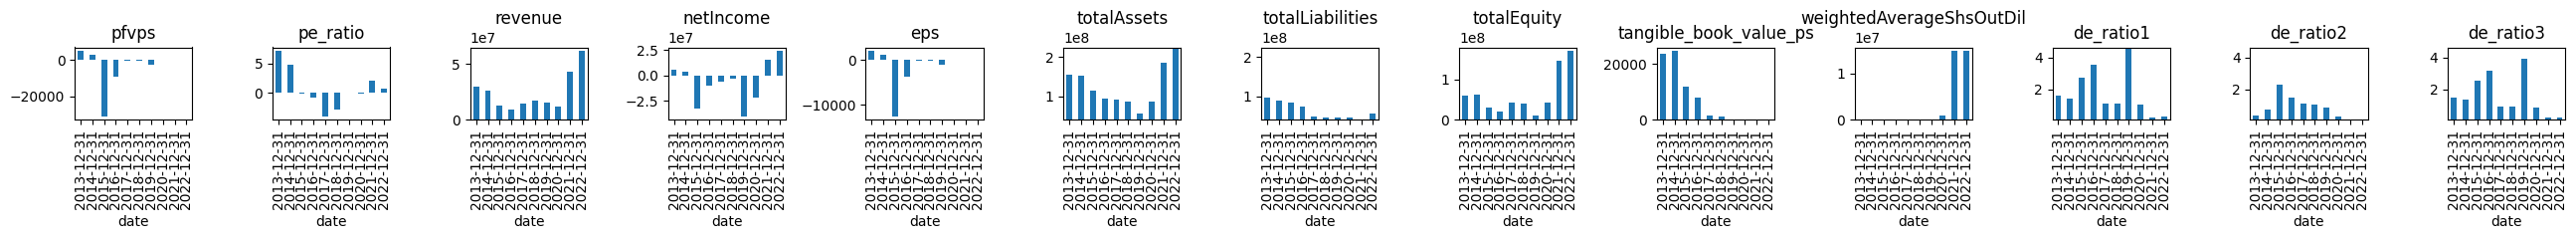

 22%|█████████████████████████▎                                                                                         | 329/1495 [27:41<4:06:52, 12.70s/it]

PETZ.	 Current price: 1.2.	 Faire price: 2.6982616009391216


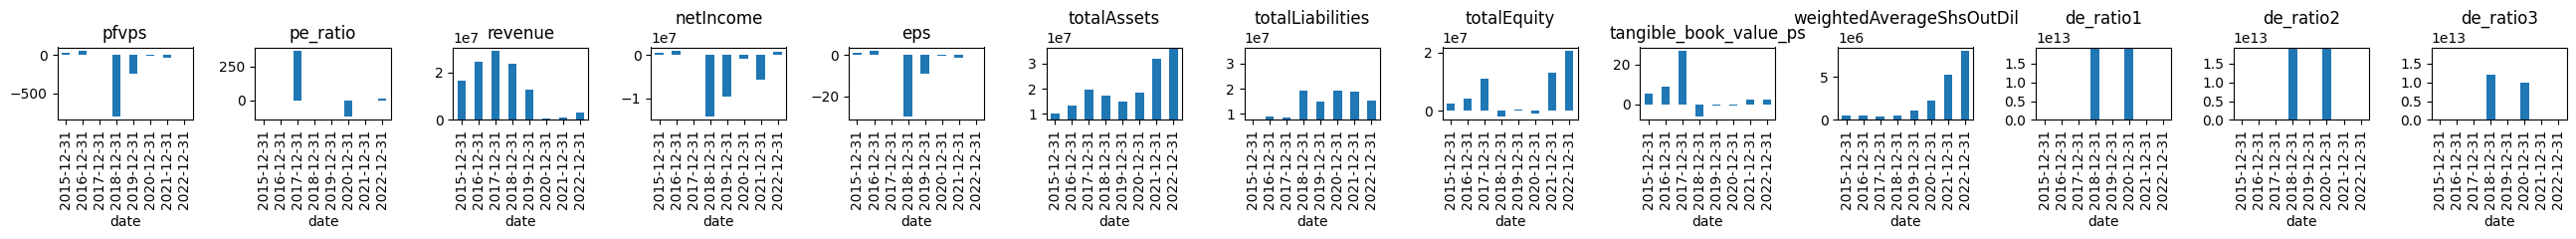

 22%|█████████████████████████▍                                                                                         | 330/1495 [28:01<4:47:58, 14.83s/it]

length equals zero
less than 5 reports


 22%|█████████████████████████▍                                                                                         | 331/1495 [28:03<3:35:30, 11.11s/it]

length equals zero
less than 5 reports


 22%|█████████████████████████▌                                                                                         | 332/1495 [28:06<2:44:57,  8.51s/it]

overvalued. price: 53.61, pfvps: 8.83707424291728


 22%|█████████████████████████▌                                                                                         | 333/1495 [28:17<3:02:07,  9.40s/it]

only negative pe in history


 22%|█████████████████████████▋                                                                                         | 334/1495 [28:26<2:58:46,  9.24s/it]

length equals zero
less than 5 reports


 22%|█████████████████████████▊                                                                                         | 335/1495 [28:28<2:19:05,  7.19s/it]

only negative pe in history


 22%|█████████████████████████▊                                                                                         | 336/1495 [28:38<2:31:12,  7.83s/it]

negative growth


 23%|█████████████████████████▉                                                                                         | 337/1495 [28:40<1:59:32,  6.19s/it]

only negative pe in history


 23%|██████████████████████████                                                                                         | 338/1495 [28:50<2:20:09,  7.27s/it]

less than 5 reports


 23%|██████████████████████████                                                                                         | 339/1495 [28:52<1:51:40,  5.80s/it]

length equals zero
less than 5 reports


 23%|██████████████████████████▏                                                                                        | 340/1495 [28:55<1:35:05,  4.94s/it]

GLG.	 Current price: 0.1439.	 Faire price: 0.3792688065911434


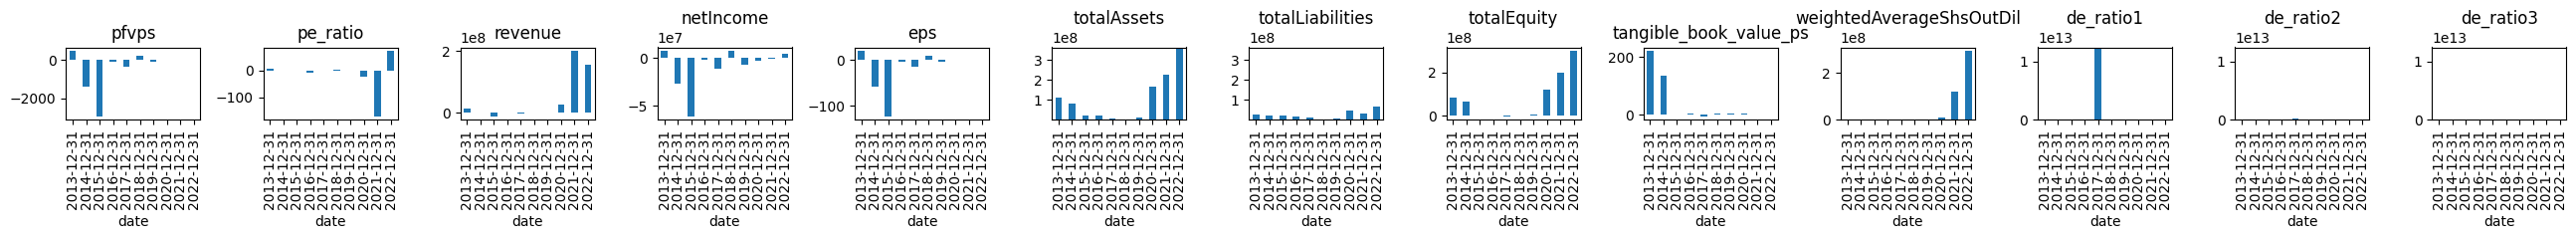

 23%|██████████████████████████▏                                                                                        | 341/1495 [29:13<2:52:57,  8.99s/it]

length equals zero
less than 5 reports


 23%|██████████████████████████▎                                                                                        | 342/1495 [29:17<2:18:32,  7.21s/it]

length equals zero
less than 5 reports


 23%|██████████████████████████▍                                                                                        | 343/1495 [29:20<1:54:35,  5.97s/it]

negative growth


 23%|██████████████████████████▍                                                                                        | 344/1495 [29:23<1:37:17,  5.07s/it]

less than 5 reports


 23%|██████████████████████████▌                                                                                        | 345/1495 [29:25<1:24:29,  4.41s/it]

length equals zero
less than 5 reports


 23%|██████████████████████████▌                                                                                        | 346/1495 [29:28<1:16:09,  3.98s/it]

HDSN.	 Current price: 13.3.	 Faire price: 16.87603483402267


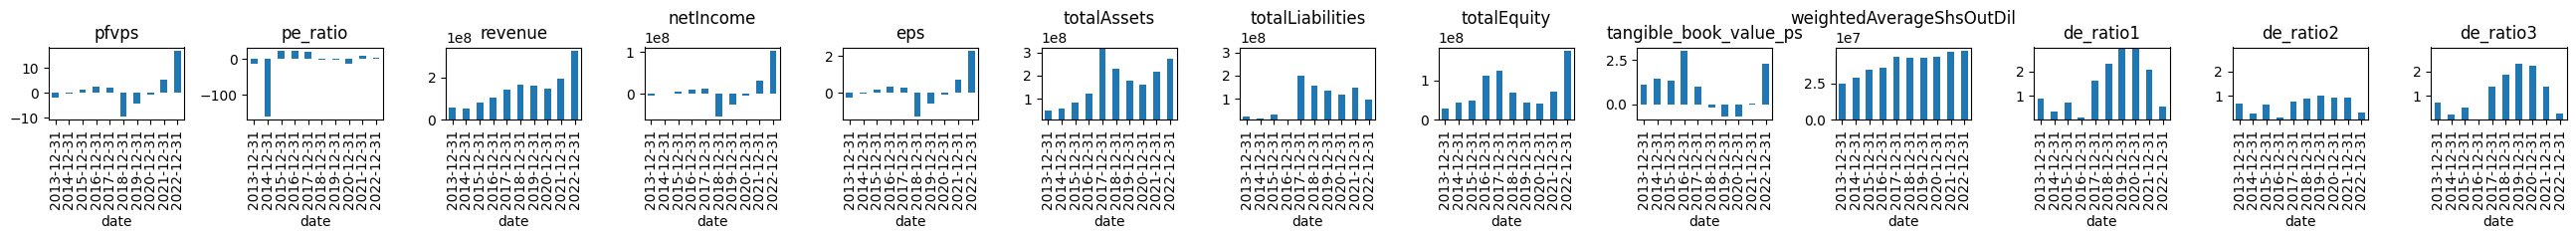

 23%|██████████████████████████▋                                                                                        | 347/1495 [29:48<2:47:18,  8.74s/it]

length equals zero
less than 5 reports


 23%|██████████████████████████▊                                                                                        | 348/1495 [29:51<2:14:35,  7.04s/it]

overvalued. price: 0.6961, pfvps: 0.0


 23%|██████████████████████████▊                                                                                        | 349/1495 [29:59<2:15:38,  7.10s/it]

length equals zero
less than 5 reports


 23%|██████████████████████████▉                                                                                        | 350/1495 [30:01<1:51:18,  5.83s/it]

negative growth


 23%|███████████████████████████                                                                                        | 351/1495 [30:04<1:31:23,  4.79s/it]

length equals zero
less than 5 reports


 24%|███████████████████████████                                                                                        | 352/1495 [30:06<1:17:51,  4.09s/it]

overvalued. price: 18.15, pfvps: 14.658971848123397


 24%|███████████████████████████▏                                                                                       | 353/1495 [30:16<1:51:48,  5.87s/it]

overvalued. price: 0.0019, pfvps: 0.0


 24%|███████████████████████████▏                                                                                       | 354/1495 [30:23<1:55:11,  6.06s/it]

length equals zero
less than 5 reports


 24%|███████████████████████████▎                                                                                       | 355/1495 [30:25<1:34:22,  4.97s/it]

length equals zero
less than 5 reports


 24%|███████████████████████████▍                                                                                       | 356/1495 [30:28<1:19:46,  4.20s/it]

length equals zero
less than 5 reports


 24%|███████████████████████████▍                                                                                       | 357/1495 [30:30<1:10:43,  3.73s/it]

only negative pe in history


 24%|███████████████████████████▌                                                                                       | 358/1495 [30:39<1:41:39,  5.36s/it]

less than 5 reports


 24%|███████████████████████████▌                                                                                       | 359/1495 [30:42<1:24:38,  4.47s/it]

overvalued. price: 10.93, pfvps: 5.769325855459869


 24%|███████████████████████████▋                                                                                       | 360/1495 [30:54<2:07:24,  6.73s/it]

length equals zero
less than 5 reports


 24%|███████████████████████████▊                                                                                       | 361/1495 [30:57<1:44:55,  5.55s/it]

overvalued. price: 19.45, pfvps: -1.8176202379076762


 24%|███████████████████████████▊                                                                                       | 362/1495 [31:08<2:18:23,  7.33s/it]

negative growth


 24%|███████████████████████████▉                                                                                       | 363/1495 [31:11<1:50:27,  5.86s/it]

only negative pe in history


 24%|████████████████████████████                                                                                       | 364/1495 [31:20<2:11:57,  7.00s/it]

only negative pe in history


 24%|████████████████████████████                                                                                       | 365/1495 [31:31<2:34:35,  8.21s/it]

negative growth


 24%|████████████████████████████▏                                                                                      | 366/1495 [31:34<2:01:29,  6.46s/it]

length equals zero
less than 5 reports


 25%|████████████████████████████▏                                                                                      | 367/1495 [31:36<1:38:40,  5.25s/it]

less than 5 reports


 25%|████████████████████████████▎                                                                                      | 368/1495 [31:38<1:22:19,  4.38s/it]

length equals zero
less than 5 reports


 25%|████████████████████████████▍                                                                                      | 369/1495 [31:41<1:13:02,  3.89s/it]

length equals zero
less than 5 reports


 25%|████████████████████████████▍                                                                                      | 370/1495 [31:44<1:06:03,  3.52s/it]

ERO.	 Current price: 17.24.	 Faire price: 36.77931379968648


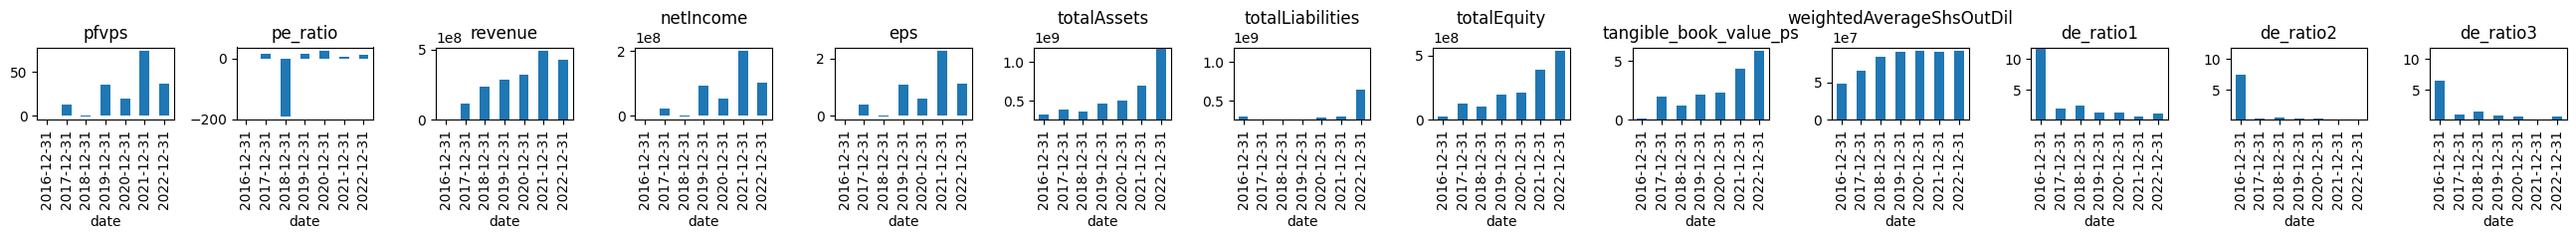

 25%|████████████████████████████▌                                                                                      | 371/1495 [31:59<2:10:56,  6.99s/it]

less than 5 reports


 25%|████████████████████████████▌                                                                                      | 372/1495 [32:01<1:44:57,  5.61s/it]

length equals zero
less than 5 reports


 25%|████████████████████████████▋                                                                                      | 373/1495 [32:04<1:27:01,  4.65s/it]

length equals zero
less than 5 reports


 25%|████████████████████████████▊                                                                                      | 374/1495 [32:07<1:16:41,  4.10s/it]

only negative pe in history


 25%|████████████████████████████▊                                                                                      | 375/1495 [32:14<1:33:57,  5.03s/it]

negative growth


 25%|████████████████████████████▉                                                                                      | 376/1495 [32:17<1:21:44,  4.38s/it]

length equals zero
less than 5 reports


 25%|█████████████████████████████                                                                                      | 377/1495 [32:20<1:14:11,  3.98s/it]

length equals zero
less than 5 reports


 25%|█████████████████████████████                                                                                      | 378/1495 [32:22<1:05:35,  3.52s/it]

length equals zero
less than 5 reports


 25%|█████████████████████████████▋                                                                                       | 379/1495 [32:25<59:35,  3.20s/it]

GTEC.	 Current price: 3.12.	 Faire price: 5.791681687166475


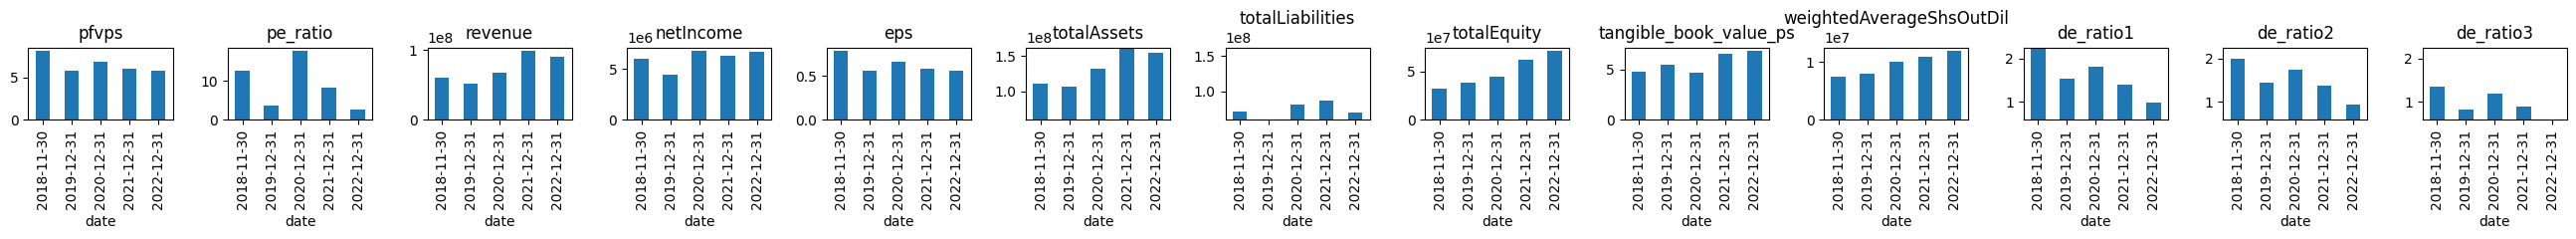

 25%|█████████████████████████████▏                                                                                     | 380/1495 [32:36<1:44:48,  5.64s/it]

length equals zero
less than 5 reports


 25%|█████████████████████████████▎                                                                                     | 381/1495 [32:38<1:27:19,  4.70s/it]

only negative pe in history


 26%|█████████████████████████████▍                                                                                     | 382/1495 [32:49<1:58:29,  6.39s/it]

length equals zero
less than 5 reports


 26%|█████████████████████████████▍                                                                                     | 383/1495 [32:51<1:37:43,  5.27s/it]

length equals zero
less than 5 reports


 26%|█████████████████████████████▌                                                                                     | 384/1495 [32:54<1:23:33,  4.51s/it]

negative growth


 26%|█████████████████████████████▌                                                                                     | 385/1495 [32:57<1:13:04,  3.95s/it]

overvalued. price: 0.01095, pfvps: -0.010684925588578973


 26%|█████████████████████████████▋                                                                                     | 386/1495 [33:08<1:55:48,  6.27s/it]

length equals zero
less than 5 reports


 26%|█████████████████████████████▊                                                                                     | 387/1495 [33:11<1:34:39,  5.13s/it]

negative growth


 26%|█████████████████████████████▊                                                                                     | 388/1495 [33:13<1:19:36,  4.31s/it]

negative growth


 26%|█████████████████████████████▉                                                                                     | 389/1495 [33:16<1:08:50,  3.74s/it]

negative growth


 26%|██████████████████████████████                                                                                     | 390/1495 [33:18<1:01:18,  3.33s/it]

length equals zero
less than 5 reports


 26%|██████████████████████████████▌                                                                                      | 391/1495 [33:21<59:33,  3.24s/it]

length equals zero
less than 5 reports


 26%|██████████████████████████████▋                                                                                      | 392/1495 [33:24<59:08,  3.22s/it]

length equals zero
less than 5 reports


 26%|██████████████████████████████▊                                                                                      | 393/1495 [33:27<57:46,  3.15s/it]

length equals zero
less than 5 reports


 26%|██████████████████████████████▊                                                                                      | 394/1495 [33:30<53:53,  2.94s/it]

ZDGE.	 Current price: 2.19.	 Faire price: 6.636403049766007


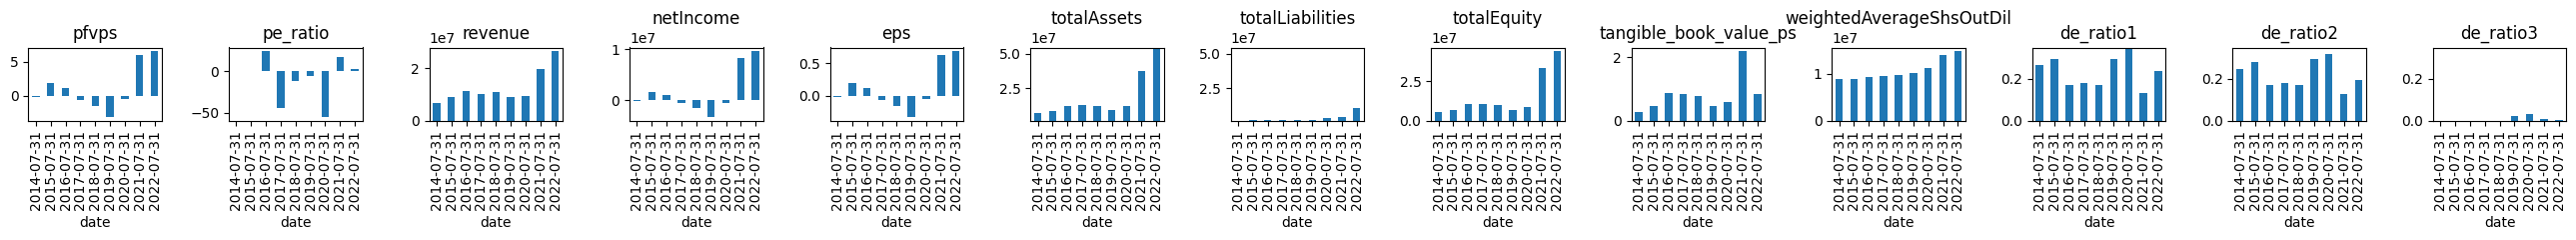

 26%|██████████████████████████████▍                                                                                    | 395/1495 [33:48<2:18:16,  7.54s/it]

only negative pe in history


 26%|██████████████████████████████▍                                                                                    | 396/1495 [33:55<2:16:55,  7.48s/it]

only negative pe in history


 27%|██████████████████████████████▌                                                                                    | 397/1495 [34:02<2:15:17,  7.39s/it]

length equals zero
less than 5 reports


 27%|██████████████████████████████▌                                                                                    | 398/1495 [34:05<1:47:53,  5.90s/it]

less than 5 reports


 27%|██████████████████████████████▋                                                                                    | 399/1495 [34:07<1:28:28,  4.84s/it]

length equals zero
less than 5 reports


 27%|██████████████████████████████▊                                                                                    | 400/1495 [34:10<1:18:01,  4.28s/it]

length equals zero
less than 5 reports


 27%|██████████████████████████████▊                                                                                    | 401/1495 [34:13<1:07:47,  3.72s/it]

length equals zero
less than 5 reports


 27%|██████████████████████████████▉                                                                                    | 402/1495 [34:15<1:02:42,  3.44s/it]

length equals zero
less than 5 reports


 27%|███████████████████████████████▌                                                                                     | 403/1495 [34:18<58:08,  3.19s/it]

length equals zero
less than 5 reports


 27%|███████████████████████████████▌                                                                                     | 404/1495 [34:21<57:09,  3.14s/it]

length equals zero
less than 5 reports


 27%|███████████████████████████████▋                                                                                     | 405/1495 [34:24<53:17,  2.93s/it]

length equals zero
less than 5 reports


 27%|███████████████████████████████▊                                                                                     | 406/1495 [34:26<50:36,  2.79s/it]

overvalued. price: 13.93, pfvps: 7.859032993923663


 27%|███████████████████████████████▎                                                                                   | 407/1495 [34:37<1:35:05,  5.24s/it]

length equals zero
less than 5 reports


 27%|███████████████████████████████▍                                                                                   | 408/1495 [34:40<1:22:08,  4.53s/it]

negative growth


 27%|███████████████████████████████▍                                                                                   | 409/1495 [34:42<1:10:38,  3.90s/it]

length equals zero
less than 5 reports


 27%|███████████████████████████████▌                                                                                   | 410/1495 [34:45<1:02:49,  3.47s/it]

negative growth


 27%|████████████████████████████████▏                                                                                    | 411/1495 [34:47<56:51,  3.15s/it]

overvalued. price: 8.76, pfvps: 2.3782545528986145


 28%|███████████████████████████████▋                                                                                   | 412/1495 [34:58<1:39:39,  5.52s/it]

length equals zero
less than 5 reports


 28%|███████████████████████████████▊                                                                                   | 413/1495 [35:01<1:22:51,  4.59s/it]

less than 5 reports


 28%|███████████████████████████████▊                                                                                   | 414/1495 [35:03<1:10:44,  3.93s/it]

overvalued. price: None, pfvps: 25.894909102029914


 28%|███████████████████████████████▉                                                                                   | 415/1495 [35:13<1:42:49,  5.71s/it]

length equals zero
less than 5 reports


 28%|████████████████████████████████                                                                                   | 416/1495 [35:15<1:24:51,  4.72s/it]

negative growth


 28%|████████████████████████████████                                                                                   | 417/1495 [35:18<1:15:53,  4.22s/it]

length equals zero
less than 5 reports


 28%|████████████████████████████████▏                                                                                  | 418/1495 [35:21<1:06:16,  3.69s/it]

length equals zero
less than 5 reports


 28%|████████████████████████████████▊                                                                                    | 419/1495 [35:23<59:25,  3.31s/it]

length equals zero
less than 5 reports


 28%|████████████████████████████████▊                                                                                    | 420/1495 [35:26<54:38,  3.05s/it]

overvalued. price: 69.92, pfvps: 12.354282364124282


 28%|████████████████████████████████▍                                                                                  | 421/1495 [35:37<1:39:53,  5.58s/it]

less than 5 reports


 28%|████████████████████████████████▍                                                                                  | 422/1495 [35:40<1:22:44,  4.63s/it]

CMC.	 Current price: 49.41.	 Faire price: 136.35130335068192


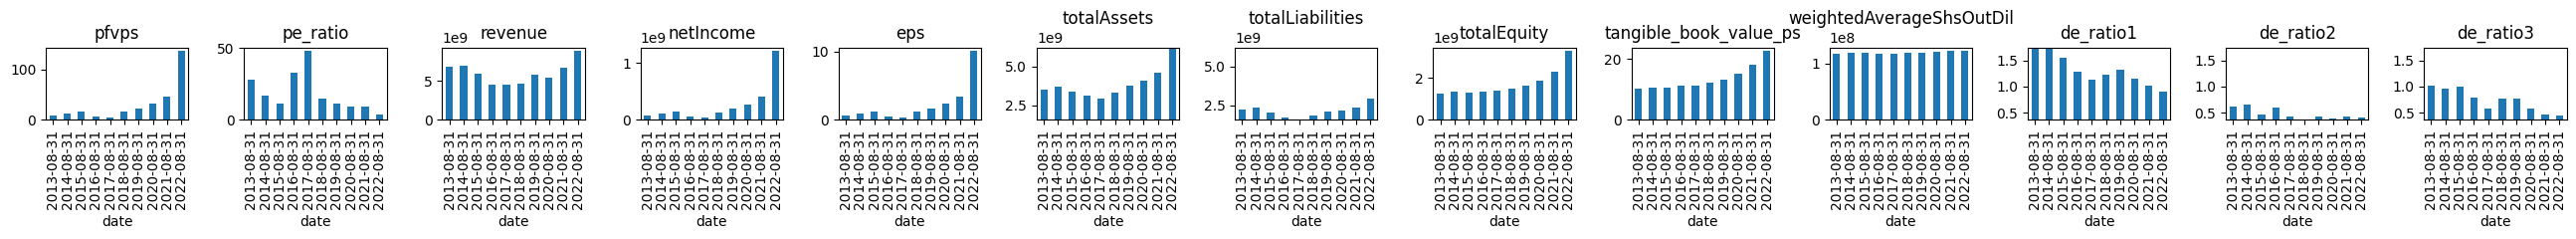

 28%|████████████████████████████████▌                                                                                  | 423/1495 [35:59<2:44:09,  9.19s/it]

length equals zero
less than 5 reports


 28%|████████████████████████████████▌                                                                                  | 424/1495 [36:02<2:07:46,  7.16s/it]

less than 5 reports


 28%|████████████████████████████████▋                                                                                  | 425/1495 [36:05<1:44:41,  5.87s/it]

length equals zero
less than 5 reports


 28%|████████████████████████████████▊                                                                                  | 426/1495 [36:07<1:27:48,  4.93s/it]

less than 5 reports


 29%|████████████████████████████████▊                                                                                  | 427/1495 [36:10<1:14:13,  4.17s/it]

length equals zero
less than 5 reports


 29%|████████████████████████████████▉                                                                                  | 428/1495 [36:12<1:04:51,  3.65s/it]

length equals zero
less than 5 reports


 29%|█████████████████████████████████                                                                                  | 429/1495 [36:15<1:01:36,  3.47s/it]

negative growth


 29%|█████████████████████████████████▋                                                                                   | 430/1495 [36:18<58:33,  3.30s/it]

overvalued. price: 1.02, pfvps: -2.1680829493127076


 29%|█████████████████████████████████▏                                                                                 | 431/1495 [36:25<1:18:59,  4.45s/it]

overvalued. price: 3.25, pfvps: -0.144335631951601


 29%|█████████████████████████████████▏                                                                                 | 432/1495 [36:36<1:49:32,  6.18s/it]

negative growth


 29%|█████████████████████████████████▎                                                                                 | 433/1495 [36:38<1:31:58,  5.20s/it]

LSEA.	 Current price: 8.99.	 Faire price: 100.61289223251028


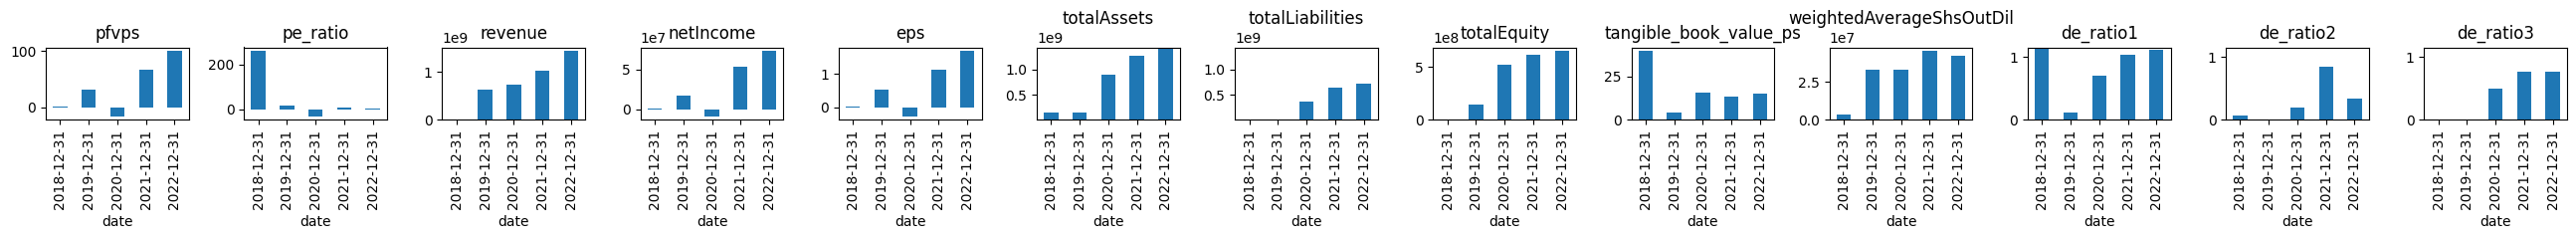

 29%|█████████████████████████████████▍                                                                                 | 434/1495 [36:52<2:15:03,  7.64s/it]

length equals zero
less than 5 reports


 29%|█████████████████████████████████▍                                                                                 | 435/1495 [36:55<1:50:29,  6.25s/it]

length equals zero
less than 5 reports


 29%|█████████████████████████████████▌                                                                                 | 436/1495 [36:58<1:32:27,  5.24s/it]

length equals zero
less than 5 reports


 29%|█████████████████████████████████▌                                                                                 | 437/1495 [37:00<1:17:19,  4.39s/it]

less than 5 reports


 29%|█████████████████████████████████▋                                                                                 | 438/1495 [37:03<1:09:03,  3.92s/it]

length equals zero
less than 5 reports


 29%|█████████████████████████████████▊                                                                                 | 439/1495 [37:05<1:01:13,  3.48s/it]

length equals zero
less than 5 reports


 29%|██████████████████████████████████▍                                                                                  | 440/1495 [37:08<57:40,  3.28s/it]

negative growth


 29%|██████████████████████████████████▌                                                                                  | 441/1495 [37:11<56:19,  3.21s/it]

less than 5 reports


 30%|██████████████████████████████████▌                                                                                  | 442/1495 [37:14<54:57,  3.13s/it]

less than 5 reports


 30%|██████████████████████████████████▋                                                                                  | 443/1495 [37:17<51:15,  2.92s/it]

only negative pe in history


 30%|██████████████████████████████████▏                                                                                | 444/1495 [37:26<1:27:06,  4.97s/it]

less than 5 reports


 30%|██████████████████████████████████▏                                                                                | 445/1495 [37:29<1:17:01,  4.40s/it]

overvalued. price: 3.14, pfvps: 0.9451401207195187


 30%|██████████████████████████████████▎                                                                                | 446/1495 [37:40<1:49:17,  6.25s/it]

IBEX.	 Current price: 15.45.	 Faire price: 89.7124681066187


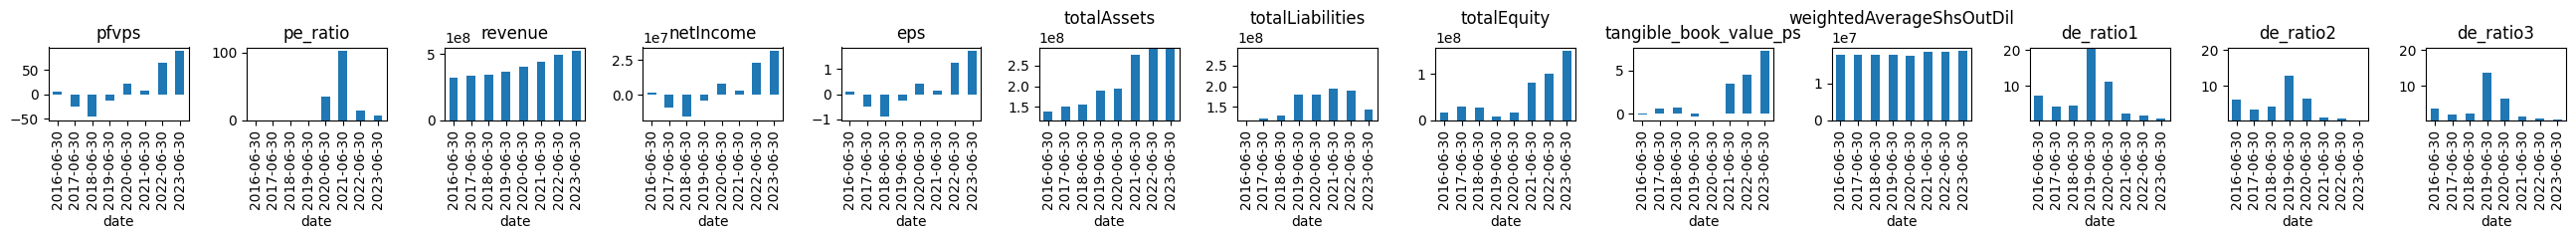

 30%|██████████████████████████████████▍                                                                                | 447/1495 [37:59<2:55:32, 10.05s/it]

negative growth


 30%|██████████████████████████████████▍                                                                                | 448/1495 [38:01<2:15:27,  7.76s/it]

length equals zero
less than 5 reports


 30%|██████████████████████████████████▌                                                                                | 449/1495 [38:04<1:47:18,  6.16s/it]

overvalued. price: None, pfvps: -4.144302681954584


 30%|██████████████████████████████████▌                                                                                | 450/1495 [38:13<2:01:00,  6.95s/it]

less than 5 reports


 30%|██████████████████████████████████▋                                                                                | 451/1495 [38:15<1:37:06,  5.58s/it]

length equals zero
less than 5 reports


 30%|██████████████████████████████████▊                                                                                | 452/1495 [38:17<1:20:47,  4.65s/it]

less than 5 reports


 30%|██████████████████████████████████▊                                                                                | 453/1495 [38:20<1:09:08,  3.98s/it]

less than 5 reports


 30%|██████████████████████████████████▉                                                                                | 454/1495 [38:22<1:00:41,  3.50s/it]

length equals zero
less than 5 reports


 30%|███████████████████████████████████▌                                                                                 | 455/1495 [38:25<55:05,  3.18s/it]

length equals zero
less than 5 reports


 31%|███████████████████████████████████▋                                                                                 | 456/1495 [38:28<53:54,  3.11s/it]

only negative pe in history


 31%|███████████████████████████████████▏                                                                               | 457/1495 [38:37<1:26:01,  4.97s/it]

overvalued. price: 0.286, pfvps: -0.0009030881511106504


 31%|███████████████████████████████████▏                                                                               | 458/1495 [38:47<1:51:42,  6.46s/it]

overvalued. price: 36.2, pfvps: 15.089578592960851


 31%|███████████████████████████████████▎                                                                               | 459/1495 [38:57<2:09:45,  7.52s/it]

negative growth


 31%|███████████████████████████████████▍                                                                               | 460/1495 [39:00<1:45:34,  6.12s/it]

SANW.	 Current price: 1.12.	 Faire price: 1.985783262915399


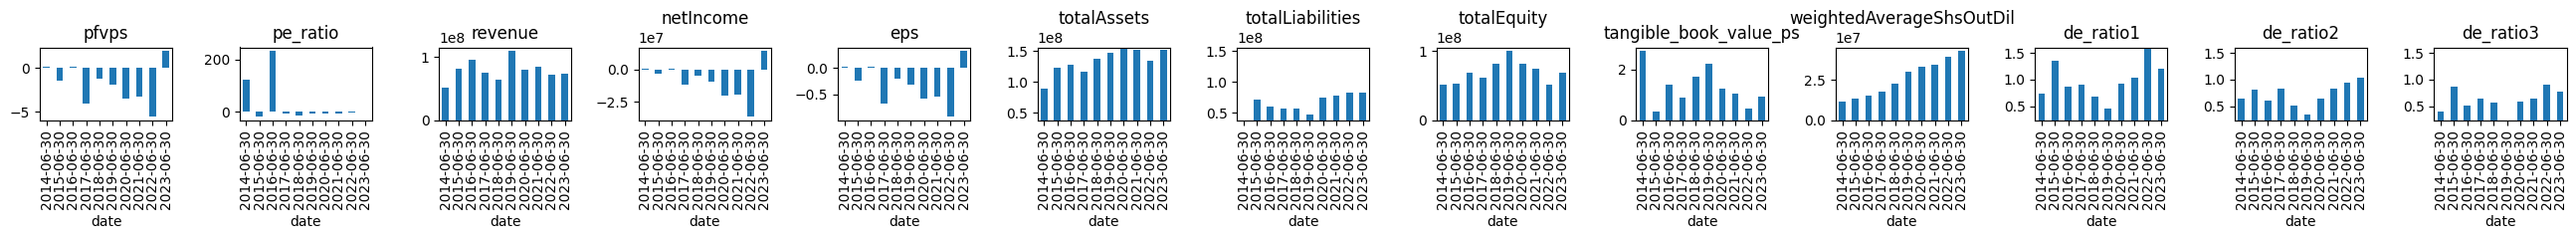

 31%|███████████████████████████████████▍                                                                               | 461/1495 [39:19<2:52:00,  9.98s/it]

negative growth


 31%|███████████████████████████████████▌                                                                               | 462/1495 [39:22<2:16:00,  7.90s/it]

length equals zero
less than 5 reports


 31%|███████████████████████████████████▌                                                                               | 463/1495 [39:24<1:47:35,  6.26s/it]

less than 5 reports


 31%|███████████████████████████████████▋                                                                               | 464/1495 [39:27<1:27:36,  5.10s/it]

length equals zero
less than 5 reports


 31%|███████████████████████████████████▊                                                                               | 465/1495 [39:29<1:13:48,  4.30s/it]

overvalued. price: 1.45, pfvps: -0.5325357167261069


 31%|███████████████████████████████████▊                                                                               | 466/1495 [39:39<1:42:44,  5.99s/it]

length equals zero
less than 5 reports


 31%|███████████████████████████████████▉                                                                               | 467/1495 [39:42<1:27:25,  5.10s/it]

overvalued. price: 4.71, pfvps: 2.3841887559154333


 31%|████████████████████████████████████                                                                               | 468/1495 [39:54<2:03:42,  7.23s/it]

KODK.	 Current price: 4.21.	 Faire price: 6.143333261709819


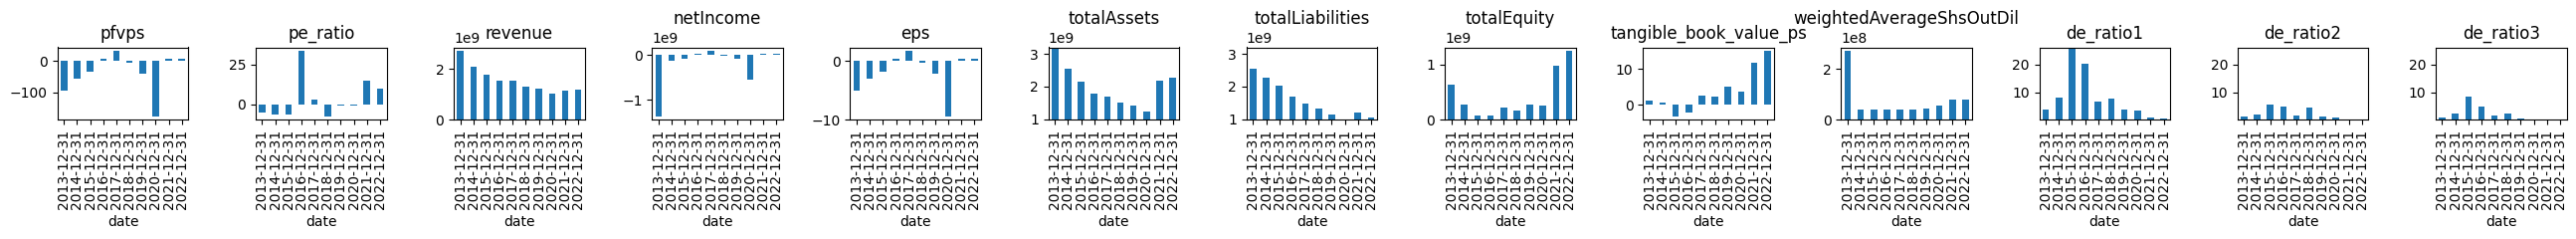

 31%|████████████████████████████████████                                                                               | 469/1495 [40:14<3:08:12, 11.01s/it]

length equals zero
less than 5 reports


 31%|████████████████████████████████████▏                                                                              | 470/1495 [40:17<2:26:00,  8.55s/it]

overvalued. price: 3.43, pfvps: 0.9497817604559996


 32%|████████████████████████████████████▏                                                                              | 471/1495 [40:28<2:38:15,  9.27s/it]

length equals zero
less than 5 reports


 32%|████████████████████████████████████▎                                                                              | 472/1495 [40:31<2:06:25,  7.41s/it]

overvalued. price: 41.74, pfvps: 17.580390932321123


 32%|████████████████████████████████████▍                                                                              | 473/1495 [40:43<2:33:20,  9.00s/it]

overvalued. price: 0.42, pfvps: -0.17849356670504493


 32%|████████████████████████████████████▍                                                                              | 474/1495 [40:55<2:46:11,  9.77s/it]

only negative pe in history


 32%|████████████████████████████████████▌                                                                              | 475/1495 [41:05<2:47:32,  9.86s/it]

length equals zero
less than 5 reports


 32%|████████████████████████████████████▌                                                                              | 476/1495 [41:08<2:12:41,  7.81s/it]

length equals zero
less than 5 reports


 32%|████████████████████████████████████▋                                                                              | 477/1495 [41:11<1:48:24,  6.39s/it]

length equals zero
less than 5 reports


 32%|████████████████████████████████████▊                                                                              | 478/1495 [41:14<1:28:11,  5.20s/it]

negative growth


 32%|████████████████████████████████████▊                                                                              | 479/1495 [41:16<1:13:41,  4.35s/it]

III.	 Current price: 4.38.	 Faire price: 4.417184696281003


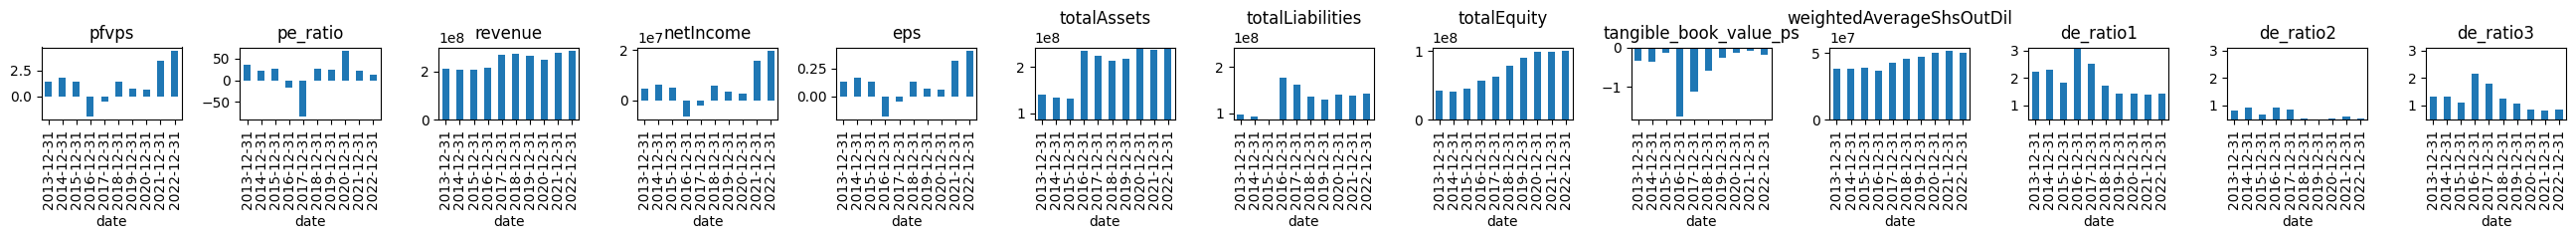

 32%|████████████████████████████████████▉                                                                              | 480/1495 [41:38<2:42:17,  9.59s/it]

overvalued. price: 0.87, pfvps: -0.061632751235996784


 32%|█████████████████████████████████████                                                                              | 481/1495 [41:44<2:27:10,  8.71s/it]

less than 5 reports


 32%|█████████████████████████████████████                                                                              | 482/1495 [41:47<1:54:59,  6.81s/it]

overvalued. price: 0.37, pfvps: 0.11300471094014969


 32%|█████████████████████████████████████▏                                                                             | 483/1495 [41:59<2:19:46,  8.29s/it]

length equals zero
less than 5 reports


 32%|█████████████████████████████████████▏                                                                             | 484/1495 [42:01<1:51:11,  6.60s/it]

negative growth


 32%|█████████████████████████████████████▎                                                                             | 485/1495 [42:05<1:35:00,  5.64s/it]

length equals zero
less than 5 reports


 33%|█████████████████████████████████████▍                                                                             | 486/1495 [42:08<1:21:08,  4.82s/it]

negative growth


 33%|█████████████████████████████████████▍                                                                             | 487/1495 [42:10<1:09:28,  4.14s/it]

length equals zero
less than 5 reports


 33%|█████████████████████████████████████▌                                                                             | 488/1495 [42:13<1:03:16,  3.77s/it]

length equals zero
less than 5 reports


 33%|██████████████████████████████████████▎                                                                              | 489/1495 [42:15<56:19,  3.36s/it]

length equals zero
less than 5 reports


 33%|██████████████████████████████████████▎                                                                              | 490/1495 [42:18<53:07,  3.17s/it]

only negative pe in history


 33%|█████████████████████████████████████▊                                                                             | 491/1495 [42:28<1:28:16,  5.28s/it]

length equals zero
less than 5 reports


 33%|█████████████████████████████████████▊                                                                             | 492/1495 [42:31<1:13:50,  4.42s/it]

only negative pe in history


 33%|█████████████████████████████████████▉                                                                             | 493/1495 [42:37<1:20:37,  4.83s/it]

length equals zero
less than 5 reports


 33%|██████████████████████████████████████                                                                             | 494/1495 [42:39<1:09:14,  4.15s/it]

negative growth


 33%|██████████████████████████████████████                                                                             | 495/1495 [42:42<1:03:33,  3.81s/it]

length equals zero
less than 5 reports


 33%|██████████████████████████████████████▊                                                                              | 496/1495 [42:45<56:35,  3.40s/it]

length equals zero
less than 5 reports


 33%|██████████████████████████████████████▉                                                                              | 497/1495 [42:47<51:58,  3.12s/it]

negative growth


 33%|██████████████████████████████████████▉                                                                              | 498/1495 [42:50<51:08,  3.08s/it]

negative growth


 33%|███████████████████████████████████████                                                                              | 499/1495 [42:53<49:27,  2.98s/it]

length equals zero
less than 5 reports


 33%|███████████████████████████████████████▏                                                                             | 500/1495 [42:56<48:55,  2.95s/it]

length equals zero
less than 5 reports


 34%|███████████████████████████████████████▏                                                                             | 501/1495 [42:58<46:34,  2.81s/it]

length equals zero
less than 5 reports


 34%|███████████████████████████████████████▎                                                                             | 502/1495 [43:01<47:38,  2.88s/it]

length equals zero
less than 5 reports


 34%|███████████████████████████████████████▎                                                                             | 503/1495 [43:04<47:05,  2.85s/it]

overvalued. price: 28.9, pfvps: 10.63537280618212


 34%|██████████████████████████████████████▊                                                                            | 504/1495 [43:15<1:28:20,  5.35s/it]

length equals zero
less than 5 reports


 34%|██████████████████████████████████████▊                                                                            | 505/1495 [43:18<1:17:19,  4.69s/it]

length equals zero
less than 5 reports


 34%|██████████████████████████████████████▉                                                                            | 506/1495 [43:22<1:10:04,  4.25s/it]

length equals zero
less than 5 reports


 34%|███████████████████████████████████████                                                                            | 507/1495 [43:24<1:01:18,  3.72s/it]

less than 5 reports


 34%|███████████████████████████████████████▊                                                                             | 508/1495 [43:26<54:46,  3.33s/it]

negative growth


 34%|███████████████████████████████████████▊                                                                             | 509/1495 [43:29<50:19,  3.06s/it]

length equals zero
less than 5 reports


 34%|███████████████████████████████████████▉                                                                             | 510/1495 [43:32<49:28,  3.01s/it]

length equals zero
less than 5 reports


 34%|███████████████████████████████████████▉                                                                             | 511/1495 [43:35<49:23,  3.01s/it]

length equals zero
less than 5 reports


 34%|████████████████████████████████████████                                                                             | 512/1495 [43:37<46:34,  2.84s/it]

only negative pe in history


 34%|███████████████████████████████████████▍                                                                           | 513/1495 [43:48<1:23:54,  5.13s/it]

less than 5 reports


 34%|███████████████████████████████████████▌                                                                           | 514/1495 [43:51<1:14:45,  4.57s/it]

less than 5 reports


 34%|███████████████████████████████████████▌                                                                           | 515/1495 [43:53<1:03:55,  3.91s/it]

only negative pe in history


 35%|███████████████████████████████████████▋                                                                           | 516/1495 [44:03<1:30:05,  5.52s/it]

length equals zero
less than 5 reports


 35%|███████████████████████████████████████▊                                                                           | 517/1495 [44:05<1:15:07,  4.61s/it]

overvalued. price: 5.22, pfvps: 0.4456208321173142


 35%|███████████████████████████████████████▊                                                                           | 518/1495 [44:17<1:50:30,  6.79s/it]

negative growth


 35%|███████████████████████████████████████▉                                                                           | 519/1495 [44:20<1:31:29,  5.62s/it]

length equals zero
less than 5 reports


 35%|████████████████████████████████████████                                                                           | 520/1495 [44:23<1:18:47,  4.85s/it]

negative growth


 35%|████████████████████████████████████████                                                                           | 521/1495 [44:25<1:06:38,  4.10s/it]

MYE.	 Current price: 17.93.	 Faire price: 23.4422682928793


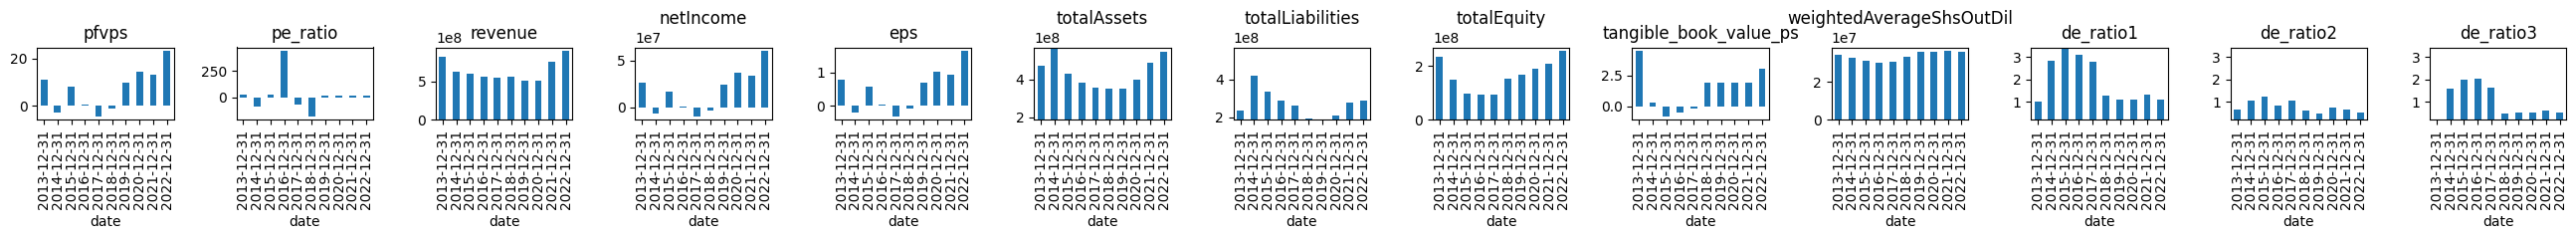

 35%|████████████████████████████████████████▏                                                                          | 522/1495 [44:44<2:15:53,  8.38s/it]

length equals zero
less than 5 reports


 35%|████████████████████████████████████████▏                                                                          | 523/1495 [44:46<1:46:55,  6.60s/it]

length equals zero
less than 5 reports


 35%|████████████████████████████████████████▎                                                                          | 524/1495 [44:49<1:29:32,  5.53s/it]

length equals zero
less than 5 reports


 35%|████████████████████████████████████████▍                                                                          | 525/1495 [44:52<1:14:15,  4.59s/it]

overvalued. price: 8.18, pfvps: 6.832755400069777


 35%|████████████████████████████████████████▍                                                                          | 526/1495 [45:02<1:43:54,  6.43s/it]

length equals zero
less than 5 reports


 35%|████████████████████████████████████████▌                                                                          | 527/1495 [45:05<1:25:55,  5.33s/it]

length equals zero
less than 5 reports


 35%|████████████████████████████████████████▌                                                                          | 528/1495 [45:08<1:12:27,  4.50s/it]

less than 5 reports


 35%|████████████████████████████████████████▋                                                                          | 529/1495 [45:10<1:04:32,  4.01s/it]

length equals zero
less than 5 reports


 35%|█████████████████████████████████████████▍                                                                           | 530/1495 [45:13<57:10,  3.55s/it]

only negative pe in history


 36%|████████████████████████████████████████▊                                                                          | 531/1495 [45:24<1:34:01,  5.85s/it]

only negative pe in history


 36%|████████████████████████████████████████▉                                                                          | 532/1495 [45:32<1:44:22,  6.50s/it]

length equals zero
less than 5 reports


 36%|█████████████████████████████████████████                                                                          | 533/1495 [45:35<1:24:36,  5.28s/it]

overvalued. price: 0.0065, pfvps: -0.5799410434228316


 36%|█████████████████████████████████████████                                                                          | 534/1495 [45:43<1:41:44,  6.35s/it]

overvalued. price: 61.75, pfvps: 6.260330423073175


 36%|█████████████████████████████████████████▏                                                                         | 535/1495 [45:56<2:09:15,  8.08s/it]

overvalued. price: 171.45, pfvps: -0.09023903624065163


 36%|█████████████████████████████████████████▏                                                                         | 536/1495 [46:06<2:22:21,  8.91s/it]

length equals zero
less than 5 reports


 36%|█████████████████████████████████████████▎                                                                         | 537/1495 [46:09<1:51:05,  6.96s/it]

negative growth


 36%|█████████████████████████████████████████▍                                                                         | 538/1495 [46:12<1:32:13,  5.78s/it]

only negative pe in history


 36%|█████████████████████████████████████████▍                                                                         | 539/1495 [46:20<1:42:15,  6.42s/it]

length equals zero
less than 5 reports


 36%|█████████████████████████████████████████▌                                                                         | 540/1495 [46:22<1:23:05,  5.22s/it]

length equals zero
less than 5 reports


 36%|█████████████████████████████████████████▌                                                                         | 541/1495 [46:25<1:09:29,  4.37s/it]

length equals zero
less than 5 reports


 36%|█████████████████████████████████████████▋                                                                         | 542/1495 [46:27<1:00:34,  3.81s/it]

less than 5 reports


 36%|██████████████████████████████████████████▍                                                                          | 543/1495 [46:29<53:40,  3.38s/it]

overvalued. price: 28.05, pfvps: 26.776604745575675


 36%|█████████████████████████████████████████▊                                                                         | 544/1495 [46:39<1:24:14,  5.31s/it]

only negative pe in history


 36%|█████████████████████████████████████████▉                                                                         | 545/1495 [46:46<1:28:59,  5.62s/it]

negative growth


 37%|██████████████████████████████████████████                                                                         | 546/1495 [46:48<1:13:28,  4.64s/it]

negative growth


 37%|██████████████████████████████████████████                                                                         | 547/1495 [46:50<1:02:44,  3.97s/it]

less than 5 reports


 37%|██████████████████████████████████████████▉                                                                          | 548/1495 [46:53<57:28,  3.64s/it]

overvalued. price: 5.11, pfvps: -20.74666599528719


 37%|██████████████████████████████████████████▏                                                                        | 549/1495 [47:03<1:27:05,  5.52s/it]

length equals zero
less than 5 reports


 37%|██████████████████████████████████████████▎                                                                        | 550/1495 [47:06<1:12:19,  4.59s/it]

only negative pe in history


 37%|██████████████████████████████████████████▍                                                                        | 551/1495 [47:12<1:19:26,  5.05s/it]

overvalued. price: 56.58, pfvps: 38.13966965126322


 37%|██████████████████████████████████████████▍                                                                        | 552/1495 [47:23<1:46:55,  6.80s/it]

length equals zero
less than 5 reports


 37%|██████████████████████████████████████████▌                                                                        | 553/1495 [47:26<1:29:56,  5.73s/it]

negative growth


 37%|██████████████████████████████████████████▌                                                                        | 554/1495 [47:28<1:14:05,  4.72s/it]

length equals zero
less than 5 reports


 37%|██████████████████████████████████████████▋                                                                        | 555/1495 [47:31<1:05:39,  4.19s/it]

length equals zero
less than 5 reports


 37%|███████████████████████████████████████████▌                                                                         | 556/1495 [47:34<57:25,  3.67s/it]

length equals zero
less than 5 reports


 37%|███████████████████████████████████████████▌                                                                         | 557/1495 [47:36<53:17,  3.41s/it]

length equals zero
less than 5 reports


 37%|███████████████████████████████████████████▋                                                                         | 558/1495 [47:39<50:33,  3.24s/it]

IPI.	 Current price: 25.16.	 Faire price: 58.95898502696071


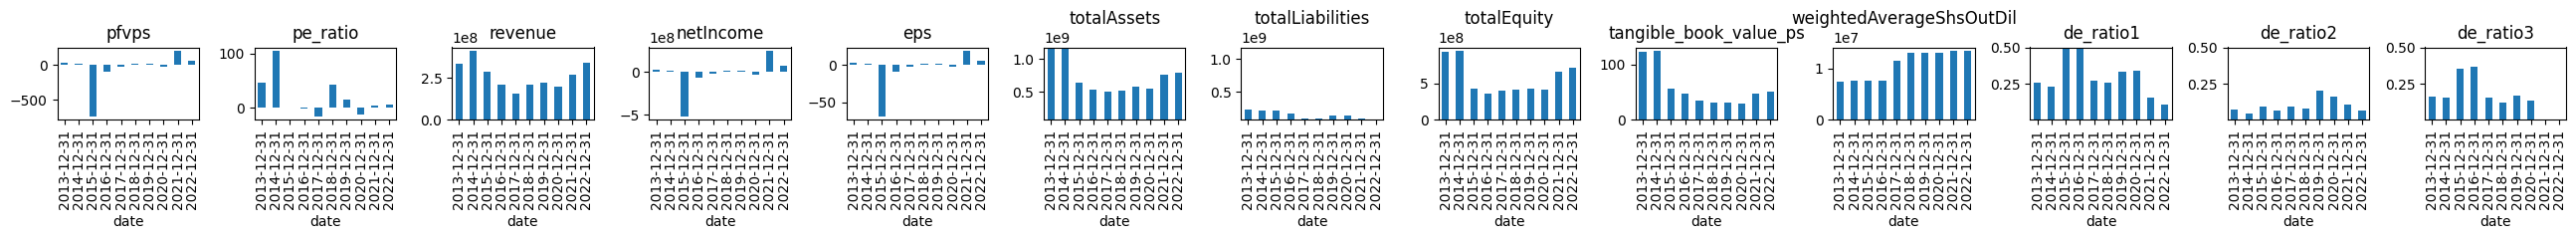

 37%|███████████████████████████████████████████                                                                        | 559/1495 [47:59<2:06:21,  8.10s/it]

length equals zero
less than 5 reports


 37%|███████████████████████████████████████████                                                                        | 560/1495 [48:01<1:39:40,  6.40s/it]

length equals zero
less than 5 reports


 38%|███████████████████████████████████████████▏                                                                       | 561/1495 [48:04<1:23:12,  5.34s/it]

only negative pe in history


 38%|███████████████████████████████████████████▏                                                                       | 562/1495 [48:15<1:50:27,  7.10s/it]

only negative pe in history


 38%|███████████████████████████████████████████▎                                                                       | 563/1495 [48:24<2:00:19,  7.75s/it]

length equals zero
less than 5 reports


 38%|███████████████████████████████████████████▍                                                                       | 564/1495 [48:27<1:35:22,  6.15s/it]

negative growth


 38%|███████████████████████████████████████████▍                                                                       | 565/1495 [48:29<1:18:30,  5.07s/it]

length equals zero
less than 5 reports


 38%|███████████████████████████████████████████▌                                                                       | 566/1495 [48:32<1:06:03,  4.27s/it]

length equals zero
less than 5 reports


 38%|████████████████████████████████████████████▎                                                                        | 567/1495 [48:35<59:35,  3.85s/it]

less than 5 reports


 38%|████████████████████████████████████████████▍                                                                        | 568/1495 [48:37<52:47,  3.42s/it]

length equals zero
less than 5 reports


 38%|████████████████████████████████████████████▌                                                                        | 569/1495 [48:40<48:44,  3.16s/it]

overvalued. price: 0.72, pfvps: 0.22958328368219605


 38%|███████████████████████████████████████████▊                                                                       | 570/1495 [48:50<1:21:38,  5.30s/it]

only negative pe in history


 38%|███████████████████████████████████████████▉                                                                       | 571/1495 [49:00<1:45:27,  6.85s/it]

less than 5 reports


 38%|████████████████████████████████████████████                                                                       | 572/1495 [49:03<1:24:45,  5.51s/it]

overvalued. price: 3.28, pfvps: -1.077747868845878


 38%|████████████████████████████████████████████                                                                       | 573/1495 [49:13<1:45:09,  6.84s/it]

only negative pe in history


 38%|████████████████████████████████████████████▏                                                                      | 574/1495 [49:22<1:56:14,  7.57s/it]

negative growth


 38%|████████████████████████████████████████████▏                                                                      | 575/1495 [49:24<1:32:10,  6.01s/it]

length equals zero
less than 5 reports


 39%|████████████████████████████████████████████▎                                                                      | 576/1495 [49:27<1:15:39,  4.94s/it]

less than 5 reports


 39%|████████████████████████████████████████████▍                                                                      | 577/1495 [49:29<1:03:46,  4.17s/it]

overvalued. price: 68.07, pfvps: 22.9983518638686


 39%|████████████████████████████████████████████▍                                                                      | 578/1495 [49:39<1:30:21,  5.91s/it]

length equals zero
less than 5 reports


 39%|████████████████████████████████████████████▌                                                                      | 579/1495 [49:42<1:15:55,  4.97s/it]

length equals zero
less than 5 reports


 39%|████████████████████████████████████████████▌                                                                      | 580/1495 [49:44<1:04:13,  4.21s/it]

only negative pe in history


 39%|████████████████████████████████████████████▋                                                                      | 581/1495 [49:54<1:31:07,  5.98s/it]

less than 5 reports


 39%|████████████████████████████████████████████▊                                                                      | 582/1495 [49:57<1:14:39,  4.91s/it]

less than 5 reports


 39%|████████████████████████████████████████████▊                                                                      | 583/1495 [49:59<1:02:56,  4.14s/it]

less than 5 reports


 39%|█████████████████████████████████████████████▋                                                                       | 584/1495 [50:02<54:42,  3.60s/it]

length equals zero
less than 5 reports


 39%|█████████████████████████████████████████████▊                                                                       | 585/1495 [50:04<49:21,  3.25s/it]

length equals zero
less than 5 reports


 39%|█████████████████████████████████████████████▊                                                                       | 586/1495 [50:06<45:42,  3.02s/it]

length equals zero
less than 5 reports


 39%|█████████████████████████████████████████████▉                                                                       | 587/1495 [50:09<43:40,  2.89s/it]

length equals zero
less than 5 reports


 39%|██████████████████████████████████████████████                                                                       | 588/1495 [50:11<41:28,  2.74s/it]

overvalued. price: 25.58, pfvps: 0.548776841601642


 39%|█████████████████████████████████████████████▎                                                                     | 589/1495 [50:24<1:24:56,  5.63s/it]

less than 5 reports


 39%|█████████████████████████████████████████████▍                                                                     | 590/1495 [50:26<1:10:12,  4.65s/it]

negative growth


 40%|█████████████████████████████████████████████▍                                                                     | 591/1495 [50:29<1:00:13,  4.00s/it]

negative growth


 40%|██████████████████████████████████████████████▎                                                                      | 592/1495 [50:32<54:57,  3.65s/it]

length equals zero
less than 5 reports


 40%|██████████████████████████████████████████████▍                                                                      | 593/1495 [50:34<49:29,  3.29s/it]

only negative pe in history


 40%|█████████████████████████████████████████████▋                                                                     | 594/1495 [50:41<1:06:46,  4.45s/it]

negative growth


 40%|██████████████████████████████████████████████▌                                                                      | 595/1495 [50:44<58:37,  3.91s/it]

length equals zero
less than 5 reports


 40%|██████████████████████████████████████████████▋                                                                      | 596/1495 [50:47<55:17,  3.69s/it]

negative growth


 40%|██████████████████████████████████████████████▋                                                                      | 597/1495 [50:49<49:22,  3.30s/it]

length equals zero
less than 5 reports


 40%|██████████████████████████████████████████████▊                                                                      | 598/1495 [50:52<47:31,  3.18s/it]

length equals zero
less than 5 reports


 40%|██████████████████████████████████████████████▉                                                                      | 599/1495 [50:55<45:20,  3.04s/it]

negative growth


 40%|██████████████████████████████████████████████▉                                                                      | 600/1495 [50:58<45:28,  3.05s/it]

length equals zero
less than 5 reports


 40%|███████████████████████████████████████████████                                                                      | 601/1495 [51:00<42:41,  2.86s/it]

length equals zero
less than 5 reports


 40%|███████████████████████████████████████████████                                                                      | 602/1495 [51:03<40:46,  2.74s/it]

overvalued. price: 8.99, pfvps: 1.5466453073989646


 40%|██████████████████████████████████████████████▍                                                                    | 603/1495 [51:13<1:12:30,  4.88s/it]

overvalued. price: 31.73, pfvps: 7.53718800932609


 40%|██████████████████████████████████████████████▍                                                                    | 604/1495 [51:23<1:36:05,  6.47s/it]

length equals zero
less than 5 reports


 40%|██████████████████████████████████████████████▌                                                                    | 605/1495 [51:25<1:17:59,  5.26s/it]

overvalued. price: 2.02, pfvps: -0.03313114778563481


 41%|██████████████████████████████████████████████▌                                                                    | 606/1495 [51:36<1:40:56,  6.81s/it]

length equals zero
less than 5 reports


 41%|██████████████████████████████████████████████▋                                                                    | 607/1495 [51:38<1:21:35,  5.51s/it]

less than 5 reports


 41%|██████████████████████████████████████████████▊                                                                    | 608/1495 [51:41<1:08:16,  4.62s/it]

length equals zero
less than 5 reports


 41%|██████████████████████████████████████████████▊                                                                    | 609/1495 [51:44<1:00:36,  4.10s/it]

length equals zero
less than 5 reports


 41%|███████████████████████████████████████████████▋                                                                     | 610/1495 [51:47<55:15,  3.75s/it]

TGH.	 Current price: 37.25.	 Faire price: 41.26729857862528


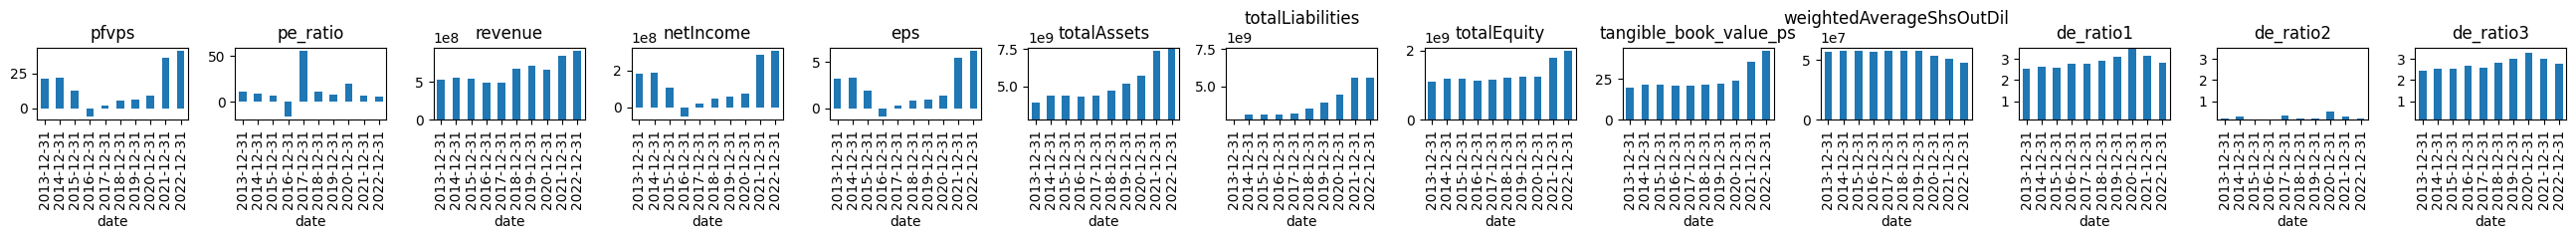

 41%|███████████████████████████████████████████████                                                                    | 611/1495 [52:05<2:00:25,  8.17s/it]

length equals zero
less than 5 reports


 41%|███████████████████████████████████████████████                                                                    | 612/1495 [52:08<1:35:00,  6.46s/it]

length equals zero
less than 5 reports


 41%|███████████████████████████████████████████████▏                                                                   | 613/1495 [52:10<1:17:00,  5.24s/it]

length equals zero
less than 5 reports


 41%|███████████████████████████████████████████████▏                                                                   | 614/1495 [52:12<1:04:32,  4.40s/it]

negative growth


 41%|████████████████████████████████████████████████▏                                                                    | 615/1495 [52:15<55:37,  3.79s/it]

overvalued. price: 1.01, pfvps: 0.10987672762316535


 41%|███████████████████████████████████████████████▍                                                                   | 616/1495 [52:25<1:22:35,  5.64s/it]

length equals zero
less than 5 reports


 41%|███████████████████████████████████████████████▍                                                                   | 617/1495 [52:27<1:08:28,  4.68s/it]

less than 5 reports


 41%|████████████████████████████████████████████████▎                                                                    | 618/1495 [52:30<58:24,  4.00s/it]

length equals zero
less than 5 reports


 41%|████████████████████████████████████████████████▍                                                                    | 619/1495 [52:32<51:24,  3.52s/it]

length equals zero
less than 5 reports


 41%|████████████████████████████████████████████████▌                                                                    | 620/1495 [52:34<46:23,  3.18s/it]

negative growth


 42%|████████████████████████████████████████████████▌                                                                    | 621/1495 [52:37<43:44,  3.00s/it]

overvalued. price: 0.729, pfvps: 0.0593073904469579


 42%|███████████████████████████████████████████████▊                                                                   | 622/1495 [52:48<1:17:26,  5.32s/it]

length equals zero
less than 5 reports


 42%|███████████████████████████████████████████████▉                                                                   | 623/1495 [52:50<1:06:02,  4.54s/it]

length equals zero
less than 5 reports


 42%|████████████████████████████████████████████████▊                                                                    | 624/1495 [52:53<56:50,  3.92s/it]

overvalued. price: 2.25, pfvps: -0.7135402731134651


 42%|████████████████████████████████████████████████                                                                   | 625/1495 [53:03<1:23:58,  5.79s/it]

length equals zero
less than 5 reports


 42%|████████████████████████████████████████████████▏                                                                  | 626/1495 [53:06<1:11:57,  4.97s/it]

overvalued. price: 56.21, pfvps: 48.097688904725246


 42%|████████████████████████████████████████████████▏                                                                  | 627/1495 [53:17<1:36:58,  6.70s/it]

length equals zero
less than 5 reports


 42%|████████████████████████████████████████████████▎                                                                  | 628/1495 [53:20<1:21:06,  5.61s/it]

length equals zero
less than 5 reports


 42%|████████████████████████████████████████████████▍                                                                  | 629/1495 [53:23<1:09:08,  4.79s/it]

negative growth


 42%|█████████████████████████████████████████████████▎                                                                   | 630/1495 [53:25<58:35,  4.06s/it]

only negative pe in history


 42%|████████████████████████████████████████████████▌                                                                  | 631/1495 [53:32<1:10:08,  4.87s/it]

negative growth


 42%|████████████████████████████████████████████████▌                                                                  | 632/1495 [53:35<1:01:23,  4.27s/it]

less than 5 reports


 42%|█████████████████████████████████████████████████▌                                                                   | 633/1495 [53:37<53:05,  3.70s/it]

length equals zero
less than 5 reports


 42%|█████████████████████████████████████████████████▌                                                                   | 634/1495 [53:40<47:35,  3.32s/it]

less than 5 reports


 42%|█████████████████████████████████████████████████▋                                                                   | 635/1495 [53:42<43:21,  3.03s/it]

overvalued. price: 2.05, pfvps: 0.8928773301341525


 43%|████████████████████████████████████████████████▉                                                                  | 636/1495 [53:50<1:05:51,  4.60s/it]

length equals zero
less than 5 reports


 43%|█████████████████████████████████████████████████▊                                                                   | 637/1495 [53:53<58:58,  4.12s/it]

only negative pe in history


 43%|█████████████████████████████████████████████████                                                                  | 638/1495 [54:03<1:23:31,  5.85s/it]

overvalued. price: 24.47, pfvps: 13.266776096970842


 43%|█████████████████████████████████████████████████▏                                                                 | 639/1495 [54:14<1:44:45,  7.34s/it]

overvalued. price: 3.2, pfvps: -1.611551567156908


 43%|█████████████████████████████████████████████████▏                                                                 | 640/1495 [54:24<1:57:56,  8.28s/it]

negative growth


 43%|█████████████████████████████████████████████████▎                                                                 | 641/1495 [54:27<1:34:33,  6.64s/it]

less than 5 reports


 43%|█████████████████████████████████████████████████▍                                                                 | 642/1495 [54:30<1:16:12,  5.36s/it]

length equals zero
less than 5 reports


 43%|█████████████████████████████████████████████████▍                                                                 | 643/1495 [54:32<1:03:37,  4.48s/it]

length equals zero
less than 5 reports


 43%|██████████████████████████████████████████████████▍                                                                  | 644/1495 [54:35<57:40,  4.07s/it]

length equals zero
less than 5 reports


 43%|██████████████████████████████████████████████████▍                                                                  | 645/1495 [54:38<50:36,  3.57s/it]

less than 5 reports


 43%|██████████████████████████████████████████████████▌                                                                  | 646/1495 [54:40<47:43,  3.37s/it]

overvalued. price: 52.8, pfvps: 7.982740596885126


 43%|█████████████████████████████████████████████████▊                                                                 | 647/1495 [54:54<1:32:24,  6.54s/it]

length equals zero
less than 5 reports


 43%|█████████████████████████████████████████████████▊                                                                 | 648/1495 [54:57<1:16:23,  5.41s/it]

length equals zero
less than 5 reports


 43%|█████████████████████████████████████████████████▉                                                                 | 649/1495 [55:00<1:03:38,  4.51s/it]

length equals zero
less than 5 reports


 43%|██████████████████████████████████████████████████▊                                                                  | 650/1495 [55:02<55:36,  3.95s/it]

length equals zero
less than 5 reports


 44%|██████████████████████████████████████████████████▉                                                                  | 651/1495 [55:05<50:08,  3.56s/it]

length equals zero
less than 5 reports


 44%|███████████████████████████████████████████████████                                                                  | 652/1495 [55:08<46:56,  3.34s/it]

length equals zero
less than 5 reports


 44%|███████████████████████████████████████████████████                                                                  | 653/1495 [55:11<46:08,  3.29s/it]

overvalued. price: 15.17, pfvps: 8.13347265229766


 44%|██████████████████████████████████████████████████▎                                                                | 654/1495 [55:21<1:13:49,  5.27s/it]

length equals zero
less than 5 reports


 44%|██████████████████████████████████████████████████▍                                                                | 655/1495 [55:24<1:04:18,  4.59s/it]

length equals zero
less than 5 reports


 44%|███████████████████████████████████████████████████▎                                                                 | 656/1495 [55:26<55:02,  3.94s/it]

less than 5 reports


 44%|███████████████████████████████████████████████████▍                                                                 | 657/1495 [55:29<48:35,  3.48s/it]

negative growth


 44%|███████████████████████████████████████████████████▍                                                                 | 658/1495 [55:31<43:51,  3.14s/it]

length equals zero
less than 5 reports


 44%|███████████████████████████████████████████████████▌                                                                 | 659/1495 [55:33<40:50,  2.93s/it]

length equals zero
less than 5 reports


 44%|███████████████████████████████████████████████████▋                                                                 | 660/1495 [55:36<40:53,  2.94s/it]

negative growth


 44%|███████████████████████████████████████████████████▋                                                                 | 661/1495 [55:39<40:14,  2.90s/it]

overvalued. price: 0.022, pfvps: -0.4583151057686461


 44%|██████████████████████████████████████████████████▉                                                                | 662/1495 [55:49<1:09:24,  5.00s/it]

overvalued. price: 14.67, pfvps: -8.261243181534486


 44%|███████████████████████████████████████████████████                                                                | 663/1495 [56:01<1:39:52,  7.20s/it]

length equals zero
less than 5 reports


 44%|███████████████████████████████████████████████████                                                                | 664/1495 [56:04<1:20:01,  5.78s/it]

overvalued. price: 13.25, pfvps: 1.106088367650351


 44%|███████████████████████████████████████████████████▏                                                               | 665/1495 [56:14<1:36:48,  7.00s/it]

less than 5 reports


 45%|███████████████████████████████████████████████████▏                                                               | 666/1495 [56:17<1:20:13,  5.81s/it]

less than 5 reports


 45%|███████████████████████████████████████████████████▎                                                               | 667/1495 [56:19<1:05:50,  4.77s/it]

length equals zero
less than 5 reports


 45%|████████████████████████████████████████████████████▎                                                                | 668/1495 [56:21<55:54,  4.06s/it]

length equals zero
less than 5 reports


 45%|████████████████████████████████████████████████████▎                                                                | 669/1495 [56:24<51:40,  3.75s/it]

overvalued. price: 0.0164, pfvps: 0.001065900903317692


 45%|███████████████████████████████████████████████████▌                                                               | 670/1495 [56:35<1:17:31,  5.64s/it]

only negative pe in history


 45%|███████████████████████████████████████████████████▌                                                               | 671/1495 [56:44<1:33:20,  6.80s/it]

overvalued. price: None, pfvps: -4.727931711665941


 45%|███████████████████████████████████████████████████▋                                                               | 672/1495 [56:53<1:41:54,  7.43s/it]

length equals zero
less than 5 reports


 45%|███████████████████████████████████████████████████▊                                                               | 673/1495 [56:56<1:23:33,  6.10s/it]

length equals zero
less than 5 reports


 45%|███████████████████████████████████████████████████▊                                                               | 674/1495 [56:58<1:08:28,  5.00s/it]

length equals zero
less than 5 reports


 45%|████████████████████████████████████████████████████▊                                                                | 675/1495 [57:01<57:44,  4.22s/it]

length equals zero
less than 5 reports


 45%|████████████████████████████████████████████████████▉                                                                | 676/1495 [57:04<51:40,  3.79s/it]

only negative pe in history


 45%|████████████████████████████████████████████████████                                                               | 677/1495 [57:14<1:20:26,  5.90s/it]

overvalued. price: 16.15, pfvps: 0.0


 45%|████████████████████████████████████████████████████▏                                                              | 678/1495 [57:24<1:36:36,  7.09s/it]

overvalued. price: 0.085, pfvps: -0.12041270197700342


 45%|████████████████████████████████████████████████████▏                                                              | 679/1495 [57:34<1:48:32,  7.98s/it]

overvalued. price: 9.47, pfvps: 1.9069652131162682


 45%|████████████████████████████████████████████████████▎                                                              | 680/1495 [57:44<1:56:46,  8.60s/it]

length equals zero
less than 5 reports


 46%|████████████████████████████████████████████████████▍                                                              | 681/1495 [57:47<1:31:29,  6.74s/it]

length equals zero
less than 5 reports


 46%|████████████████████████████████████████████████████▍                                                              | 682/1495 [57:49<1:13:41,  5.44s/it]

negative growth


 46%|████████████████████████████████████████████████████▌                                                              | 683/1495 [57:52<1:04:30,  4.77s/it]

only negative pe in history


 46%|████████████████████████████████████████████████████▌                                                              | 684/1495 [58:02<1:26:16,  6.38s/it]

length equals zero
less than 5 reports


 46%|████████████████████████████████████████████████████▋                                                              | 685/1495 [58:05<1:10:57,  5.26s/it]

length equals zero
less than 5 reports


 46%|█████████████████████████████████████████████████████▋                                                               | 686/1495 [58:08<59:29,  4.41s/it]

length equals zero
less than 5 reports


 46%|█████████████████████████████████████████████████████▊                                                               | 687/1495 [58:10<51:53,  3.85s/it]

length equals zero
less than 5 reports


 46%|█████████████████████████████████████████████████████▊                                                               | 688/1495 [58:13<46:16,  3.44s/it]

overvalued. price: 3.24, pfvps: -9.116335547448763


 46%|█████████████████████████████████████████████████████                                                              | 689/1495 [58:23<1:12:25,  5.39s/it]

length equals zero
less than 5 reports


 46%|█████████████████████████████████████████████████████                                                              | 690/1495 [58:25<1:00:58,  4.54s/it]

length equals zero
less than 5 reports


 46%|██████████████████████████████████████████████████████                                                               | 691/1495 [58:28<52:19,  3.91s/it]

only negative pe in history


 46%|█████████████████████████████████████████████████████▏                                                             | 692/1495 [58:37<1:14:06,  5.54s/it]

length equals zero
less than 5 reports


 46%|█████████████████████████████████████████████████████▎                                                             | 693/1495 [58:39<1:01:50,  4.63s/it]

length equals zero
less than 5 reports


 46%|██████████████████████████████████████████████████████▎                                                              | 694/1495 [58:42<54:25,  4.08s/it]

length equals zero
less than 5 reports


 46%|██████████████████████████████████████████████████████▍                                                              | 695/1495 [58:45<47:44,  3.58s/it]

overvalued. price: 21.3, pfvps: 17.503952376950036


 47%|█████████████████████████████████████████████████████▌                                                             | 696/1495 [58:55<1:16:43,  5.76s/it]

overvalued. price: None, pfvps: 55.5098255549036


 47%|█████████████████████████████████████████████████████▌                                                             | 697/1495 [59:05<1:33:04,  7.00s/it]

length equals zero
less than 5 reports


 47%|█████████████████████████████████████████████████████▋                                                             | 698/1495 [59:08<1:14:37,  5.62s/it]

overvalued. price: 1.89, pfvps: -30.59573331047096


 47%|█████████████████████████████████████████████████████▊                                                             | 699/1495 [59:14<1:17:42,  5.86s/it]

overvalued. price: 3.035, pfvps: 1.690229965719883


 47%|█████████████████████████████████████████████████████▊                                                             | 700/1495 [59:24<1:35:24,  7.20s/it]

overvalued. price: 4.9, pfvps: 0.0


 47%|█████████████████████████████████████████████████████▉                                                             | 701/1495 [59:31<1:32:18,  6.98s/it]

length equals zero
less than 5 reports


 47%|██████████████████████████████████████████████████████                                                             | 702/1495 [59:33<1:14:10,  5.61s/it]

overvalued. price: 18.19, pfvps: -8.20929056603914


 47%|██████████████████████████████████████████████████████                                                             | 703/1495 [59:43<1:31:15,  6.91s/it]

length equals zero
less than 5 reports


 47%|██████████████████████████████████████████████████████▏                                                            | 704/1495 [59:46<1:15:41,  5.74s/it]

overvalued. price: 0.2096, pfvps: -187.74995906610138


 47%|██████████████████████████████████████████████████████▏                                                            | 705/1495 [59:57<1:35:17,  7.24s/it]

length equals zero
less than 5 reports


 47%|██████████████████████████████████████████████████████▎                                                            | 706/1495 [59:59<1:16:05,  5.79s/it]

length equals zero
less than 5 reports


 47%|█████████████████████████████████████████████████████▍                                                           | 707/1495 [1:00:02<1:02:41,  4.77s/it]

length equals zero
less than 5 reports


 47%|██████████████████████████████████████████████████████▍                                                            | 708/1495 [1:00:04<53:14,  4.06s/it]

overvalued. price: 1.91, pfvps: 0.0


 47%|█████████████████████████████████████████████████████▌                                                           | 709/1495 [1:00:12<1:05:54,  5.03s/it]

overvalued. price: 0.06, pfvps: 0.0


 47%|█████████████████████████████████████████████████████▋                                                           | 710/1495 [1:00:18<1:11:49,  5.49s/it]

overvalued. price: 0.1595, pfvps: -1.250978369138936


 48%|█████████████████████████████████████████████████████▋                                                           | 711/1495 [1:00:28<1:28:51,  6.80s/it]

length equals zero
less than 5 reports


 48%|█████████████████████████████████████████████████████▊                                                           | 712/1495 [1:00:30<1:11:48,  5.50s/it]

length equals zero
less than 5 reports


 48%|██████████████████████████████████████████████████████▊                                                            | 713/1495 [1:00:33<59:40,  4.58s/it]

length equals zero
less than 5 reports


 48%|██████████████████████████████████████████████████████▉                                                            | 714/1495 [1:00:35<51:11,  3.93s/it]

length equals zero
less than 5 reports


 48%|███████████████████████████████████████████████████████                                                            | 715/1495 [1:00:38<45:16,  3.48s/it]

less than 5 reports


 48%|███████████████████████████████████████████████████████                                                            | 716/1495 [1:00:40<40:54,  3.15s/it]

less than 5 reports


 48%|███████████████████████████████████████████████████████▏                                                           | 717/1495 [1:00:42<37:48,  2.92s/it]

length equals zero
less than 5 reports


 48%|███████████████████████████████████████████████████████▏                                                           | 718/1495 [1:00:45<35:56,  2.77s/it]

overvalued. price: 17.5, pfvps: 4.3088940500987984


 48%|██████████████████████████████████████████████████████▎                                                          | 719/1495 [1:00:55<1:03:25,  4.90s/it]

only negative pe in history


 48%|██████████████████████████████████████████████████████▍                                                          | 720/1495 [1:01:05<1:25:16,  6.60s/it]

overvalued. price: 20.43, pfvps: -15.907578184007189


 48%|██████████████████████████████████████████████████████▍                                                          | 721/1495 [1:01:15<1:38:33,  7.64s/it]

overvalued. price: 19.0099, pfvps: 2.2365948679693015


 48%|██████████████████████████████████████████████████████▌                                                          | 722/1495 [1:01:26<1:48:47,  8.44s/it]

overvalued. price: 3.81, pfvps: -0.496512191247366


 48%|██████████████████████████████████████████████████████▋                                                          | 723/1495 [1:01:36<1:54:05,  8.87s/it]

overvalued. price: 32.37, pfvps: 16.944535873754408


 48%|██████████████████████████████████████████████████████▋                                                          | 724/1495 [1:01:45<1:57:35,  9.15s/it]

overvalued. price: 0.618, pfvps: 0.41512485206069555


 48%|██████████████████████████████████████████████████████▊                                                          | 725/1495 [1:01:56<2:02:11,  9.52s/it]

length equals zero
less than 5 reports


 49%|██████████████████████████████████████████████████████▊                                                          | 726/1495 [1:01:58<1:34:40,  7.39s/it]

less than 5 reports


 49%|██████████████████████████████████████████████████████▉                                                          | 727/1495 [1:02:01<1:15:18,  5.88s/it]

overvalued. price: 12.5, pfvps: 2.5461463168606753


 49%|███████████████████████████████████████████████████████                                                          | 728/1495 [1:02:11<1:31:15,  7.14s/it]

less than 5 reports


 49%|███████████████████████████████████████████████████████                                                          | 729/1495 [1:02:13<1:13:11,  5.73s/it]

only negative pe in history


 49%|███████████████████████████████████████████████████████▏                                                         | 730/1495 [1:02:19<1:15:42,  5.94s/it]

overvalued. price: 1.07, pfvps: -26.87690325037214


 49%|███████████████████████████████████████████████████████▎                                                         | 731/1495 [1:02:27<1:20:25,  6.32s/it]

less than 5 reports


 49%|███████████████████████████████████████████████████████▎                                                         | 732/1495 [1:02:29<1:05:50,  5.18s/it]

less than 5 reports


 49%|████████████████████████████████████████████████████████▍                                                          | 733/1495 [1:02:32<55:08,  4.34s/it]

length equals zero
less than 5 reports


 49%|████████████████████████████████████████████████████████▍                                                          | 734/1495 [1:02:34<47:45,  3.77s/it]

length equals zero
less than 5 reports


 49%|████████████████████████████████████████████████████████▌                                                          | 735/1495 [1:02:37<43:04,  3.40s/it]

length equals zero
less than 5 reports


 49%|████████████████████████████████████████████████████████▌                                                          | 736/1495 [1:02:39<39:18,  3.11s/it]

CVLG.	 Current price: 43.85.	 Faire price: 50.32063881148805


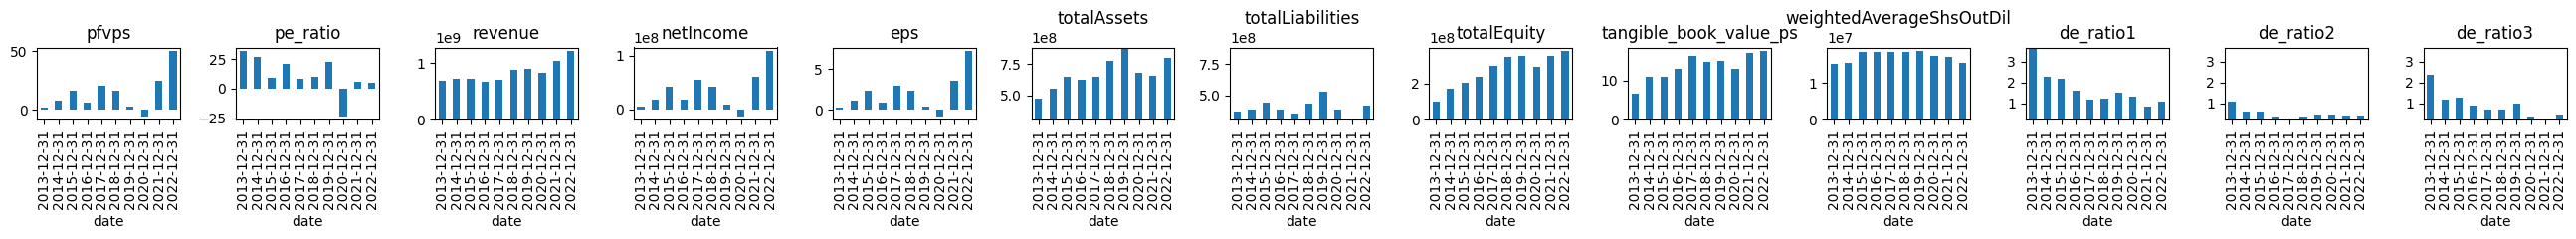

 49%|███████████████████████████████████████████████████████▋                                                         | 737/1495 [1:02:58<1:38:22,  7.79s/it]

length equals zero
less than 5 reports


 49%|███████████████████████████████████████████████████████▊                                                         | 738/1495 [1:03:01<1:19:32,  6.30s/it]

less than 5 reports


 49%|███████████████████████████████████████████████████████▊                                                         | 739/1495 [1:03:03<1:04:32,  5.12s/it]

length equals zero
less than 5 reports


 49%|████████████████████████████████████████████████████████▉                                                          | 740/1495 [1:03:05<54:17,  4.31s/it]

only negative pe in history


 50%|████████████████████████████████████████████████████████                                                         | 741/1495 [1:03:15<1:16:13,  6.07s/it]

overvalued. price: 13.12, pfvps: -4.7515030934085845


 50%|████████████████████████████████████████████████████████                                                         | 742/1495 [1:03:25<1:30:29,  7.21s/it]

negative growth


 50%|████████████████████████████████████████████████████████▏                                                        | 743/1495 [1:03:28<1:12:08,  5.76s/it]

overvalued. price: 3.11, pfvps: -6.308093104991388


 50%|████████████████████████████████████████████████████████▏                                                        | 744/1495 [1:03:38<1:29:23,  7.14s/it]

length equals zero
less than 5 reports


 50%|████████████████████████████████████████████████████████▎                                                        | 745/1495 [1:03:41<1:11:32,  5.72s/it]

length equals zero
less than 5 reports


 50%|█████████████████████████████████████████████████████████▍                                                         | 746/1495 [1:03:43<59:02,  4.73s/it]

length equals zero
less than 5 reports


 50%|█████████████████████████████████████████████████████████▍                                                         | 747/1495 [1:03:45<50:20,  4.04s/it]

negative growth


 50%|█████████████████████████████████████████████████████████▌                                                         | 748/1495 [1:03:48<44:12,  3.55s/it]

length equals zero
less than 5 reports


 50%|█████████████████████████████████████████████████████████▌                                                         | 749/1495 [1:03:50<39:58,  3.22s/it]

length equals zero
less than 5 reports


 50%|█████████████████████████████████████████████████████████▋                                                         | 750/1495 [1:03:53<36:50,  2.97s/it]

overvalued. price: 19.83, pfvps: 0.0


 50%|█████████████████████████████████████████████████████████▊                                                         | 751/1495 [1:04:00<52:12,  4.21s/it]

less than 5 reports


 50%|█████████████████████████████████████████████████████████▊                                                         | 752/1495 [1:04:02<45:17,  3.66s/it]

negative growth


 50%|█████████████████████████████████████████████████████████▉                                                         | 753/1495 [1:04:05<42:24,  3.43s/it]

length equals zero
less than 5 reports


 50%|██████████████████████████████████████████████████████████                                                         | 754/1495 [1:04:07<38:30,  3.12s/it]

length equals zero
less than 5 reports


 51%|██████████████████████████████████████████████████████████                                                         | 755/1495 [1:04:10<35:56,  2.91s/it]

negative growth


 51%|██████████████████████████████████████████████████████████▏                                                        | 756/1495 [1:04:12<33:53,  2.75s/it]

length equals zero
less than 5 reports


 51%|██████████████████████████████████████████████████████████▏                                                        | 757/1495 [1:04:15<32:44,  2.66s/it]

length equals zero
less than 5 reports


 51%|██████████████████████████████████████████████████████████▎                                                        | 758/1495 [1:04:17<31:51,  2.59s/it]

length equals zero
less than 5 reports


 51%|██████████████████████████████████████████████████████████▍                                                        | 759/1495 [1:04:20<33:04,  2.70s/it]

length equals zero
less than 5 reports


 51%|██████████████████████████████████████████████████████████▍                                                        | 760/1495 [1:04:23<33:15,  2.72s/it]

length equals zero
less than 5 reports


 51%|██████████████████████████████████████████████████████████▌                                                        | 761/1495 [1:04:25<32:14,  2.64s/it]

less than 5 reports


 51%|██████████████████████████████████████████████████████████▌                                                        | 762/1495 [1:04:28<31:12,  2.55s/it]

only negative pe in history


 51%|██████████████████████████████████████████████████████████▋                                                        | 763/1495 [1:04:33<42:54,  3.52s/it]

overvalued. price: 100.1, pfvps: 85.46958471987602


 51%|█████████████████████████████████████████████████████████▋                                                       | 764/1495 [1:04:44<1:08:04,  5.59s/it]

less than 5 reports


 51%|██████████████████████████████████████████████████████████▊                                                        | 765/1495 [1:04:46<56:10,  4.62s/it]

less than 5 reports


 51%|██████████████████████████████████████████████████████████▉                                                        | 766/1495 [1:04:48<47:50,  3.94s/it]

length equals zero
less than 5 reports


 51%|███████████████████████████████████████████████████████████                                                        | 767/1495 [1:04:51<42:11,  3.48s/it]

negative growth


 51%|███████████████████████████████████████████████████████████                                                        | 768/1495 [1:04:53<38:11,  3.15s/it]

negative growth


 51%|███████████████████████████████████████████████████████████▏                                                       | 769/1495 [1:04:56<35:19,  2.92s/it]

less than 5 reports


 52%|███████████████████████████████████████████████████████████▏                                                       | 770/1495 [1:04:58<33:17,  2.76s/it]

negative growth


 52%|███████████████████████████████████████████████████████████▎                                                       | 771/1495 [1:05:00<31:58,  2.65s/it]

RCON.	 Current price: 0.31.	 Faire price: 37.18723299994407


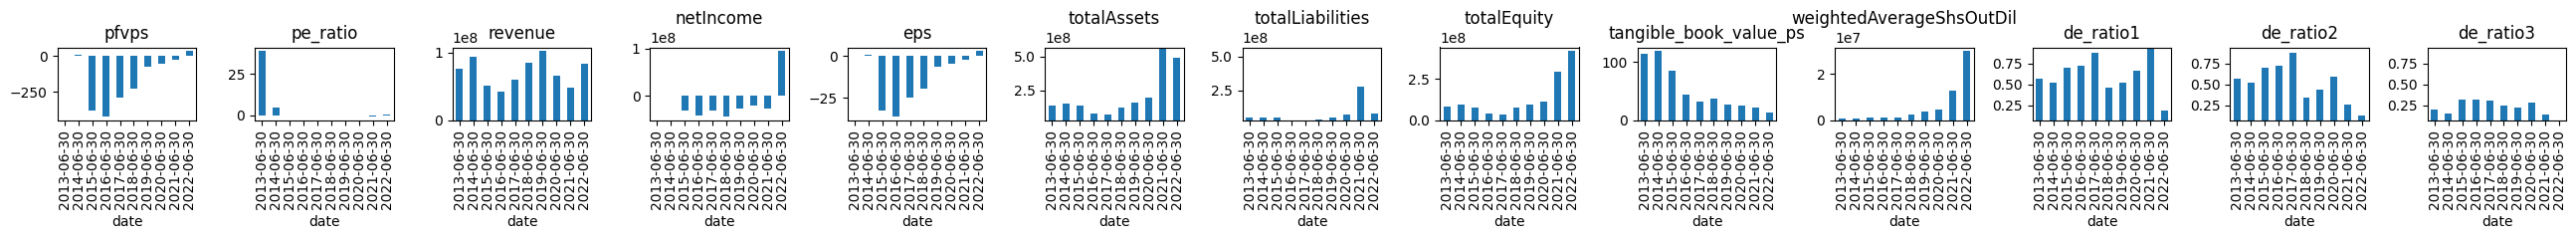

 52%|██████████████████████████████████████████████████████████▎                                                      | 772/1495 [1:05:20<1:32:53,  7.71s/it]

negative growth


 52%|██████████████████████████████████████████████████████████▍                                                      | 773/1495 [1:05:22<1:13:27,  6.10s/it]

length equals zero
less than 5 reports


 52%|██████████████████████████████████████████████████████████▌                                                      | 774/1495 [1:05:25<1:00:03,  5.00s/it]

only negative pe in history


 52%|██████████████████████████████████████████████████████████▌                                                      | 775/1495 [1:05:33<1:13:35,  6.13s/it]

overvalued. price: 1.01, pfvps: -15.160342570432158


 52%|██████████████████████████████████████████████████████████▋                                                      | 776/1495 [1:05:43<1:26:56,  7.26s/it]

length equals zero
less than 5 reports


 52%|██████████████████████████████████████████████████████████▋                                                      | 777/1495 [1:05:46<1:11:05,  5.94s/it]

only negative pe in history


 52%|██████████████████████████████████████████████████████████▊                                                      | 778/1495 [1:05:56<1:24:55,  7.11s/it]

length equals zero
less than 5 reports


 52%|██████████████████████████████████████████████████████████▉                                                      | 779/1495 [1:05:58<1:08:03,  5.70s/it]

length equals zero
less than 5 reports


 52%|████████████████████████████████████████████████████████████                                                       | 780/1495 [1:06:01<56:13,  4.72s/it]

overvalued. price: 2.83, pfvps: -0.46181814279974903


 52%|███████████████████████████████████████████████████████████                                                      | 781/1495 [1:06:11<1:15:05,  6.31s/it]

negative growth


 52%|███████████████████████████████████████████████████████████                                                      | 782/1495 [1:06:13<1:00:58,  5.13s/it]

length equals zero
less than 5 reports


 52%|████████████████████████████████████████████████████████████▏                                                      | 783/1495 [1:06:16<51:14,  4.32s/it]

negative growth


 52%|████████████████████████████████████████████████████████████▎                                                      | 784/1495 [1:06:18<44:19,  3.74s/it]

only negative pe in history


 53%|███████████████████████████████████████████████████████████▎                                                     | 785/1495 [1:06:27<1:03:20,  5.35s/it]

length equals zero
less than 5 reports


 53%|████████████████████████████████████████████████████████████▍                                                      | 786/1495 [1:06:30<52:52,  4.47s/it]

less than 5 reports


 53%|████████████████████████████████████████████████████████████▌                                                      | 787/1495 [1:06:32<45:25,  3.85s/it]

length equals zero
less than 5 reports


 53%|████████████████████████████████████████████████████████████▌                                                      | 788/1495 [1:06:34<40:25,  3.43s/it]

length equals zero
less than 5 reports


 53%|████████████████████████████████████████████████████████████▋                                                      | 789/1495 [1:06:37<36:46,  3.13s/it]

length equals zero
less than 5 reports


 53%|████████████████████████████████████████████████████████████▊                                                      | 790/1495 [1:06:39<34:18,  2.92s/it]

only negative pe in history


 53%|████████████████████████████████████████████████████████████▊                                                      | 791/1495 [1:06:47<52:02,  4.44s/it]

overvalued. price: 20.01, pfvps: 1.3489968601124416


 53%|███████████████████████████████████████████████████████████▊                                                     | 792/1495 [1:06:55<1:03:45,  5.44s/it]

overvalued. price: 0.4755, pfvps: -2.23584051664812


 53%|███████████████████████████████████████████████████████████▉                                                     | 793/1495 [1:07:05<1:19:19,  6.78s/it]

length equals zero
less than 5 reports


 53%|████████████████████████████████████████████████████████████                                                     | 794/1495 [1:07:07<1:03:51,  5.47s/it]

length equals zero
less than 5 reports


 53%|█████████████████████████████████████████████████████████████▏                                                     | 795/1495 [1:07:10<53:09,  4.56s/it]

only negative pe in history


 53%|████████████████████████████████████████████████████████████▏                                                    | 796/1495 [1:07:18<1:06:38,  5.72s/it]

negative growth


 53%|█████████████████████████████████████████████████████████████▎                                                     | 797/1495 [1:07:21<56:45,  4.88s/it]

negative growth


 53%|█████████████████████████████████████████████████████████████▍                                                     | 798/1495 [1:07:24<47:58,  4.13s/it]

length equals zero
less than 5 reports


 53%|█████████████████████████████████████████████████████████████▍                                                     | 799/1495 [1:07:26<41:54,  3.61s/it]

length equals zero
less than 5 reports


 54%|█████████████████████████████████████████████████████████████▌                                                     | 800/1495 [1:07:28<37:45,  3.26s/it]

length equals zero
less than 5 reports


 54%|█████████████████████████████████████████████████████████████▌                                                     | 801/1495 [1:07:31<36:36,  3.16s/it]

overvalued. price: 7.44, pfvps: -4.720997321330477


 54%|████████████████████████████████████████████████████████████▌                                                    | 802/1495 [1:07:41<1:00:07,  5.21s/it]

length equals zero
less than 5 reports


 54%|█████████████████████████████████████████████████████████████▊                                                     | 803/1495 [1:07:44<51:18,  4.45s/it]

length equals zero
less than 5 reports


 54%|█████████████████████████████████████████████████████████████▊                                                     | 804/1495 [1:07:47<46:20,  4.02s/it]

length equals zero
less than 5 reports


 54%|█████████████████████████████████████████████████████████████▉                                                     | 805/1495 [1:07:49<40:50,  3.55s/it]

length equals zero
less than 5 reports


 54%|██████████████████████████████████████████████████████████████                                                     | 806/1495 [1:07:52<36:48,  3.21s/it]

length equals zero
less than 5 reports


 54%|██████████████████████████████████████████████████████████████                                                     | 807/1495 [1:07:54<34:03,  2.97s/it]

CLRO.	 Current price: 0.7596.	 Faire price: 4.8474443729444525


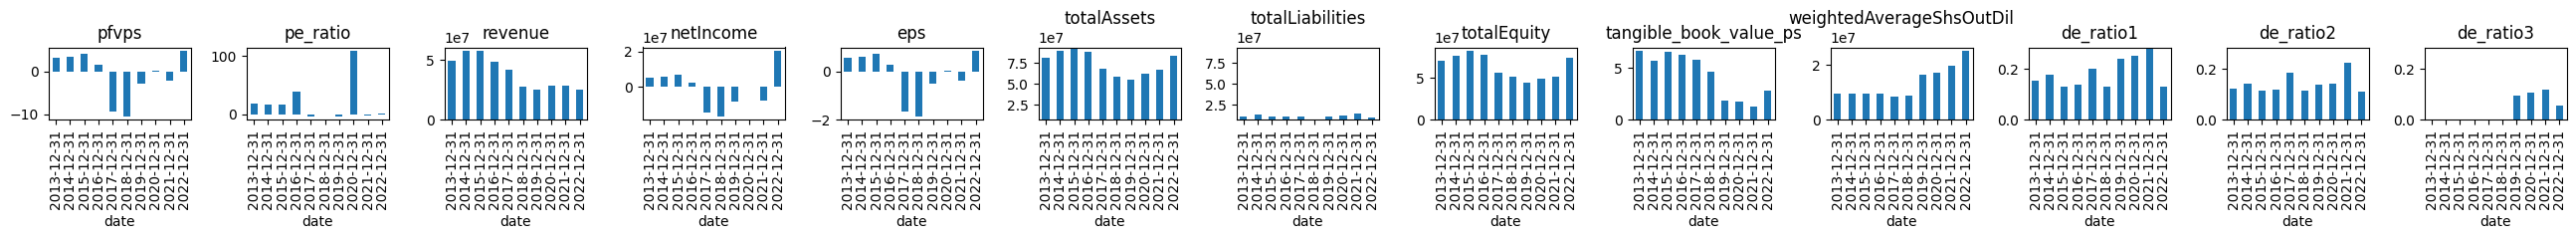

 54%|█████████████████████████████████████████████████████████████                                                    | 808/1495 [1:08:14<1:30:46,  7.93s/it]

overvalued. price: 188.09, pfvps: 32.57983781242518


 54%|█████████████████████████████████████████████████████████████▏                                                   | 809/1495 [1:08:24<1:37:27,  8.52s/it]

JAN.	 Current price: 0.412.	 Faire price: 2.053274213973605


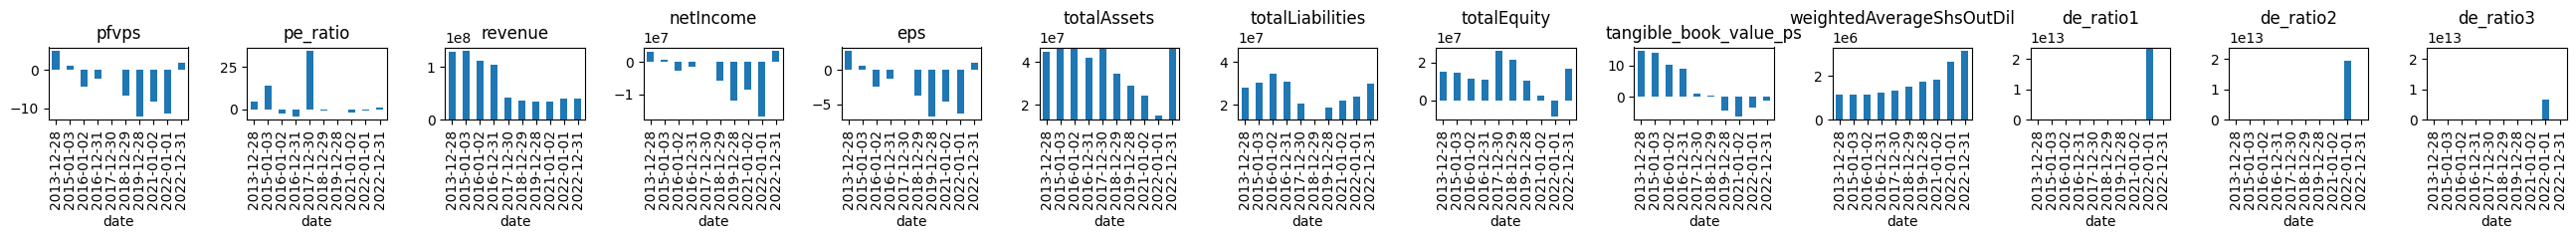

 54%|█████████████████████████████████████████████████████████████▏                                                   | 810/1495 [1:08:43<2:13:50, 11.72s/it]

length equals zero
less than 5 reports


 54%|█████████████████████████████████████████████████████████████▎                                                   | 811/1495 [1:08:46<1:43:30,  9.08s/it]

overvalued. price: 4.29, pfvps: -10.855152690412


 54%|█████████████████████████████████████████████████████████████▍                                                   | 812/1495 [1:08:56<1:47:18,  9.43s/it]

length equals zero
less than 5 reports


 54%|█████████████████████████████████████████████████████████████▍                                                   | 813/1495 [1:08:58<1:23:18,  7.33s/it]

length equals zero
less than 5 reports


 54%|█████████████████████████████████████████████████████████████▌                                                   | 814/1495 [1:09:01<1:07:55,  5.99s/it]

length equals zero
less than 5 reports


 55%|██████████████████████████████████████████████████████████████▋                                                    | 815/1495 [1:09:04<55:38,  4.91s/it]

length equals zero
less than 5 reports


 55%|██████████████████████████████████████████████████████████████▊                                                    | 816/1495 [1:09:06<47:22,  4.19s/it]

less than 5 reports


 55%|██████████████████████████████████████████████████████████████▊                                                    | 817/1495 [1:09:09<41:11,  3.65s/it]

length equals zero
less than 5 reports


 55%|██████████████████████████████████████████████████████████████▉                                                    | 818/1495 [1:09:12<38:57,  3.45s/it]

length equals zero
less than 5 reports


 55%|██████████████████████████████████████████████████████████████▉                                                    | 819/1495 [1:09:14<35:29,  3.15s/it]

overvalued. price: 5.92, pfvps: 0.0


 55%|███████████████████████████████████████████████████████████████                                                    | 820/1495 [1:09:22<51:45,  4.60s/it]

length equals zero
less than 5 reports


 55%|███████████████████████████████████████████████████████████████▏                                                   | 821/1495 [1:09:24<44:20,  3.95s/it]

negative growth


 55%|███████████████████████████████████████████████████████████████▏                                                   | 822/1495 [1:09:27<39:41,  3.54s/it]

only negative pe in history


 55%|██████████████████████████████████████████████████████████████▏                                                  | 823/1495 [1:09:37<1:00:59,  5.45s/it]

negative growth


 55%|███████████████████████████████████████████████████████████████▍                                                   | 824/1495 [1:09:39<50:37,  4.53s/it]

length equals zero
less than 5 reports


 55%|███████████████████████████████████████████████████████████████▍                                                   | 825/1495 [1:09:42<44:32,  3.99s/it]

length equals zero
less than 5 reports


 55%|███████████████████████████████████████████████████████████████▌                                                   | 826/1495 [1:09:45<39:22,  3.53s/it]

overvalued. price: 63.64, pfvps: 29.039160194041244


 55%|██████████████████████████████████████████████████████████████▌                                                  | 827/1495 [1:09:56<1:06:21,  5.96s/it]

CVR.	 Current price: 17.625.	 Faire price: 19.061890040194676


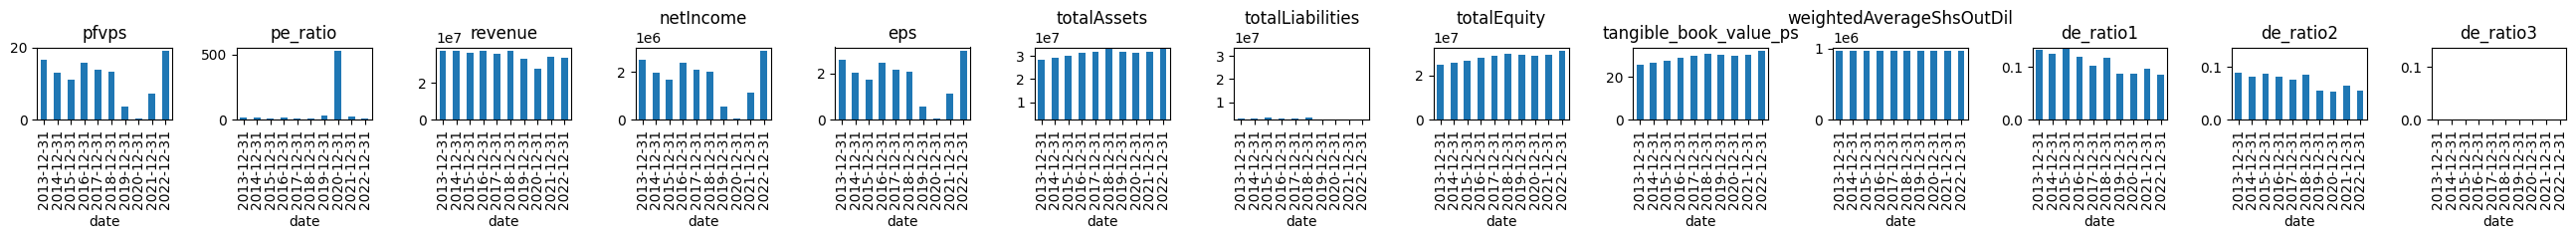

 55%|██████████████████████████████████████████████████████████████▌                                                  | 828/1495 [1:10:15<1:48:02,  9.72s/it]

length equals zero
less than 5 reports


 55%|██████████████████████████████████████████████████████████████▋                                                  | 829/1495 [1:10:17<1:24:08,  7.58s/it]

length equals zero
less than 5 reports


 56%|██████████████████████████████████████████████████████████████▋                                                  | 830/1495 [1:10:20<1:06:56,  6.04s/it]

overvalued. price: 32.5, pfvps: 7.653849434294099


 56%|██████████████████████████████████████████████████████████████▊                                                  | 831/1495 [1:10:27<1:11:04,  6.42s/it]

length equals zero
less than 5 reports


 56%|████████████████████████████████████████████████████████████████                                                   | 832/1495 [1:10:29<57:44,  5.23s/it]

length equals zero
less than 5 reports


 56%|████████████████████████████████████████████████████████████████                                                   | 833/1495 [1:10:32<48:19,  4.38s/it]

negative growth


 56%|████████████████████████████████████████████████████████████████▏                                                  | 834/1495 [1:10:35<43:13,  3.92s/it]

overvalued. price: 11.46, pfvps: 2.438775360716671


 56%|███████████████████████████████████████████████████████████████                                                  | 835/1495 [1:10:45<1:04:12,  5.84s/it]

length equals zero
less than 5 reports


 56%|████████████████████████████████████████████████████████████████▎                                                  | 836/1495 [1:10:47<52:56,  4.82s/it]

length equals zero
less than 5 reports


 56%|████████████████████████████████████████████████████████████████▍                                                  | 837/1495 [1:10:50<46:55,  4.28s/it]

length equals zero
less than 5 reports


 56%|████████████████████████████████████████████████████████████████▍                                                  | 838/1495 [1:10:53<40:37,  3.71s/it]

length equals zero
less than 5 reports


 56%|████████████████████████████████████████████████████████████████▌                                                  | 839/1495 [1:10:55<36:16,  3.32s/it]

overvalued. price: 1.1703, pfvps: -0.20100109910425215


 56%|████████████████████████████████████████████████████████████████▌                                                  | 840/1495 [1:11:05<58:29,  5.36s/it]

length equals zero
less than 5 reports


 56%|████████████████████████████████████████████████████████████████▋                                                  | 841/1495 [1:11:08<50:59,  4.68s/it]

length equals zero
less than 5 reports


 56%|████████████████████████████████████████████████████████████████▊                                                  | 842/1495 [1:11:11<43:28,  3.99s/it]

length equals zero
less than 5 reports


 56%|████████████████████████████████████████████████████████████████▊                                                  | 843/1495 [1:11:14<40:14,  3.70s/it]

overvalued. price: 0.98, pfvps: -2.441220289510245


 56%|███████████████████████████████████████████████████████████████▊                                                 | 844/1495 [1:11:26<1:06:35,  6.14s/it]

negative growth


 57%|█████████████████████████████████████████████████████████████████                                                  | 845/1495 [1:11:28<54:11,  5.00s/it]

length equals zero
less than 5 reports


 57%|█████████████████████████████████████████████████████████████████                                                  | 846/1495 [1:11:31<46:40,  4.31s/it]

length equals zero
less than 5 reports


 57%|█████████████████████████████████████████████████████████████████▏                                                 | 847/1495 [1:11:34<42:07,  3.90s/it]

length equals zero
less than 5 reports


 57%|█████████████████████████████████████████████████████████████████▏                                                 | 848/1495 [1:11:37<39:31,  3.67s/it]

less than 5 reports


 57%|█████████████████████████████████████████████████████████████████▎                                                 | 849/1495 [1:11:39<35:16,  3.28s/it]

length equals zero
less than 5 reports


 57%|█████████████████████████████████████████████████████████████████▍                                                 | 850/1495 [1:11:42<32:33,  3.03s/it]

negative growth


 57%|█████████████████████████████████████████████████████████████████▍                                                 | 851/1495 [1:11:44<30:28,  2.84s/it]

overvalued. price: 10.4, pfvps: -15.017915990883886


 57%|█████████████████████████████████████████████████████████████████▌                                                 | 852/1495 [1:11:53<51:08,  4.77s/it]

length equals zero
less than 5 reports


 57%|█████████████████████████████████████████████████████████████████▌                                                 | 853/1495 [1:11:56<43:31,  4.07s/it]

negative growth


 57%|█████████████████████████████████████████████████████████████████▋                                                 | 854/1495 [1:11:58<39:03,  3.66s/it]

length equals zero
less than 5 reports


 57%|█████████████████████████████████████████████████████████████████▊                                                 | 855/1495 [1:12:01<35:04,  3.29s/it]

only negative pe in history


 57%|█████████████████████████████████████████████████████████████████▊                                                 | 856/1495 [1:12:07<43:06,  4.05s/it]

overvalued. price: 176.94, pfvps: 112.74003580161174


 57%|████████████████████████████████████████████████████████████████▊                                                | 857/1495 [1:12:17<1:03:23,  5.96s/it]

VHI.	 Current price: 13.26.	 Faire price: 23.54288734089644


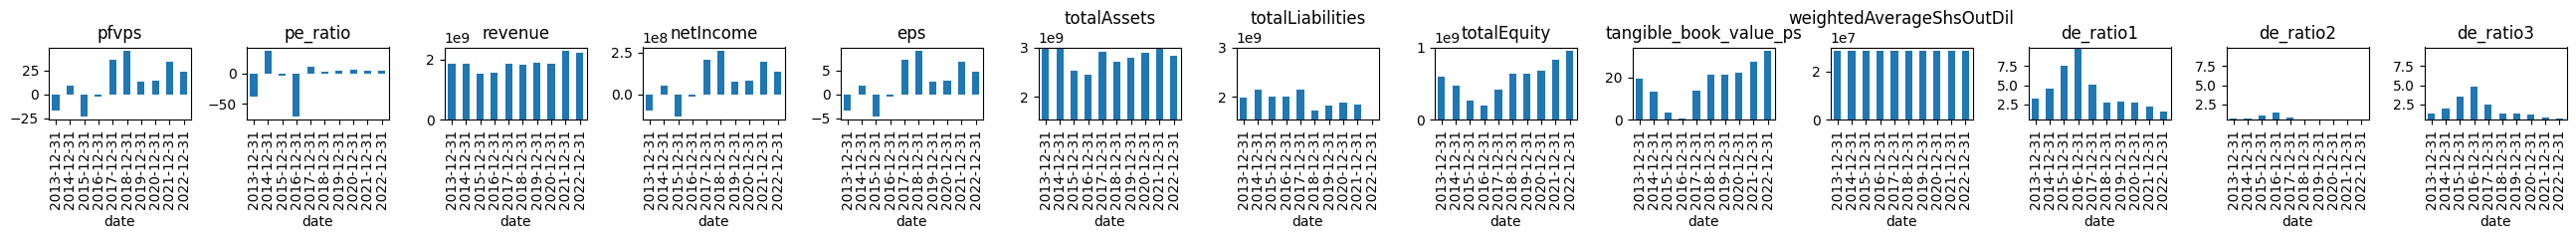

 57%|████████████████████████████████████████████████████████████████▊                                                | 858/1495 [1:12:36<1:44:47,  9.87s/it]

less than 5 reports


 57%|████████████████████████████████████████████████████████████████▉                                                | 859/1495 [1:12:39<1:22:53,  7.82s/it]

ASYS.	 Current price: 7.62.	 Faire price: 8.16829533392265


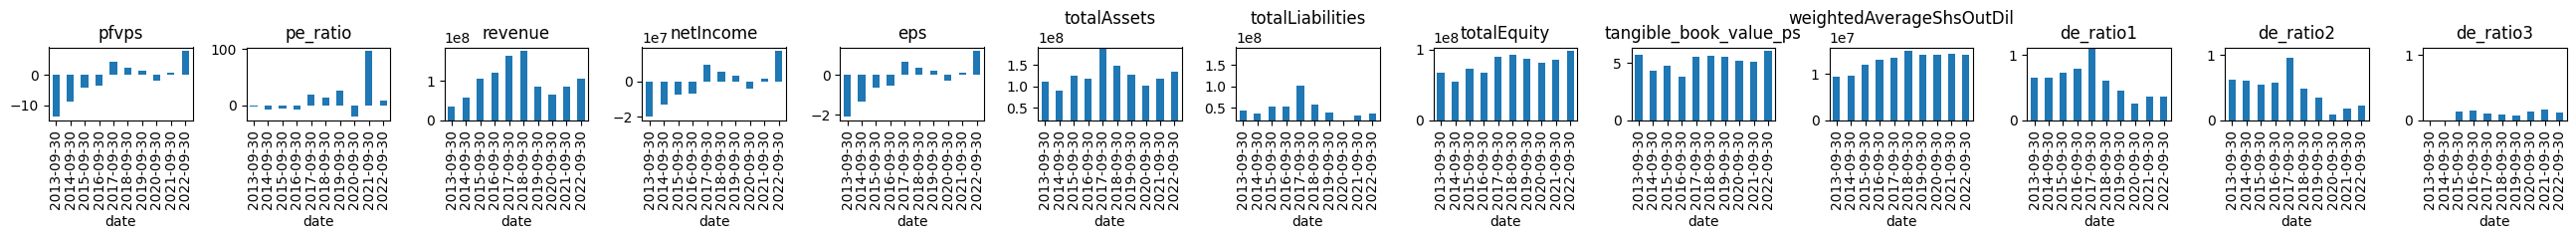

 58%|█████████████████████████████████████████████████████████████████                                                | 860/1495 [1:12:58<1:58:46, 11.22s/it]

less than 5 reports


 58%|█████████████████████████████████████████████████████████████████                                                | 861/1495 [1:13:01<1:31:31,  8.66s/it]

less than 5 reports


 58%|█████████████████████████████████████████████████████████████████▏                                               | 862/1495 [1:13:03<1:11:27,  6.77s/it]

length equals zero
less than 5 reports


 58%|██████████████████████████████████████████████████████████████████▍                                                | 863/1495 [1:13:06<57:50,  5.49s/it]

only negative pe in history


 58%|█████████████████████████████████████████████████████████████████▎                                               | 864/1495 [1:13:15<1:09:38,  6.62s/it]

length equals zero
less than 5 reports


 58%|██████████████████████████████████████████████████████████████████▌                                                | 865/1495 [1:13:18<56:55,  5.42s/it]

length equals zero
less than 5 reports


 58%|██████████████████████████████████████████████████████████████████▌                                                | 866/1495 [1:13:20<47:23,  4.52s/it]

negative growth


 58%|██████████████████████████████████████████████████████████████████▋                                                | 867/1495 [1:13:23<40:33,  3.87s/it]

negative growth


 58%|██████████████████████████████████████████████████████████████████▊                                                | 868/1495 [1:13:25<35:47,  3.43s/it]

overvalued. price: 35.45, pfvps: -14.715011907860688


 58%|██████████████████████████████████████████████████████████████████▊                                                | 869/1495 [1:13:35<58:00,  5.56s/it]

negative growth


 58%|██████████████████████████████████████████████████████████████████▉                                                | 870/1495 [1:13:38<48:12,  4.63s/it]

overvalued. price: 126.45, pfvps: 93.03220234934756


 58%|█████████████████████████████████████████████████████████████████▊                                               | 871/1495 [1:13:48<1:06:16,  6.37s/it]

overvalued. price: 9.46, pfvps: -8.186089188453156


 58%|█████████████████████████████████████████████████████████████████▉                                               | 872/1495 [1:14:00<1:21:12,  7.82s/it]

less than 5 reports


 58%|█████████████████████████████████████████████████████████████████▉                                               | 873/1495 [1:14:02<1:04:06,  6.18s/it]

overvalued. price: 6.73, pfvps: 5.080390254974936


 58%|██████████████████████████████████████████████████████████████████                                               | 874/1495 [1:14:10<1:09:57,  6.76s/it]

DAR.	 Current price: 52.2.	 Faire price: 52.80752066672311


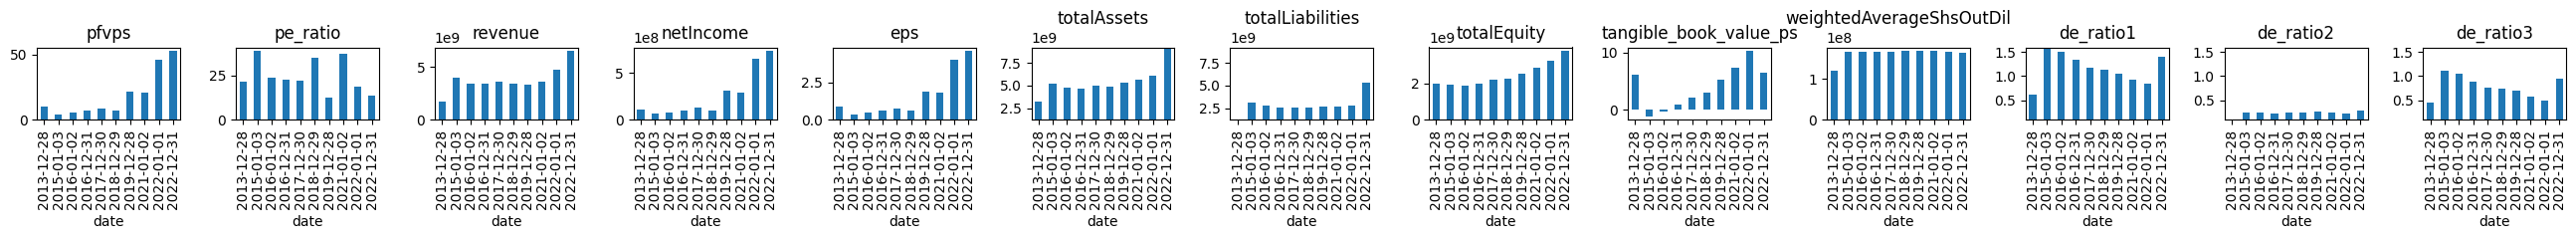

 59%|██████████████████████████████████████████████████████████████████▏                                              | 875/1495 [1:14:28<1:45:56, 10.25s/it]

length equals zero
less than 5 reports


 59%|██████████████████████████████████████████████████████████████████▏                                              | 876/1495 [1:14:31<1:21:31,  7.90s/it]

overvalued. price: 1.68, pfvps: -2.254178548885316


 59%|██████████████████████████████████████████████████████████████████▎                                              | 877/1495 [1:14:41<1:28:53,  8.63s/it]

overvalued. price: 19.85, pfvps: 18.33335289319225


 59%|██████████████████████████████████████████████████████████████████▎                                              | 878/1495 [1:14:51<1:32:55,  9.04s/it]

overvalued. price: 6.43, pfvps: -0.3977494520721323


 59%|██████████████████████████████████████████████████████████████████▍                                              | 879/1495 [1:15:01<1:35:29,  9.30s/it]

length equals zero
less than 5 reports


 59%|██████████████████████████████████████████████████████████████████▌                                              | 880/1495 [1:15:04<1:16:03,  7.42s/it]

negative growth


 59%|██████████████████████████████████████████████████████████████████▌                                              | 881/1495 [1:15:06<1:00:25,  5.91s/it]

JOUT.	 Current price: 54.69.	 Faire price: 56.74198485557357


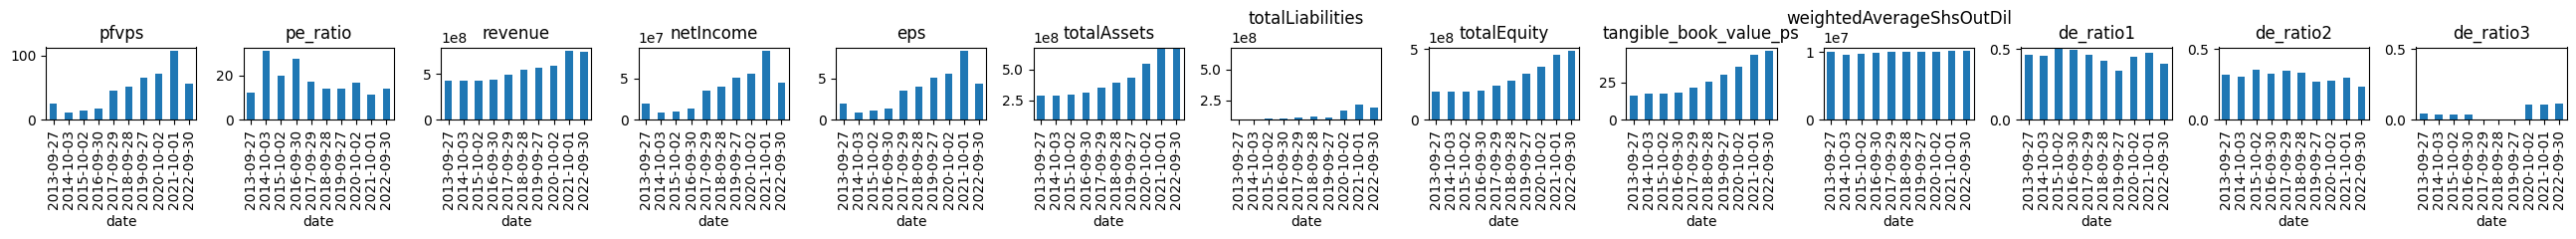

 59%|██████████████████████████████████████████████████████████████████▋                                              | 882/1495 [1:15:25<1:40:11,  9.81s/it]

overvalued. price: 0.3689, pfvps: 0.04073513394116438


 59%|██████████████████████████████████████████████████████████████████▋                                              | 883/1495 [1:15:35<1:40:29,  9.85s/it]

negative growth


 59%|██████████████████████████████████████████████████████████████████▊                                              | 884/1495 [1:15:38<1:17:29,  7.61s/it]

only negative pe in history


 59%|██████████████████████████████████████████████████████████████████▉                                              | 885/1495 [1:15:47<1:22:45,  8.14s/it]

negative growth


 59%|██████████████████████████████████████████████████████████████████▉                                              | 886/1495 [1:15:49<1:05:02,  6.41s/it]

length equals zero
less than 5 reports


 59%|████████████████████████████████████████████████████████████████████▏                                              | 887/1495 [1:15:52<54:23,  5.37s/it]

negative growth


 59%|████████████████████████████████████████████████████████████████████▎                                              | 888/1495 [1:15:55<45:12,  4.47s/it]

length equals zero
less than 5 reports


 59%|████████████████████████████████████████████████████████████████████▍                                              | 889/1495 [1:15:57<39:31,  3.91s/it]

only negative pe in history


 60%|███████████████████████████████████████████████████████████████████▎                                             | 890/1495 [1:16:09<1:02:51,  6.23s/it]

length equals zero
less than 5 reports


 60%|████████████████████████████████████████████████████████████████████▌                                              | 891/1495 [1:16:12<53:07,  5.28s/it]

length equals zero
less than 5 reports


 60%|████████████████████████████████████████████████████████████████████▌                                              | 892/1495 [1:16:15<44:30,  4.43s/it]

length equals zero
less than 5 reports


 60%|████████████████████████████████████████████████████████████████████▋                                              | 893/1495 [1:16:17<38:18,  3.82s/it]

less than 5 reports


 60%|████████████████████████████████████████████████████████████████████▊                                              | 894/1495 [1:16:20<35:23,  3.53s/it]

overvalued. price: 0.1062, pfvps: 0.0


 60%|████████████████████████████████████████████████████████████████████▊                                              | 895/1495 [1:16:27<45:51,  4.59s/it]

less than 5 reports


 60%|████████████████████████████████████████████████████████████████████▉                                              | 896/1495 [1:16:29<39:16,  3.93s/it]

overvalued. price: 2.11, pfvps: -31.584398541250135


 60%|█████████████████████████████████████████████████████████████████████                                              | 897/1495 [1:16:39<56:57,  5.71s/it]

overvalued. price: 40.01, pfvps: 31.47333216410979


 60%|███████████████████████████████████████████████████████████████████▉                                             | 898/1495 [1:16:50<1:11:00,  7.14s/it]

overvalued. price: 10.1, pfvps: 2.7995276222505248


 60%|███████████████████████████████████████████████████████████████████▉                                             | 899/1495 [1:17:00<1:20:24,  8.09s/it]

length equals zero
less than 5 reports


 60%|████████████████████████████████████████████████████████████████████                                             | 900/1495 [1:17:03<1:05:21,  6.59s/it]

length equals zero
less than 5 reports


 60%|█████████████████████████████████████████████████████████████████████▎                                             | 901/1495 [1:17:06<54:23,  5.49s/it]

length equals zero
less than 5 reports


 60%|█████████████████████████████████████████████████████████████████████▍                                             | 902/1495 [1:17:09<46:28,  4.70s/it]

length equals zero
less than 5 reports


 60%|█████████████████████████████████████████████████████████████████████▍                                             | 903/1495 [1:17:11<39:44,  4.03s/it]

negative growth


 60%|█████████████████████████████████████████████████████████████████████▌                                             | 904/1495 [1:17:14<34:52,  3.54s/it]

length equals zero
less than 5 reports


 61%|█████████████████████████████████████████████████████████████████████▌                                             | 905/1495 [1:17:16<31:33,  3.21s/it]

overvalued. price: 2, pfvps: -3.8362342535436658


 61%|█████████████████████████████████████████████████████████████████████▋                                             | 906/1495 [1:17:23<41:08,  4.19s/it]

length equals zero
less than 5 reports


 61%|█████████████████████████████████████████████████████████████████████▊                                             | 907/1495 [1:17:25<36:15,  3.70s/it]

length equals zero
less than 5 reports


 61%|█████████████████████████████████████████████████████████████████████▊                                             | 908/1495 [1:17:28<32:28,  3.32s/it]

length equals zero
less than 5 reports


 61%|█████████████████████████████████████████████████████████████████████▉                                             | 909/1495 [1:17:30<30:33,  3.13s/it]

only negative pe in history


 61%|██████████████████████████████████████████████████████████████████████                                             | 910/1495 [1:17:40<50:55,  5.22s/it]

negative growth


 61%|██████████████████████████████████████████████████████████████████████                                             | 911/1495 [1:17:43<42:57,  4.41s/it]

overvalued. price: 0.2585, pfvps: -6.102032211581587


 61%|██████████████████████████████████████████████████████████████████████▏                                            | 912/1495 [1:17:53<58:34,  6.03s/it]

negative growth


 61%|██████████████████████████████████████████████████████████████████████▏                                            | 913/1495 [1:17:55<47:46,  4.93s/it]

length equals zero
less than 5 reports


 61%|██████████████████████████████████████████████████████████████████████▎                                            | 914/1495 [1:17:57<40:24,  4.17s/it]

length equals zero
less than 5 reports


 61%|██████████████████████████████████████████████████████████████████████▍                                            | 915/1495 [1:18:00<36:32,  3.78s/it]

length equals zero
less than 5 reports


 61%|██████████████████████████████████████████████████████████████████████▍                                            | 916/1495 [1:18:03<32:35,  3.38s/it]

overvalued. price: 34.99, pfvps: 0.0


 61%|██████████████████████████████████████████████████████████████████████▌                                            | 917/1495 [1:18:13<51:25,  5.34s/it]

CTRM.	 Current price: 0.437.	 Faire price: 3.2036868358082113


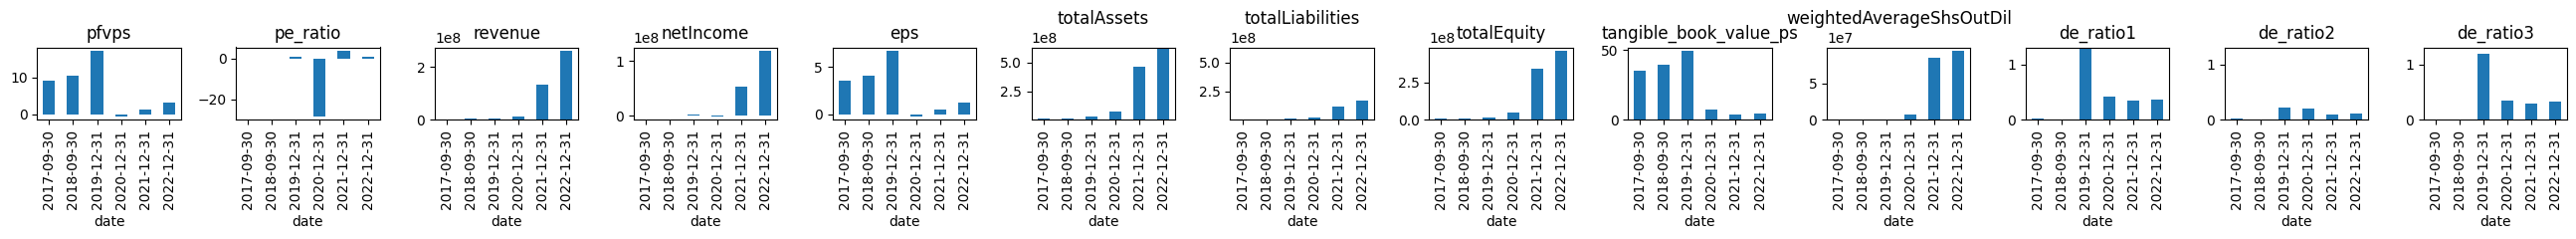

 61%|█████████████████████████████████████████████████████████████████████▍                                           | 918/1495 [1:18:28<1:18:59,  8.21s/it]

length equals zero
less than 5 reports


 61%|█████████████████████████████████████████████████████████████████████▍                                           | 919/1495 [1:18:30<1:02:05,  6.47s/it]

negative growth


 62%|██████████████████████████████████████████████████████████████████████▊                                            | 920/1495 [1:18:33<51:23,  5.36s/it]

overvalued. price: None, pfvps: -9.02526266916017


 62%|██████████████████████████████████████████████████████████████████████▊                                            | 921/1495 [1:18:40<57:15,  5.98s/it]

length equals zero
less than 5 reports


 62%|██████████████████████████████████████████████████████████████████████▉                                            | 922/1495 [1:18:43<46:53,  4.91s/it]

length equals zero
less than 5 reports


 62%|███████████████████████████████████████████████████████████████████████                                            | 923/1495 [1:18:46<41:11,  4.32s/it]

less than 5 reports


 62%|███████████████████████████████████████████████████████████████████████                                            | 924/1495 [1:18:48<37:09,  3.91s/it]

length equals zero
less than 5 reports


 62%|███████████████████████████████████████████████████████████████████████▏                                           | 925/1495 [1:18:51<32:59,  3.47s/it]

length equals zero
less than 5 reports


 62%|███████████████████████████████████████████████████████████████████████▏                                           | 926/1495 [1:18:53<29:56,  3.16s/it]

less than 5 reports


 62%|███████████████████████████████████████████████████████████████████████▎                                           | 927/1495 [1:18:56<27:36,  2.92s/it]

negative growth


 62%|███████████████████████████████████████████████████████████████████████▍                                           | 928/1495 [1:18:58<26:03,  2.76s/it]

negative growth


 62%|███████████████████████████████████████████████████████████████████████▍                                           | 929/1495 [1:19:01<25:03,  2.66s/it]

less than 5 reports


 62%|███████████████████████████████████████████████████████████████████████▌                                           | 930/1495 [1:19:03<24:09,  2.56s/it]

length equals zero
less than 5 reports


 62%|███████████████████████████████████████████████████████████████████████▌                                           | 931/1495 [1:19:05<23:39,  2.52s/it]

less than 5 reports


 62%|███████████████████████████████████████████████████████████████████████▋                                           | 932/1495 [1:19:08<23:13,  2.47s/it]

length equals zero
less than 5 reports


 62%|███████████████████████████████████████████████████████████████████████▊                                           | 933/1495 [1:19:10<22:57,  2.45s/it]

less than 5 reports


 62%|███████████████████████████████████████████████████████████████████████▊                                           | 934/1495 [1:19:13<24:14,  2.59s/it]

ENRT.	 Current price: 0.0212.	 Faire price: 0.31668541349058027


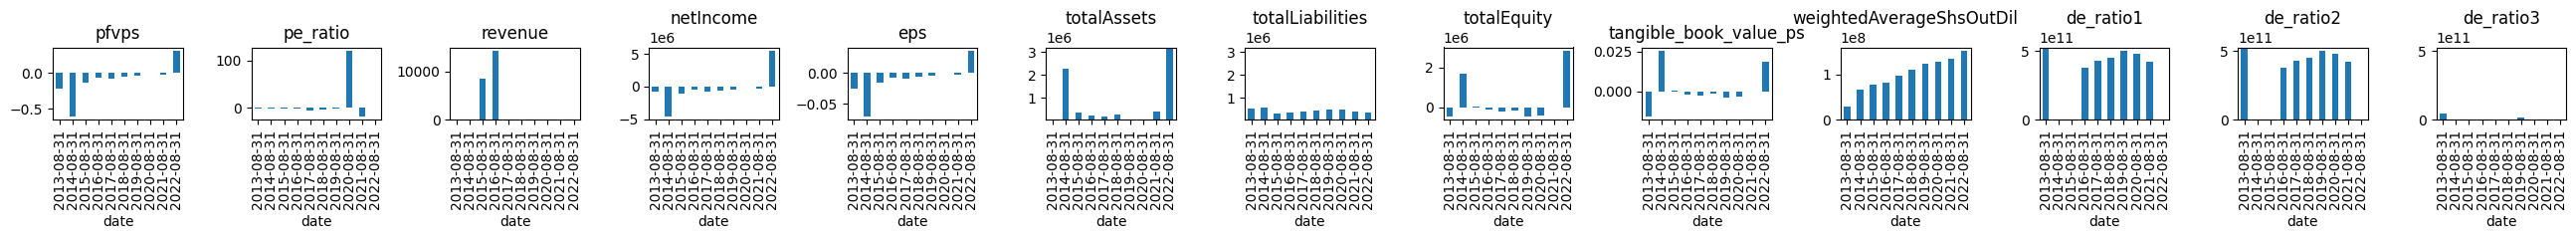

 63%|██████████████████████████████████████████████████████████████████████▋                                          | 935/1495 [1:19:31<1:08:23,  7.33s/it]

KARO.	 Current price: 19.91.	 Faire price: 50.79132097844561


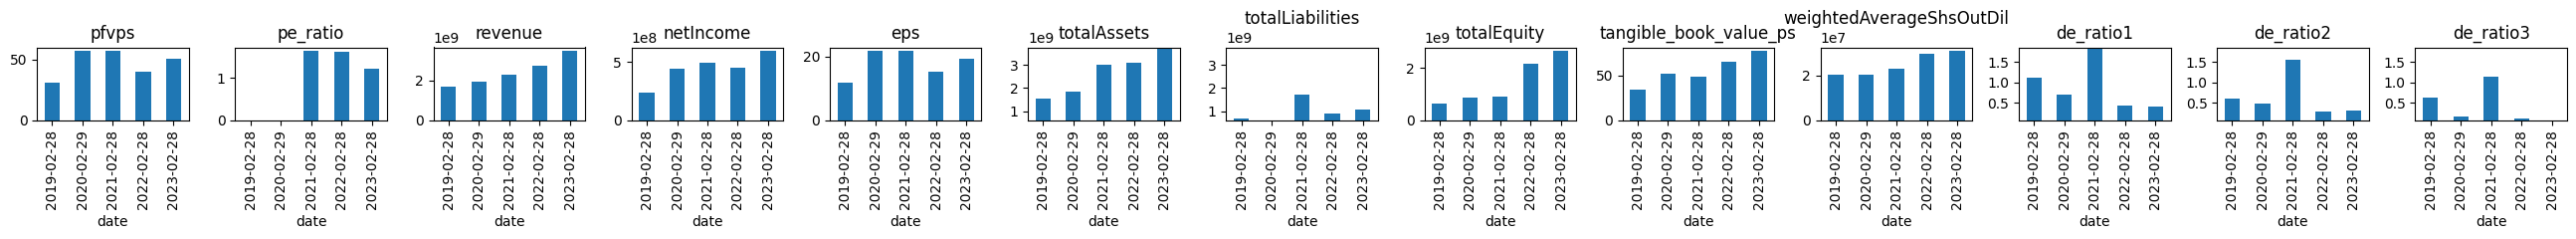

 63%|██████████████████████████████████████████████████████████████████████▋                                          | 936/1495 [1:19:43<1:20:36,  8.65s/it]

length equals zero
less than 5 reports


 63%|██████████████████████████████████████████████████████████████████████▊                                          | 937/1495 [1:19:46<1:03:20,  6.81s/it]

overvalued. price: 33.62, pfvps: 19.44805942260677


 63%|██████████████████████████████████████████████████████████████████████▉                                          | 938/1495 [1:19:56<1:12:51,  7.85s/it]

less than 5 reports


 63%|████████████████████████████████████████████████████████████████████████▏                                          | 939/1495 [1:19:58<57:30,  6.21s/it]

overvalued. price: 71.79, pfvps: 29.99379226946988


 63%|███████████████████████████████████████████████████████████████████████                                          | 940/1495 [1:20:09<1:10:16,  7.60s/it]

length equals zero
less than 5 reports


 63%|████████████████████████████████████████████████████████████████████████▍                                          | 941/1495 [1:20:12<57:30,  6.23s/it]

less than 5 reports


 63%|████████████████████████████████████████████████████████████████████████▍                                          | 942/1495 [1:20:15<48:39,  5.28s/it]

less than 5 reports


 63%|████████████████████████████████████████████████████████████████████████▌                                          | 943/1495 [1:20:18<40:37,  4.42s/it]

less than 5 reports


 63%|████████████████████████████████████████████████████████████████████████▌                                          | 944/1495 [1:20:20<34:56,  3.81s/it]

length equals zero
less than 5 reports


 63%|████████████████████████████████████████████████████████████████████████▋                                          | 945/1495 [1:20:22<31:06,  3.39s/it]

negative growth


 63%|████████████████████████████████████████████████████████████████████████▊                                          | 946/1495 [1:20:25<28:15,  3.09s/it]

overvalued. price: 43.51, pfvps: 36.48370424139268


 63%|████████████████████████████████████████████████████████████████████████▊                                          | 947/1495 [1:20:36<49:12,  5.39s/it]

length equals zero
less than 5 reports


 63%|████████████████████████████████████████████████████████████████████████▉                                          | 948/1495 [1:20:38<41:03,  4.50s/it]

negative growth


 63%|█████████████████████████████████████████████████████████████████████████                                          | 949/1495 [1:20:40<35:09,  3.86s/it]

overvalued. price: 10.11, pfvps: 8.941868620718724


 64%|█████████████████████████████████████████████████████████████████████████                                          | 950/1495 [1:20:51<53:02,  5.84s/it]

overvalued. price: 10.63, pfvps: 0.4729095964548766


 64%|███████████████████████████████████████████████████████████████████████▉                                         | 951/1495 [1:21:00<1:01:46,  6.81s/it]

length equals zero
less than 5 reports


 64%|█████████████████████████████████████████████████████████████████████████▏                                         | 952/1495 [1:21:03<51:23,  5.68s/it]

length equals zero
less than 5 reports


 64%|█████████████████████████████████████████████████████████████████████████▎                                         | 953/1495 [1:21:06<43:23,  4.80s/it]

overvalued. price: 1.68, pfvps: -11.145170952562097


 64%|████████████████████████████████████████████████████████████████████████                                         | 954/1495 [1:21:17<1:01:27,  6.82s/it]

length equals zero
less than 5 reports


 64%|█████████████████████████████████████████████████████████████████████████▍                                         | 955/1495 [1:21:20<49:36,  5.51s/it]

length equals zero
less than 5 reports


 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 956/1495 [1:21:22<41:04,  4.57s/it]

length equals zero
less than 5 reports


 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 957/1495 [1:21:25<35:23,  3.95s/it]

WLKP.	 Current price: 21.75.	 Faire price: 32.36713147942678


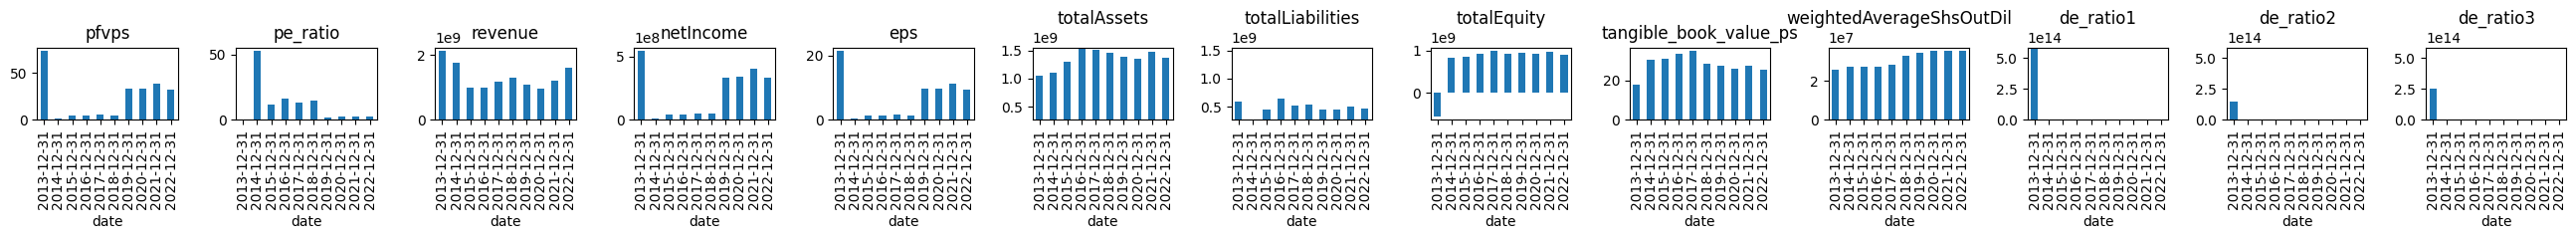

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 958/1495 [1:21:43<1:14:06,  8.28s/it]

negative growth


 64%|█████████████████████████████████████████████████████████████████████████▊                                         | 959/1495 [1:21:45<58:08,  6.51s/it]

FOR.	 Current price: 26.94.	 Faire price: 45.871644818230386


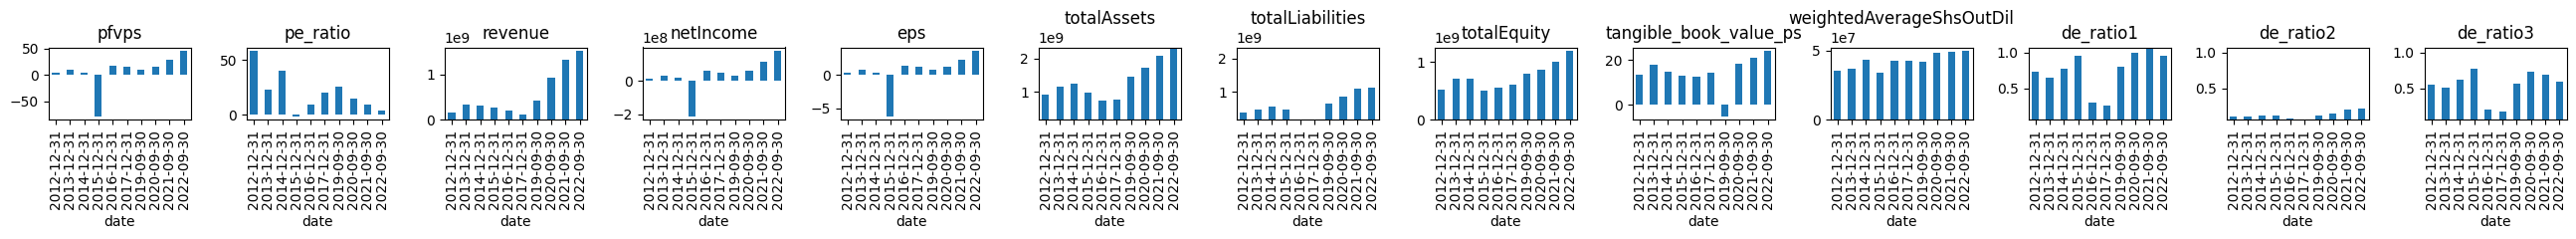

 64%|████████████████████████████████████████████████████████████████████████▌                                        | 960/1495 [1:22:05<1:32:31, 10.38s/it]

length equals zero
less than 5 reports


 64%|████████████████████████████████████████████████████████████████████████▋                                        | 961/1495 [1:22:07<1:12:08,  8.10s/it]

length equals zero
less than 5 reports


 64%|██████████████████████████████████████████████████████████████████████████                                         | 962/1495 [1:22:11<58:39,  6.60s/it]

overvalued. price: 9.98, pfvps: 2.94483933113283


 64%|████████████████████████████████████████████████████████████████████████▊                                        | 963/1495 [1:22:21<1:09:44,  7.87s/it]

only negative pe in history


 64%|████████████████████████████████████████████████████████████████████████▊                                        | 964/1495 [1:22:31<1:15:33,  8.54s/it]

length equals zero
less than 5 reports


 65%|████████████████████████████████████████████████████████████████████████▉                                        | 965/1495 [1:22:34<1:00:19,  6.83s/it]

overvalued. price: 7.78, pfvps: -35.30276920438957


 65%|█████████████████████████████████████████████████████████████████████████                                        | 966/1495 [1:22:45<1:09:14,  7.85s/it]

only negative pe in history


 65%|█████████████████████████████████████████████████████████████████████████                                        | 967/1495 [1:22:54<1:12:41,  8.26s/it]

negative growth


 65%|██████████████████████████████████████████████████████████████████████████▍                                        | 968/1495 [1:22:56<57:53,  6.59s/it]

length equals zero
less than 5 reports


 65%|██████████████████████████████████████████████████████████████████████████▌                                        | 969/1495 [1:22:59<48:17,  5.51s/it]

overvalued. price: None, pfvps: 4.0748724541193235


 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 970/1495 [1:23:10<1:01:05,  6.98s/it]

length equals zero
less than 5 reports


 65%|██████████████████████████████████████████████████████████████████████████▋                                        | 971/1495 [1:23:13<49:53,  5.71s/it]

length equals zero
less than 5 reports


 65%|██████████████████████████████████████████████████████████████████████████▊                                        | 972/1495 [1:23:16<42:36,  4.89s/it]

overvalued. price: 33.53, pfvps: 15.250967675914714


 65%|██████████████████████████████████████████████████████████████████████████▊                                        | 973/1495 [1:23:26<56:27,  6.49s/it]

negative growth


 65%|██████████████████████████████████████████████████████████████████████████▉                                        | 974/1495 [1:23:28<45:35,  5.25s/it]

less than 5 reports


 65%|███████████████████████████████████████████████████████████████████████████                                        | 975/1495 [1:23:31<37:57,  4.38s/it]

length equals zero
less than 5 reports


 65%|███████████████████████████████████████████████████████████████████████████                                        | 976/1495 [1:23:33<33:11,  3.84s/it]

length equals zero
less than 5 reports


 65%|███████████████████████████████████████████████████████████████████████████▏                                       | 977/1495 [1:23:36<31:09,  3.61s/it]

length equals zero
less than 5 reports


 65%|███████████████████████████████████████████████████████████████████████████▏                                       | 978/1495 [1:23:39<28:00,  3.25s/it]

overvalued. price: 13.33, pfvps: -59.05631921358451


 65%|███████████████████████████████████████████████████████████████████████████▎                                       | 979/1495 [1:23:49<45:30,  5.29s/it]

length equals zero
less than 5 reports


 66%|███████████████████████████████████████████████████████████████████████████▍                                       | 980/1495 [1:23:51<38:23,  4.47s/it]

length equals zero
less than 5 reports


 66%|███████████████████████████████████████████████████████████████████████████▍                                       | 981/1495 [1:23:54<33:03,  3.86s/it]

TSRI.	 Current price: 8.3.	 Faire price: 5615.108119642828


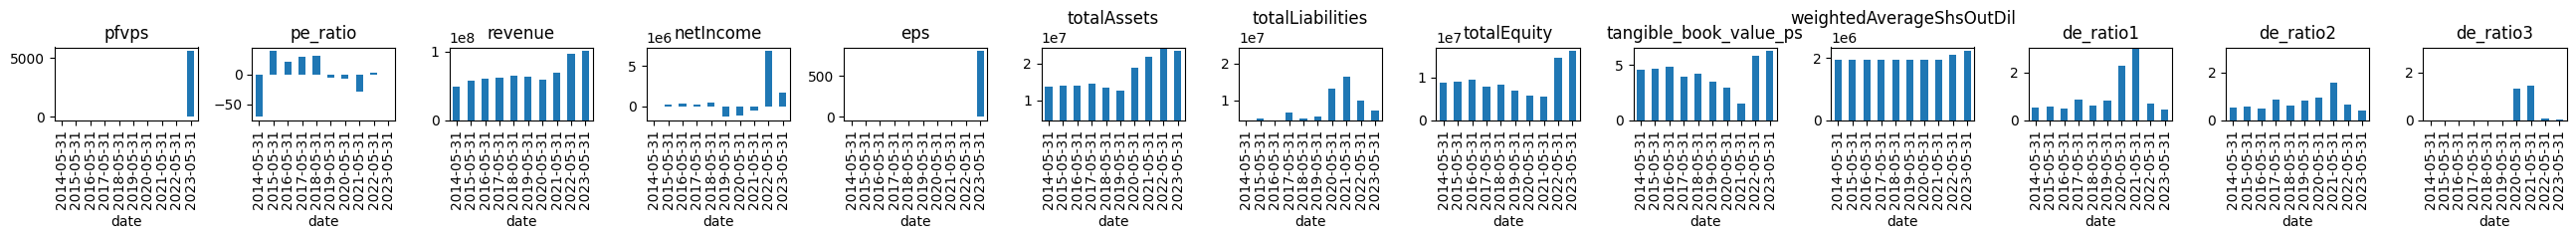

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 982/1495 [1:24:12<1:10:13,  8.21s/it]

length equals zero
less than 5 reports


 66%|███████████████████████████████████████████████████████████████████████████▌                                       | 983/1495 [1:24:14<55:12,  6.47s/it]

length equals zero
less than 5 reports


 66%|███████████████████████████████████████████████████████████████████████████▋                                       | 984/1495 [1:24:17<44:41,  5.25s/it]

length equals zero
less than 5 reports


 66%|███████████████████████████████████████████████████████████████████████████▊                                       | 985/1495 [1:24:19<37:26,  4.41s/it]

length equals zero
less than 5 reports


 66%|███████████████████████████████████████████████████████████████████████████▊                                       | 986/1495 [1:24:22<32:21,  3.81s/it]

length equals zero
less than 5 reports


 66%|███████████████████████████████████████████████████████████████████████████▉                                       | 987/1495 [1:24:24<28:57,  3.42s/it]

length equals zero
less than 5 reports


 66%|████████████████████████████████████████████████████████████████████████████                                       | 988/1495 [1:24:27<26:24,  3.12s/it]

overvalued. price: None, pfvps: 0.0


 66%|████████████████████████████████████████████████████████████████████████████                                       | 989/1495 [1:24:36<41:18,  4.90s/it]

only negative pe in history


 66%|████████████████████████████████████████████████████████████████████████████▏                                      | 990/1495 [1:24:48<59:55,  7.12s/it]

length equals zero
less than 5 reports


 66%|████████████████████████████████████████████████████████████████████████████▏                                      | 991/1495 [1:24:51<48:51,  5.82s/it]

negative growth


 66%|████████████████████████████████████████████████████████████████████████████▎                                      | 992/1495 [1:24:54<41:20,  4.93s/it]

length equals zero
less than 5 reports


 66%|████████████████████████████████████████████████████████████████████████████▍                                      | 993/1495 [1:24:57<36:14,  4.33s/it]

length equals zero
less than 5 reports


 66%|████████████████████████████████████████████████████████████████████████████▍                                      | 994/1495 [1:24:59<31:27,  3.77s/it]

negative growth


 67%|████████████████████████████████████████████████████████████████████████████▌                                      | 995/1495 [1:25:01<28:00,  3.36s/it]

length equals zero
less than 5 reports


 67%|████████████████████████████████████████████████████████████████████████████▌                                      | 996/1495 [1:25:04<26:24,  3.17s/it]

negative growth


 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 997/1495 [1:25:07<24:19,  2.93s/it]

overvalued. price: 43.72, pfvps: 26.197001097333693


 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 998/1495 [1:25:18<44:43,  5.40s/it]

overvalued. price: 31.2, pfvps: 26.13039735122934


 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 999/1495 [1:25:28<55:59,  6.77s/it]

length equals zero
less than 5 reports


 67%|████████████████████████████████████████████████████████████████████████████▎                                     | 1000/1495 [1:25:31<46:36,  5.65s/it]

overvalued. price: 0.4144, pfvps: -1.02310998985111


 67%|████████████████████████████████████████████████████████████████████████████▎                                     | 1001/1495 [1:25:40<56:46,  6.90s/it]

only negative pe in history


 67%|████████████████████████████████████████████████████████████████████████████▍                                     | 1002/1495 [1:25:47<55:49,  6.79s/it]

only negative pe in history


 67%|███████████████████████████████████████████████████████████████████████████▏                                    | 1003/1495 [1:25:57<1:04:27,  7.86s/it]

negative growth


 67%|████████████████████████████████████████████████████████████████████████████▌                                     | 1004/1495 [1:26:00<52:10,  6.38s/it]

overvalued. price: 17.9, pfvps: 16.786811665010184


 67%|███████████████████████████████████████████████████████████████████████████▎                                    | 1005/1495 [1:26:10<1:00:00,  7.35s/it]

length equals zero
less than 5 reports


 67%|████████████████████████████████████████████████████████████████████████████▋                                     | 1006/1495 [1:26:12<47:55,  5.88s/it]

length equals zero
less than 5 reports


 67%|████████████████████████████████████████████████████████████████████████████▊                                     | 1007/1495 [1:26:15<40:56,  5.03s/it]

length equals zero
less than 5 reports


 67%|████████████████████████████████████████████████████████████████████████████▊                                     | 1008/1495 [1:26:18<34:31,  4.25s/it]

length equals zero
less than 5 reports


 67%|████████████████████████████████████████████████████████████████████████████▉                                     | 1009/1495 [1:26:21<31:16,  3.86s/it]

only negative pe in history


 68%|█████████████████████████████████████████████████████████████████████████████                                     | 1010/1495 [1:26:31<46:36,  5.77s/it]

length equals zero
less than 5 reports


 68%|█████████████████████████████████████████████████████████████████████████████                                     | 1011/1495 [1:26:34<40:39,  5.04s/it]

length equals zero
less than 5 reports


 68%|█████████████████████████████████████████████████████████████████████████████▏                                    | 1012/1495 [1:26:37<35:00,  4.35s/it]

length equals zero
less than 5 reports


 68%|█████████████████████████████████████████████████████████████████████████████▏                                    | 1013/1495 [1:26:40<31:26,  3.91s/it]

less than 5 reports


 68%|█████████████████████████████████████████████████████████████████████████████▎                                    | 1014/1495 [1:26:42<27:40,  3.45s/it]

overvalued. price: 2.05, pfvps: -0.43902574786884385


 68%|█████████████████████████████████████████████████████████████████████████████▍                                    | 1015/1495 [1:26:52<42:59,  5.37s/it]

length equals zero
less than 5 reports


 68%|█████████████████████████████████████████████████████████████████████████████▍                                    | 1016/1495 [1:26:55<35:50,  4.49s/it]

length equals zero
less than 5 reports


 68%|█████████████████████████████████████████████████████████████████████████████▌                                    | 1017/1495 [1:26:58<32:20,  4.06s/it]

length equals zero
less than 5 reports


 68%|█████████████████████████████████████████████████████████████████████████████▋                                    | 1018/1495 [1:27:00<28:20,  3.57s/it]

length equals zero
less than 5 reports


 68%|█████████████████████████████████████████████████████████████████████████████▋                                    | 1019/1495 [1:27:03<25:55,  3.27s/it]

less than 5 reports


 68%|█████████████████████████████████████████████████████████████████████████████▊                                    | 1020/1495 [1:27:05<24:19,  3.07s/it]

length equals zero
less than 5 reports


 68%|█████████████████████████████████████████████████████████████████████████████▊                                    | 1021/1495 [1:27:08<23:51,  3.02s/it]

overvalued. price: 21.46, pfvps: 7.45244381760179


 68%|█████████████████████████████████████████████████████████████████████████████▉                                    | 1022/1495 [1:27:19<41:32,  5.27s/it]

length equals zero
less than 5 reports


 68%|██████████████████████████████████████████████████████████████████████████████                                    | 1023/1495 [1:27:22<35:58,  4.57s/it]

length equals zero
less than 5 reports


 68%|██████████████████████████████████████████████████████████████████████████████                                    | 1024/1495 [1:27:24<31:09,  3.97s/it]

overvalued. price: 15.94, pfvps: 0.0


 69%|██████████████████████████████████████████████████████████████████████████████▏                                   | 1025/1495 [1:27:32<39:32,  5.05s/it]

length equals zero
less than 5 reports


 69%|██████████████████████████████████████████████████████████████████████████████▏                                   | 1026/1495 [1:27:34<33:19,  4.26s/it]

overvalued. price: 5.1, pfvps: -1.69100028772823


 69%|██████████████████████████████████████████████████████████████████████████████▎                                   | 1027/1495 [1:27:45<47:28,  6.09s/it]

overvalued. price: 5.6, pfvps: -6.753016825431249


 69%|██████████████████████████████████████████████████████████████████████████████▍                                   | 1028/1495 [1:27:51<48:11,  6.19s/it]

length equals zero
less than 5 reports


 69%|██████████████████████████████████████████████████████████████████████████████▍                                   | 1029/1495 [1:27:54<39:59,  5.15s/it]

overvalued. price: 8.92, pfvps: 0.8434181102941649


 69%|██████████████████████████████████████████████████████████████████████████████▌                                   | 1030/1495 [1:28:06<57:12,  7.38s/it]

overvalued. price: 15.8, pfvps: 6.0287759235607234


 69%|█████████████████████████████████████████████████████████████████████████████▏                                  | 1031/1495 [1:28:16<1:02:45,  8.11s/it]

negative growth


 69%|██████████████████████████████████████████████████████████████████████████████▋                                   | 1032/1495 [1:28:19<49:19,  6.39s/it]

negative growth


 69%|██████████████████████████████████████████████████████████████████████████████▊                                   | 1033/1495 [1:28:21<39:57,  5.19s/it]

less than 5 reports


 69%|██████████████████████████████████████████████████████████████████████████████▊                                   | 1034/1495 [1:28:24<34:30,  4.49s/it]

CREX.	 Current price: 1.55.	 Faire price: 3.844236685339041


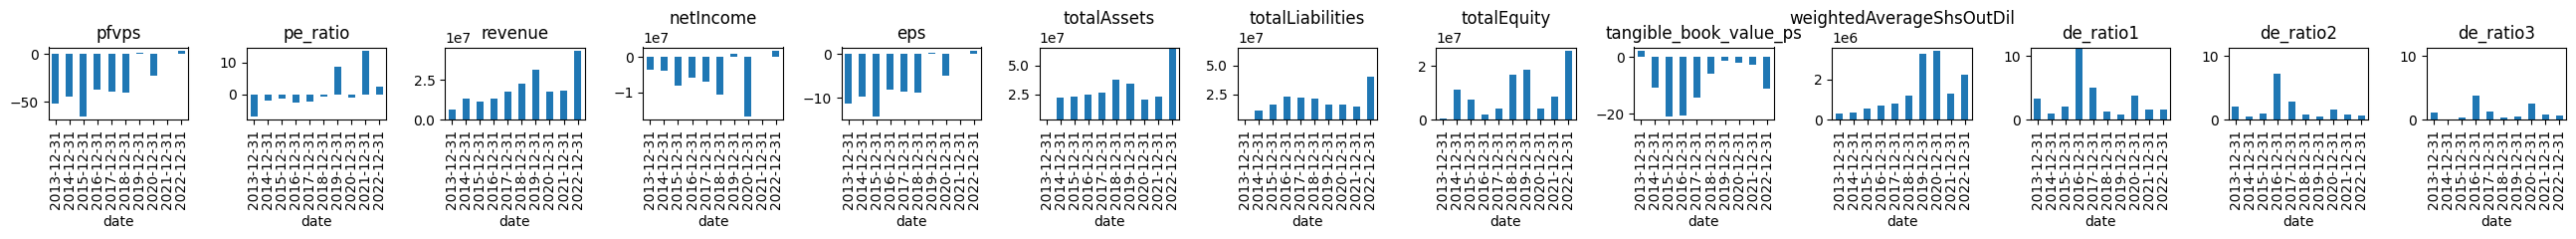

 69%|█████████████████████████████████████████████████████████████████████████████▌                                  | 1035/1495 [1:28:43<1:07:27,  8.80s/it]

length equals zero
less than 5 reports


 69%|██████████████████████████████████████████████████████████████████████████████▉                                   | 1036/1495 [1:28:45<52:42,  6.89s/it]

NRG.	 Current price: 38.52.	 Faire price: 40.79296936286521


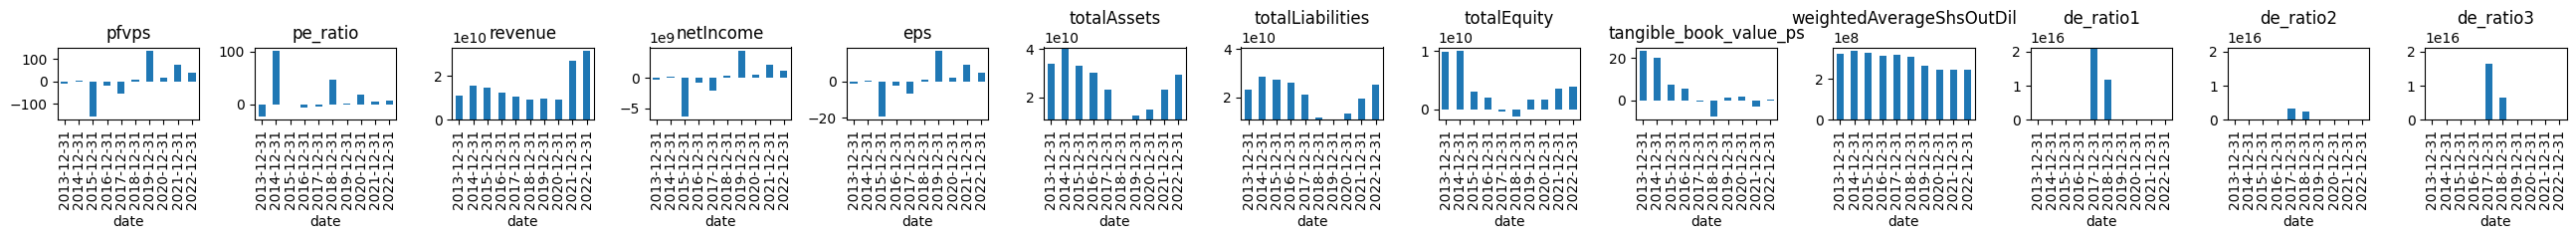

 69%|█████████████████████████████████████████████████████████████████████████████▋                                  | 1037/1495 [1:29:07<1:26:39, 11.35s/it]

length equals zero
less than 5 reports


 69%|█████████████████████████████████████████████████████████████████████████████▊                                  | 1038/1495 [1:29:09<1:06:07,  8.68s/it]

negative growth


 69%|███████████████████████████████████████████████████████████████████████████████▏                                  | 1039/1495 [1:29:12<51:35,  6.79s/it]

negative growth


 70%|███████████████████████████████████████████████████████████████████████████████▎                                  | 1040/1495 [1:29:14<41:28,  5.47s/it]

length equals zero
less than 5 reports


 70%|███████████████████████████████████████████████████████████████████████████████▍                                  | 1041/1495 [1:29:16<34:30,  4.56s/it]

length equals zero
less than 5 reports


 70%|███████████████████████████████████████████████████████████████████████████████▍                                  | 1042/1495 [1:29:19<29:37,  3.92s/it]

ACNT.	 Current price: 8.87.	 Faire price: 10.92734044872143


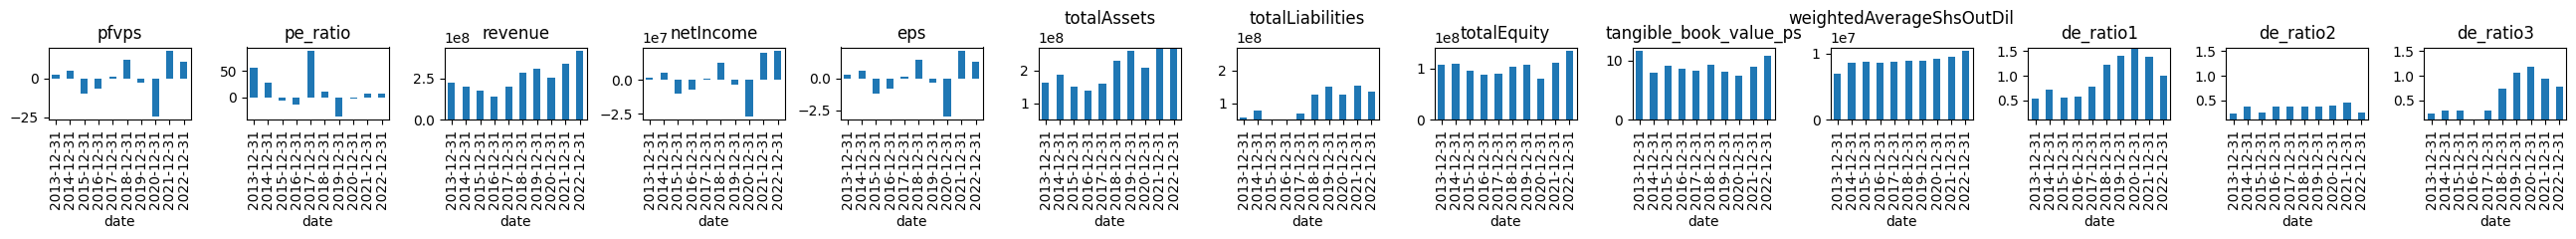

 70%|██████████████████████████████████████████████████████████████████████████████▏                                 | 1043/1495 [1:29:39<1:06:35,  8.84s/it]

length equals zero
less than 5 reports


 70%|███████████████████████████████████████████████████████████████████████████████▌                                  | 1044/1495 [1:29:42<52:00,  6.92s/it]

only negative pe in history


 70%|███████████████████████████████████████████████████████████████████████████████▋                                  | 1045/1495 [1:29:48<51:07,  6.82s/it]

less than 5 reports


 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 1046/1495 [1:29:51<41:55,  5.60s/it]

overvalued. price: None, pfvps: 26.349925853910854


 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 1047/1495 [1:30:02<54:35,  7.31s/it]

length equals zero
less than 5 reports


 70%|███████████████████████████████████████████████████████████████████████████████▉                                  | 1048/1495 [1:30:05<44:52,  6.02s/it]

length equals zero
less than 5 reports


 70%|███████████████████████████████████████████████████████████████████████████████▉                                  | 1049/1495 [1:30:08<36:46,  4.95s/it]

HSII.	 Current price: 25.02.	 Faire price: 37.31094101812764


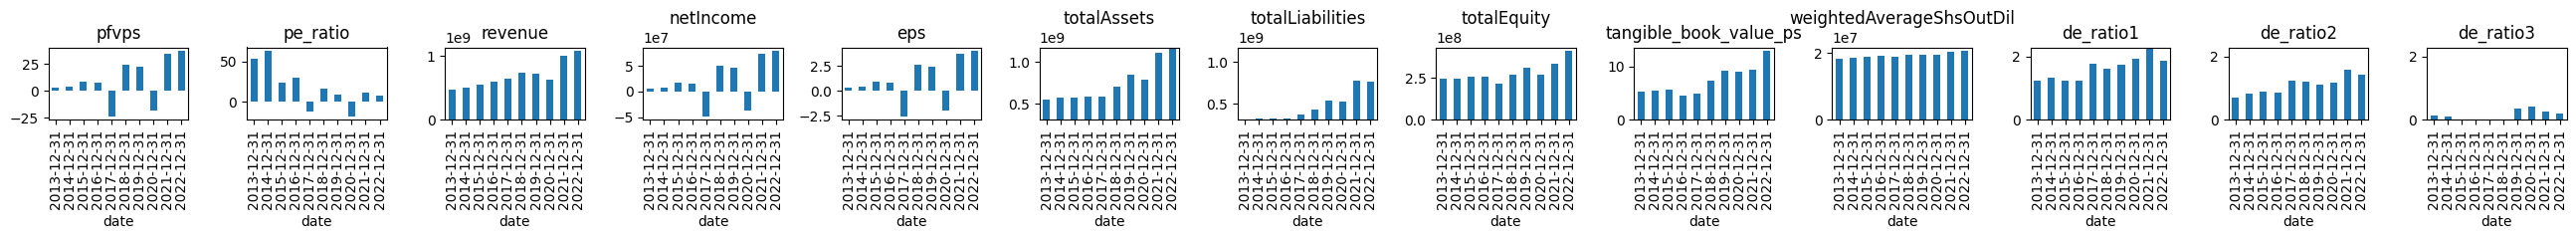

 70%|██████████████████████████████████████████████████████████████████████████████▋                                 | 1050/1495 [1:30:27<1:09:13,  9.33s/it]

only negative pe in history


 70%|██████████████████████████████████████████████████████████████████████████████▋                                 | 1051/1495 [1:30:37<1:08:58,  9.32s/it]

less than 5 reports


 70%|████████████████████████████████████████████████████████████████████████████████▏                                 | 1052/1495 [1:30:39<53:26,  7.24s/it]

negative growth


 70%|████████████████████████████████████████████████████████████████████████████████▎                                 | 1053/1495 [1:30:41<42:35,  5.78s/it]

length equals zero
less than 5 reports


 71%|████████████████████████████████████████████████████████████████████████████████▎                                 | 1054/1495 [1:30:44<35:04,  4.77s/it]

overvalued. price: 69.84, pfvps: 28.29247958500735


 71%|████████████████████████████████████████████████████████████████████████████████▍                                 | 1055/1495 [1:30:54<47:01,  6.41s/it]

length equals zero
less than 5 reports


 71%|████████████████████████████████████████████████████████████████████████████████▌                                 | 1056/1495 [1:30:56<38:11,  5.22s/it]

only negative pe in history


 71%|████████████████████████████████████████████████████████████████████████████████▌                                 | 1057/1495 [1:31:06<47:43,  6.54s/it]

negative growth


 71%|████████████████████████████████████████████████████████████████████████████████▋                                 | 1058/1495 [1:31:08<38:31,  5.29s/it]

less than 5 reports


 71%|████████████████████████████████████████████████████████████████████████████████▊                                 | 1059/1495 [1:31:11<32:24,  4.46s/it]

overvalued. price: 15.07, pfvps: 2.515847975325157


 71%|████████████████████████████████████████████████████████████████████████████████▊                                 | 1060/1495 [1:31:21<44:14,  6.10s/it]

overvalued. price: 45.52, pfvps: 10.316882134382194


 71%|████████████████████████████████████████████████████████████████████████████████▉                                 | 1061/1495 [1:31:31<53:49,  7.44s/it]

length equals zero
less than 5 reports


 71%|████████████████████████████████████████████████████████████████████████████████▉                                 | 1062/1495 [1:31:34<42:56,  5.95s/it]

length equals zero
less than 5 reports


 71%|█████████████████████████████████████████████████████████████████████████████████                                 | 1063/1495 [1:31:37<35:51,  4.98s/it]

only negative pe in history


 71%|█████████████████████████████████████████████████████████████████████████████████▏                                | 1064/1495 [1:31:45<43:32,  6.06s/it]

length equals zero
less than 5 reports


 71%|█████████████████████████████████████████████████████████████████████████████████▏                                | 1065/1495 [1:31:48<36:35,  5.11s/it]

only negative pe in history


 71%|█████████████████████████████████████████████████████████████████████████████████▎                                | 1066/1495 [1:31:58<46:37,  6.52s/it]

length equals zero
less than 5 reports


 71%|█████████████████████████████████████████████████████████████████████████████████▎                                | 1067/1495 [1:32:00<37:51,  5.31s/it]

negative growth


 71%|█████████████████████████████████████████████████████████████████████████████████▍                                | 1068/1495 [1:32:03<32:05,  4.51s/it]

negative growth


 72%|█████████████████████████████████████████████████████████████████████████████████▌                                | 1069/1495 [1:32:06<28:57,  4.08s/it]

overvalued. price: 13.37, pfvps: 5.162722328564956


 72%|█████████████████████████████████████████████████████████████████████████████████▌                                | 1070/1495 [1:32:18<45:04,  6.36s/it]

length equals zero
less than 5 reports


 72%|█████████████████████████████████████████████████████████████████████████████████▋                                | 1071/1495 [1:32:21<37:30,  5.31s/it]

length equals zero
less than 5 reports


 72%|█████████████████████████████████████████████████████████████████████████████████▋                                | 1072/1495 [1:32:24<32:41,  4.64s/it]

length equals zero
less than 5 reports


 72%|█████████████████████████████████████████████████████████████████████████████████▊                                | 1073/1495 [1:32:26<27:53,  3.97s/it]

length equals zero
less than 5 reports


 72%|█████████████████████████████████████████████████████████████████████████████████▉                                | 1074/1495 [1:32:29<25:50,  3.68s/it]

length equals zero
less than 5 reports


 72%|█████████████████████████████████████████████████████████████████████████████████▉                                | 1075/1495 [1:32:32<24:12,  3.46s/it]

length equals zero
less than 5 reports


 72%|██████████████████████████████████████████████████████████████████████████████████                                | 1076/1495 [1:32:35<22:02,  3.16s/it]

less than 5 reports


 72%|██████████████████████████████████████████████████████████████████████████████████▏                               | 1077/1495 [1:32:37<20:23,  2.93s/it]

overvalued. price: 95.43, pfvps: 19.618331598329757


 72%|██████████████████████████████████████████████████████████████████████████████████▏                               | 1078/1495 [1:32:48<37:59,  5.47s/it]

negative growth


 72%|██████████████████████████████████████████████████████████████████████████████████▎                               | 1079/1495 [1:32:51<31:28,  4.54s/it]

overvalued. price: None, pfvps: 1268.7468084785685


 72%|██████████████████████████████████████████████████████████████████████████████████▎                               | 1080/1495 [1:32:57<35:30,  5.13s/it]

length equals zero
less than 5 reports


 72%|██████████████████████████████████████████████████████████████████████████████████▍                               | 1081/1495 [1:33:00<30:50,  4.47s/it]

length equals zero
less than 5 reports


 72%|██████████████████████████████████████████████████████████████████████████████████▌                               | 1082/1495 [1:33:03<26:33,  3.86s/it]

length equals zero
less than 5 reports


 72%|██████████████████████████████████████████████████████████████████████████████████▌                               | 1083/1495 [1:33:05<23:33,  3.43s/it]

length equals zero
less than 5 reports


 73%|██████████████████████████████████████████████████████████████████████████████████▋                               | 1084/1495 [1:33:08<22:12,  3.24s/it]

overvalued. price: 12.51, pfvps: 0.0


 73%|██████████████████████████████████████████████████████████████████████████████████▋                               | 1085/1495 [1:33:19<37:28,  5.49s/it]

SM.	 Current price: 39.65.	 Faire price: 50.52255695534484


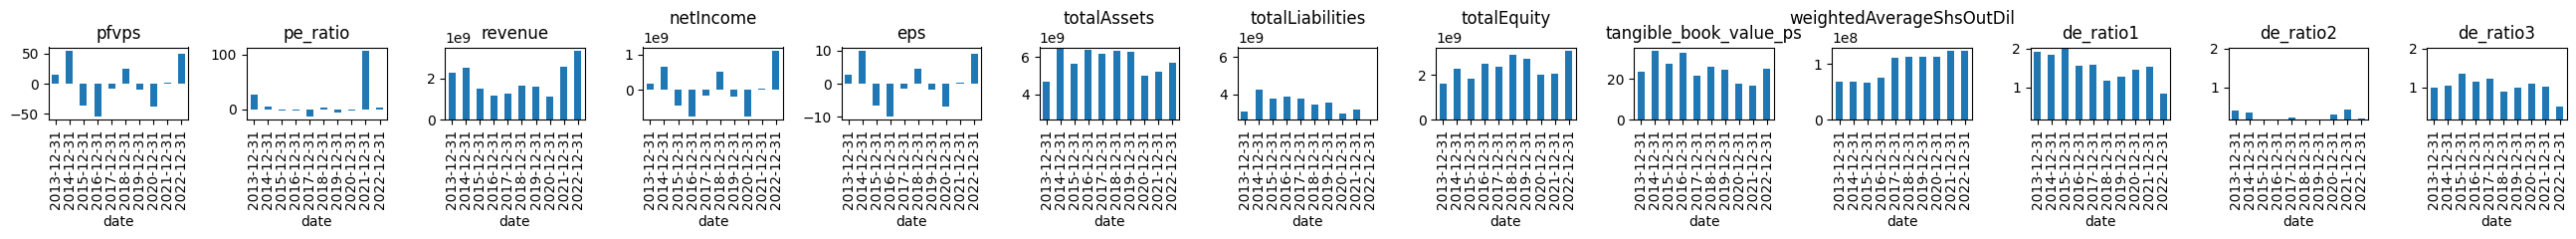

 73%|█████████████████████████████████████████████████████████████████████████████████▎                              | 1086/1495 [1:33:41<1:12:09, 10.58s/it]

less than 5 reports


 73%|██████████████████████████████████████████████████████████████████████████████████▉                               | 1087/1495 [1:33:43<55:16,  8.13s/it]

overvalued. price: 2.94, pfvps: 0.0202479316281753


 73%|█████████████████████████████████████████████████████████████████████████████████▌                              | 1088/1495 [1:33:55<1:01:41,  9.10s/it]

length equals zero
less than 5 reports


 73%|███████████████████████████████████████████████████████████████████████████████████                               | 1089/1495 [1:33:57<48:01,  7.10s/it]

length equals zero
less than 5 reports


 73%|███████████████████████████████████████████████████████████████████████████████████                               | 1090/1495 [1:34:00<38:27,  5.70s/it]

length equals zero
less than 5 reports


 73%|███████████████████████████████████████████████████████████████████████████████████▏                              | 1091/1495 [1:34:02<31:41,  4.71s/it]

length equals zero
less than 5 reports


 73%|███████████████████████████████████████████████████████████████████████████████████▎                              | 1092/1495 [1:34:04<27:04,  4.03s/it]

only negative pe in history


 73%|███████████████████████████████████████████████████████████████████████████████████▎                              | 1093/1495 [1:34:10<30:43,  4.59s/it]

length equals zero
less than 5 reports


 73%|███████████████████████████████████████████████████████████████████████████████████▍                              | 1094/1495 [1:34:13<27:34,  4.13s/it]

length equals zero
less than 5 reports


 73%|███████████████████████████████████████████████████████████████████████████████████▍                              | 1095/1495 [1:34:17<25:25,  3.81s/it]

less than 5 reports


 73%|███████████████████████████████████████████████████████████████████████████████████▌                              | 1096/1495 [1:34:19<22:32,  3.39s/it]

length equals zero
less than 5 reports


 73%|███████████████████████████████████████████████████████████████████████████████████▋                              | 1097/1495 [1:34:22<21:46,  3.28s/it]

overvalued. price: 1.415, pfvps: -663.8785368721622


 73%|███████████████████████████████████████████████████████████████████████████████████▋                              | 1098/1495 [1:34:33<38:05,  5.76s/it]

negative growth


 74%|███████████████████████████████████████████████████████████████████████████████████▊                              | 1099/1495 [1:34:36<32:20,  4.90s/it]

negative growth


 74%|███████████████████████████████████████████████████████████████████████████████████▉                              | 1100/1495 [1:34:39<27:17,  4.15s/it]

length equals zero
less than 5 reports


 74%|███████████████████████████████████████████████████████████████████████████████████▉                              | 1101/1495 [1:34:41<23:51,  3.63s/it]

length equals zero
less than 5 reports


 74%|████████████████████████████████████████████████████████████████████████████████████                              | 1102/1495 [1:34:44<21:55,  3.35s/it]

length equals zero
less than 5 reports


 74%|████████████████████████████████████████████████████████████████████████████████████                              | 1103/1495 [1:34:46<20:03,  3.07s/it]

length equals zero
less than 5 reports


 74%|████████████████████████████████████████████████████████████████████████████████████▏                             | 1104/1495 [1:34:49<19:03,  2.92s/it]

length equals zero
less than 5 reports


 74%|████████████████████████████████████████████████████████████████████████████████████▎                             | 1105/1495 [1:34:51<18:05,  2.78s/it]

length equals zero
less than 5 reports


 74%|████████████████████████████████████████████████████████████████████████████████████▎                             | 1106/1495 [1:34:54<17:22,  2.68s/it]

overvalued. price: 77.06, pfvps: 29.21452400463689


 74%|████████████████████████████████████████████████████████████████████████████████████▍                             | 1107/1495 [1:35:04<31:10,  4.82s/it]

length equals zero
less than 5 reports


 74%|████████████████████████████████████████████████████████████████████████████████████▍                             | 1108/1495 [1:35:06<26:28,  4.10s/it]

overvalued. price: 10.45, pfvps: -0.8933014638888744


 74%|████████████████████████████████████████████████████████████████████████████████████▌                             | 1109/1495 [1:35:16<37:52,  5.89s/it]

length equals zero
less than 5 reports


 74%|████████████████████████████████████████████████████████████████████████████████████▋                             | 1110/1495 [1:35:19<32:15,  5.03s/it]

length equals zero
less than 5 reports


 74%|████████████████████████████████████████████████████████████████████████████████████▋                             | 1111/1495 [1:35:22<27:14,  4.26s/it]

only negative pe in history


 74%|████████████████████████████████████████████████████████████████████████████████████▊                             | 1112/1495 [1:35:30<34:23,  5.39s/it]

less than 5 reports


 74%|████████████████████████████████████████████████████████████████████████████████████▊                             | 1113/1495 [1:35:32<29:16,  4.60s/it]

overvalued. price: 0.307, pfvps: 0.0


 75%|████████████████████████████████████████████████████████████████████████████████████▉                             | 1114/1495 [1:35:39<33:38,  5.30s/it]

negative growth


 75%|█████████████████████████████████████████████████████████████████████████████████████                             | 1115/1495 [1:35:42<29:20,  4.63s/it]

length equals zero
less than 5 reports


 75%|█████████████████████████████████████████████████████████████████████████████████████                             | 1116/1495 [1:35:45<25:07,  3.98s/it]

overvalued. price: 12.91, pfvps: 2.649705069101047


 75%|█████████████████████████████████████████████████████████████████████████████████████▏                            | 1117/1495 [1:35:56<38:23,  6.09s/it]

length equals zero
less than 5 reports


 75%|█████████████████████████████████████████████████████████████████████████████████████▎                            | 1118/1495 [1:35:59<32:27,  5.17s/it]

length equals zero
less than 5 reports


 75%|█████████████████████████████████████████████████████████████████████████████████████▎                            | 1119/1495 [1:36:01<27:12,  4.34s/it]

negative growth


 75%|█████████████████████████████████████████████████████████████████████████████████████▍                            | 1120/1495 [1:36:04<24:38,  3.94s/it]

negative growth


 75%|█████████████████████████████████████████████████████████████████████████████████████▍                            | 1121/1495 [1:36:07<21:40,  3.48s/it]

overvalued. price: 9.075, pfvps: -9.68387871793393


 75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 1122/1495 [1:36:19<37:39,  6.06s/it]

length equals zero
less than 5 reports


 75%|█████████████████████████████████████████████████████████████████████████████████████▋                            | 1123/1495 [1:36:21<30:50,  4.98s/it]

length equals zero
less than 5 reports


 75%|█████████████████████████████████████████████████████████████████████████████████████▋                            | 1124/1495 [1:36:24<26:09,  4.23s/it]

length equals zero
less than 5 reports


 75%|█████████████████████████████████████████████████████████████████████████████████████▊                            | 1125/1495 [1:36:26<22:48,  3.70s/it]

NVR.	 Current price: 5963.3.	 Faire price: 7082.835529075755


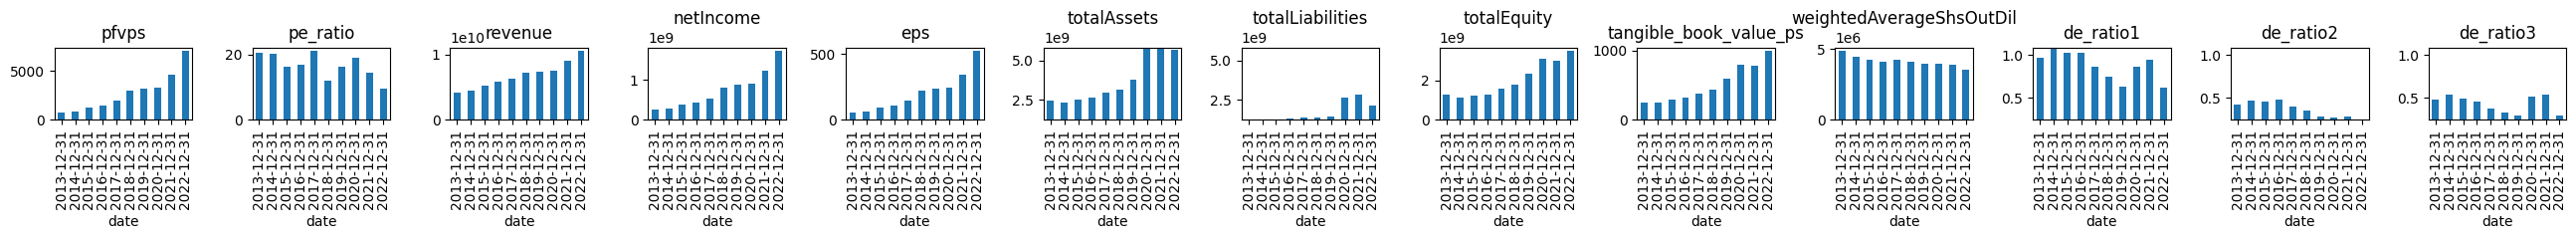

 75%|█████████████████████████████████████████████████████████████████████████████████████▊                            | 1126/1495 [1:36:45<50:40,  8.24s/it]

negative growth


 75%|█████████████████████████████████████████████████████████████████████████████████████▉                            | 1127/1495 [1:36:47<39:47,  6.49s/it]

length equals zero
less than 5 reports


 75%|██████████████████████████████████████████████████████████████████████████████████████                            | 1128/1495 [1:36:50<32:19,  5.28s/it]

length equals zero
less than 5 reports


 76%|██████████████████████████████████████████████████████████████████████████████████████                            | 1129/1495 [1:36:53<27:41,  4.54s/it]

only negative pe in history


 76%|██████████████████████████████████████████████████████████████████████████████████████▏                           | 1130/1495 [1:37:03<37:56,  6.24s/it]

length equals zero
less than 5 reports


 76%|██████████████████████████████████████████████████████████████████████████████████████▏                           | 1131/1495 [1:37:06<31:51,  5.25s/it]

negative growth


 76%|██████████████████████████████████████████████████████████████████████████████████████▎                           | 1132/1495 [1:37:08<26:33,  4.39s/it]

length equals zero
less than 5 reports


 76%|██████████████████████████████████████████████████████████████████████████████████████▍                           | 1133/1495 [1:37:11<22:59,  3.81s/it]

negative growth


 76%|██████████████████████████████████████████████████████████████████████████████████████▍                           | 1134/1495 [1:37:13<20:22,  3.39s/it]

overvalued. price: 7.56, pfvps: -19.164002653523944


 76%|██████████████████████████████████████████████████████████████████████████████████████▌                           | 1135/1495 [1:37:24<34:46,  5.80s/it]

length equals zero
less than 5 reports


 76%|██████████████████████████████████████████████████████████████████████████████████████▌                           | 1136/1495 [1:37:28<29:56,  5.00s/it]

overvalued. price: 18.59, pfvps: 5.03708148165881


 76%|██████████████████████████████████████████████████████████████████████████████████████▋                           | 1137/1495 [1:37:38<38:44,  6.49s/it]

length equals zero
less than 5 reports


 76%|██████████████████████████████████████████████████████████████████████████████████████▊                           | 1138/1495 [1:37:40<31:43,  5.33s/it]

length equals zero
less than 5 reports


 76%|██████████████████████████████████████████████████████████████████████████████████████▊                           | 1139/1495 [1:37:43<26:32,  4.47s/it]

less than 5 reports


 76%|██████████████████████████████████████████████████████████████████████████████████████▉                           | 1140/1495 [1:37:46<23:40,  4.00s/it]

length equals zero
less than 5 reports


 76%|███████████████████████████████████████████████████████████████████████████████████████                           | 1141/1495 [1:37:48<20:54,  3.54s/it]

length equals zero
less than 5 reports


 76%|███████████████████████████████████████████████████████████████████████████████████████                           | 1142/1495 [1:37:51<20:19,  3.46s/it]

length equals zero
less than 5 reports


 76%|███████████████████████████████████████████████████████████████████████████████████████▏                          | 1143/1495 [1:37:54<18:27,  3.15s/it]

length equals zero
less than 5 reports


 77%|███████████████████████████████████████████████████████████████████████████████████████▏                          | 1144/1495 [1:37:57<18:06,  3.09s/it]

only negative pe in history


 77%|███████████████████████████████████████████████████████████████████████████████████████▎                          | 1145/1495 [1:38:06<29:26,  5.05s/it]

length equals zero
less than 5 reports


 77%|███████████████████████████████████████████████████████████████████████████████████████▍                          | 1146/1495 [1:38:09<24:51,  4.27s/it]

negative growth


 77%|███████████████████████████████████████████████████████████████████████████████████████▍                          | 1147/1495 [1:38:12<22:08,  3.82s/it]

length equals zero
less than 5 reports


 77%|███████████████████████████████████████████████████████████████████████████████████████▌                          | 1148/1495 [1:38:15<21:10,  3.66s/it]

overvalued. price: 9.51, pfvps: 1.3875419156935231


 77%|███████████████████████████████████████████████████████████████████████████████████████▌                          | 1149/1495 [1:38:22<27:21,  4.75s/it]

overvalued. price: 6.42, pfvps: -3.9409990071030494


 77%|███████████████████████████████████████████████████████████████████████████████████████▋                          | 1150/1495 [1:38:35<40:39,  7.07s/it]

length equals zero
less than 5 reports


 77%|███████████████████████████████████████████████████████████████████████████████████████▊                          | 1151/1495 [1:38:37<32:35,  5.68s/it]

WDLF.	 Current price: 0.00055.	 Faire price: 0.0017706444525403776


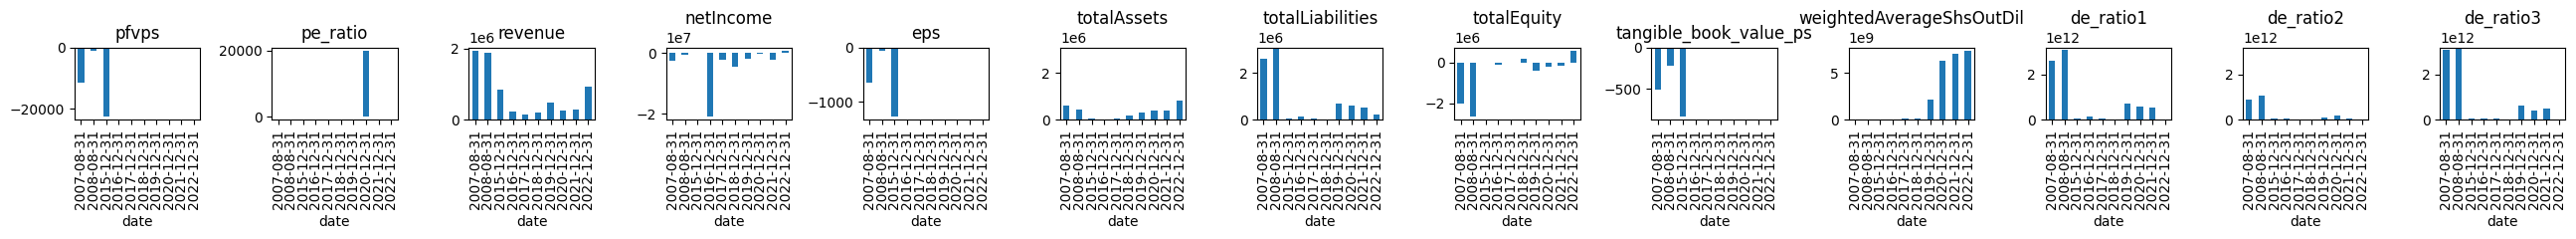

 77%|███████████████████████████████████████████████████████████████████████████████████████▊                          | 1152/1495 [1:38:57<57:17, 10.02s/it]

overvalued. price: 2.26, pfvps: -0.07547830736818358


 77%|██████████████████████████████████████████████████████████████████████████████████████▍                         | 1153/1495 [1:39:09<1:01:01, 10.71s/it]

overvalued. price: 2.78, pfvps: 0.47642349759350566


 77%|██████████████████████████████████████████████████████████████████████████████████████▍                         | 1154/1495 [1:39:21<1:01:39, 10.85s/it]

only negative pe in history


 77%|████████████████████████████████████████████████████████████████████████████████████████                          | 1155/1495 [1:39:30<59:28, 10.50s/it]

length equals zero
less than 5 reports


 77%|████████████████████████████████████████████████████████████████████████████████████████▏                         | 1156/1495 [1:39:33<45:35,  8.07s/it]

overvalued. price: 2.01, pfvps: -4.040123319484826


 77%|████████████████████████████████████████████████████████████████████████████████████████▏                         | 1157/1495 [1:39:44<51:06,  9.07s/it]

length equals zero
less than 5 reports


 77%|████████████████████████████████████████████████████████████████████████████████████████▎                         | 1158/1495 [1:39:47<39:45,  7.08s/it]

less than 5 reports


 78%|████████████████████████████████████████████████████████████████████████████████████████▍                         | 1159/1495 [1:39:50<32:41,  5.84s/it]

only negative pe in history


 78%|████████████████████████████████████████████████████████████████████████████████████████▍                         | 1160/1495 [1:39:59<38:31,  6.90s/it]

length equals zero
less than 5 reports


 78%|████████████████████████████████████████████████████████████████████████████████████████▌                         | 1161/1495 [1:40:01<30:58,  5.57s/it]

length equals zero
less than 5 reports


 78%|████████████████████████████████████████████████████████████████████████████████████████▌                         | 1162/1495 [1:40:04<25:41,  4.63s/it]

overvalued. price: 3.9089, pfvps: 0.18577833376069125


 78%|████████████████████████████████████████████████████████████████████████████████████████▋                         | 1163/1495 [1:40:14<34:39,  6.26s/it]

less than 5 reports


 78%|████████████████████████████████████████████████████████████████████████████████████████▊                         | 1164/1495 [1:40:16<28:09,  5.10s/it]

negative growth


 78%|████████████████████████████████████████████████████████████████████████████████████████▊                         | 1165/1495 [1:40:19<23:34,  4.29s/it]

overvalued. price: 0.52, pfvps: -5.684339813003935


 78%|████████████████████████████████████████████████████████████████████████████████████████▉                         | 1166/1495 [1:40:29<32:56,  6.01s/it]

overvalued. price: 0.5448, pfvps: -0.005495788657657933


 78%|████████████████████████████████████████████████████████████████████████████████████████▉                         | 1167/1495 [1:40:39<40:23,  7.39s/it]

only negative pe in history


 78%|█████████████████████████████████████████████████████████████████████████████████████████                         | 1168/1495 [1:40:50<45:01,  8.26s/it]

length equals zero
less than 5 reports


 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                        | 1169/1495 [1:40:52<36:08,  6.65s/it]

length equals zero
less than 5 reports


 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                        | 1170/1495 [1:40:56<30:09,  5.57s/it]

overvalued. price: 39.41, pfvps: -5.226041349320839


 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                        | 1171/1495 [1:41:07<40:23,  7.48s/it]

overvalued. price: 15.32, pfvps: -0.20269646699368477


 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                        | 1172/1495 [1:41:17<44:21,  8.24s/it]

length equals zero
less than 5 reports


 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                        | 1173/1495 [1:41:21<36:06,  6.73s/it]

overvalued. price: 0.6, pfvps: -0.4273178047124367


 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                        | 1174/1495 [1:41:33<44:28,  8.31s/it]

length equals zero
less than 5 reports


 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                        | 1175/1495 [1:41:36<35:54,  6.73s/it]

length equals zero
less than 5 reports


 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                        | 1176/1495 [1:41:38<29:00,  5.46s/it]

length equals zero
less than 5 reports


 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                        | 1177/1495 [1:41:41<24:05,  4.55s/it]

less than 5 reports


 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                        | 1178/1495 [1:41:44<21:27,  4.06s/it]

STC.	 Current price: 43.8.	 Faire price: 52.55497226680596


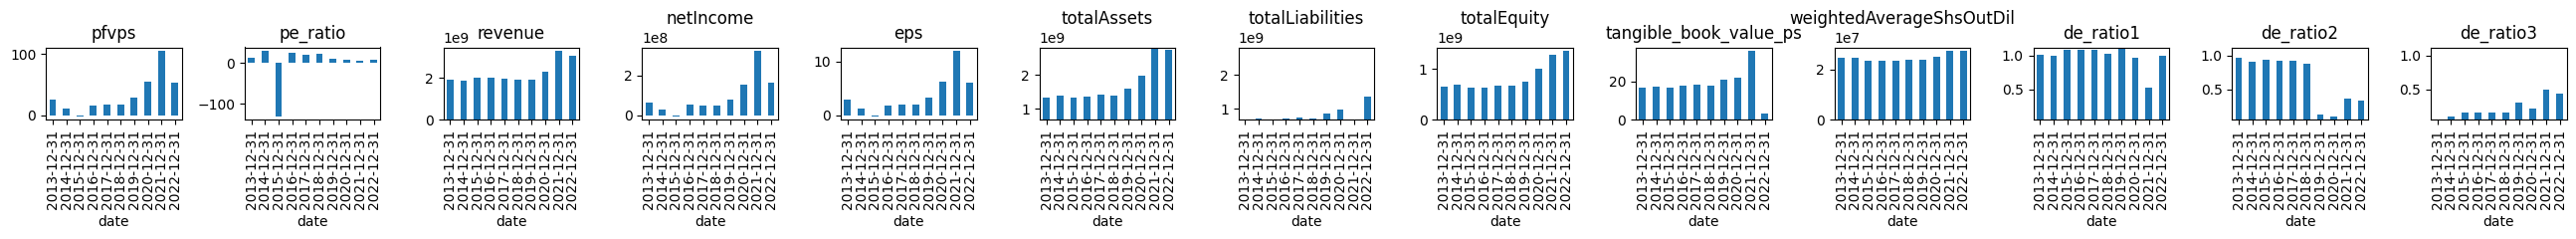

 79%|█████████████████████████████████████████████████████████████████████████████████████████▉                        | 1179/1495 [1:42:03<46:19,  8.80s/it]

negative growth


 79%|█████████████████████████████████████████████████████████████████████████████████████████▉                        | 1180/1495 [1:42:06<37:07,  7.07s/it]

length equals zero
less than 5 reports


 79%|██████████████████████████████████████████████████████████████████████████████████████████                        | 1181/1495 [1:42:09<29:45,  5.69s/it]

length equals zero
less than 5 reports


 79%|██████████████████████████████████████████████████████████████████████████████████████████▏                       | 1182/1495 [1:42:12<24:54,  4.78s/it]

negative growth


 79%|██████████████████████████████████████████████████████████████████████████████████████████▏                       | 1183/1495 [1:42:14<21:08,  4.06s/it]

length equals zero
less than 5 reports


 79%|██████████████████████████████████████████████████████████████████████████████████████████▎                       | 1184/1495 [1:42:17<19:14,  3.71s/it]

length equals zero
less than 5 reports


 79%|██████████████████████████████████████████████████████████████████████████████████████████▎                       | 1185/1495 [1:42:19<17:27,  3.38s/it]

less than 5 reports


 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                       | 1186/1495 [1:42:22<16:21,  3.18s/it]

length equals zero
less than 5 reports


 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                       | 1187/1495 [1:42:25<15:11,  2.96s/it]

length equals zero
less than 5 reports


 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                       | 1188/1495 [1:42:27<14:38,  2.86s/it]

negative growth


 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                       | 1189/1495 [1:42:30<14:54,  2.92s/it]

length equals zero
less than 5 reports


 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                       | 1190/1495 [1:42:33<15:14,  3.00s/it]

length equals zero
less than 5 reports


 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                       | 1191/1495 [1:42:37<15:18,  3.02s/it]

length equals zero
less than 5 reports


 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                       | 1192/1495 [1:42:39<14:24,  2.85s/it]

length equals zero
less than 5 reports


 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                       | 1193/1495 [1:42:41<13:44,  2.73s/it]

length equals zero
less than 5 reports


 80%|███████████████████████████████████████████████████████████████████████████████████████████                       | 1194/1495 [1:42:45<14:13,  2.83s/it]

RLGT.	 Current price: 5.65.	 Faire price: 10.595072194851735


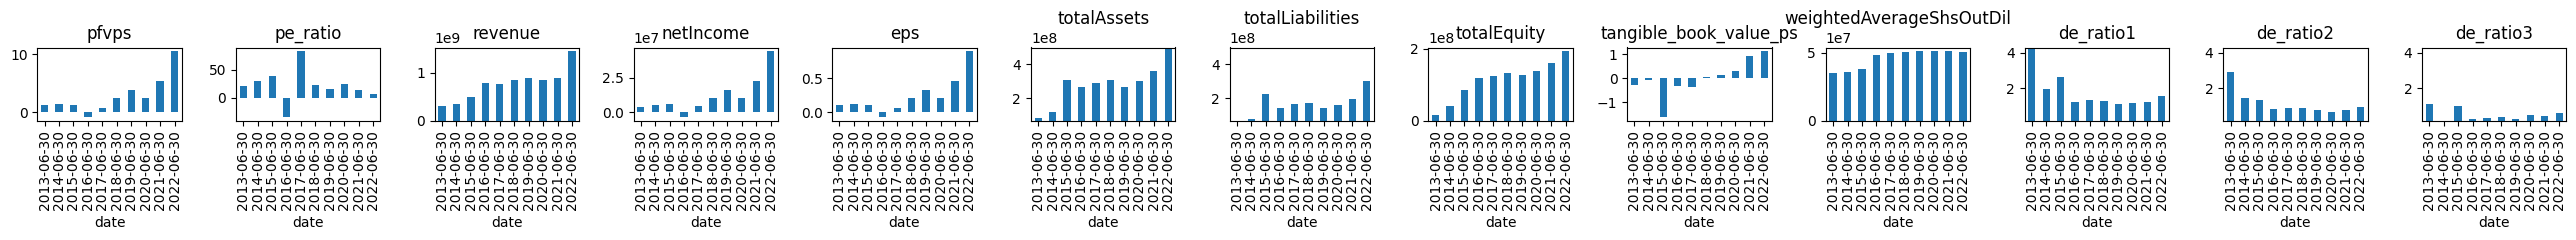

 80%|███████████████████████████████████████████████████████████████████████████████████████████                       | 1195/1495 [1:43:05<40:21,  8.07s/it]

length equals zero
less than 5 reports


 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 1196/1495 [1:43:07<31:48,  6.38s/it]

less than 5 reports


 80%|███████████████████████████████████████████████████████████████████████████████████████████▎                      | 1197/1495 [1:43:10<25:53,  5.21s/it]

length equals zero
less than 5 reports


 80%|███████████████████████████████████████████████████████████████████████████████████████████▎                      | 1198/1495 [1:43:12<21:40,  4.38s/it]

overvalued. price: 1.1, pfvps: 0.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████▍                      | 1199/1495 [1:43:21<28:28,  5.77s/it]

negative growth


 80%|███████████████████████████████████████████████████████████████████████████████████████████▌                      | 1200/1495 [1:43:24<23:24,  4.76s/it]

length equals zero
less than 5 reports


 80%|███████████████████████████████████████████████████████████████████████████████████████████▌                      | 1201/1495 [1:43:26<20:33,  4.20s/it]

length equals zero
less than 5 reports


 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                      | 1202/1495 [1:43:29<18:27,  3.78s/it]

negative growth


 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                      | 1203/1495 [1:43:32<16:22,  3.36s/it]

overvalued. price: 0.43555, pfvps: 0.27050927136376296


 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                      | 1204/1495 [1:43:43<27:39,  5.70s/it]

overvalued. price: 39.06, pfvps: 12.342037668760296


 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                      | 1205/1495 [1:43:53<33:57,  7.03s/it]

overvalued. price: 67.51, pfvps: 27.059239528392755


 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                      | 1206/1495 [1:44:04<39:34,  8.22s/it]

overvalued. price: 43.01, pfvps: 18.371093754817323


 81%|████████████████████████████████████████████████████████████████████████████████████████████                      | 1207/1495 [1:44:14<42:29,  8.85s/it]

length equals zero
less than 5 reports


 81%|████████████████████████████████████████████████████████████████████████████████████████████                      | 1208/1495 [1:44:17<33:10,  6.94s/it]

length equals zero
less than 5 reports


 81%|████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1209/1495 [1:44:20<27:27,  5.76s/it]

negative growth


 81%|████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1210/1495 [1:44:23<23:17,  4.90s/it]

overvalued. price: 0.01315, pfvps: -0.005274639063572717


 81%|████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1211/1495 [1:44:33<30:19,  6.41s/it]

length equals zero
less than 5 reports


 81%|████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1212/1495 [1:44:35<24:39,  5.23s/it]

overvalued. price: 3.26, pfvps: -9.414071787837218


 81%|████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1213/1495 [1:44:45<31:32,  6.71s/it]

overvalued. price: 3.46, pfvps: -0.8006087852515533


 81%|████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1214/1495 [1:44:56<37:37,  8.03s/it]

length equals zero
less than 5 reports


 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1215/1495 [1:44:59<29:42,  6.37s/it]

length equals zero
less than 5 reports


 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1216/1495 [1:45:02<24:56,  5.36s/it]

length equals zero
less than 5 reports


 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1217/1495 [1:45:04<20:49,  4.49s/it]

negative growth


 81%|████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1218/1495 [1:45:07<18:11,  3.94s/it]

length equals zero
less than 5 reports


 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1219/1495 [1:45:10<16:56,  3.68s/it]

length equals zero
less than 5 reports


 82%|█████████████████████████████████████████████████████████████████████████████████████████████                     | 1220/1495 [1:45:13<16:18,  3.56s/it]

length equals zero
less than 5 reports


 82%|█████████████████████████████████████████████████████████████████████████████████████████████                     | 1221/1495 [1:45:16<14:41,  3.22s/it]

length equals zero
less than 5 reports


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1222/1495 [1:45:19<14:13,  3.13s/it]

length equals zero
less than 5 reports


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1223/1495 [1:45:21<13:19,  2.94s/it]

overvalued. price: 8.05, pfvps: -9.199616125765317


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1224/1495 [1:45:33<25:32,  5.65s/it]

negative growth


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1225/1495 [1:45:36<21:53,  4.86s/it]

overvalued. price: 1.21, pfvps: -8.49243278723604


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1226/1495 [1:45:48<31:47,  7.09s/it]

length equals zero
less than 5 reports


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1227/1495 [1:45:51<25:30,  5.71s/it]

overvalued. price: 21.54, pfvps: 10.442935874060712


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1228/1495 [1:46:01<31:50,  7.16s/it]

length equals zero
less than 5 reports


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1229/1495 [1:46:05<26:24,  5.96s/it]

overvalued. price: 4.34, pfvps: 2.4500444137526487


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1230/1495 [1:46:16<34:03,  7.71s/it]

length equals zero
less than 5 reports


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1231/1495 [1:46:19<26:59,  6.13s/it]

PGOL.	 Current price: 0.075.	 Faire price: 0.17273024481314447


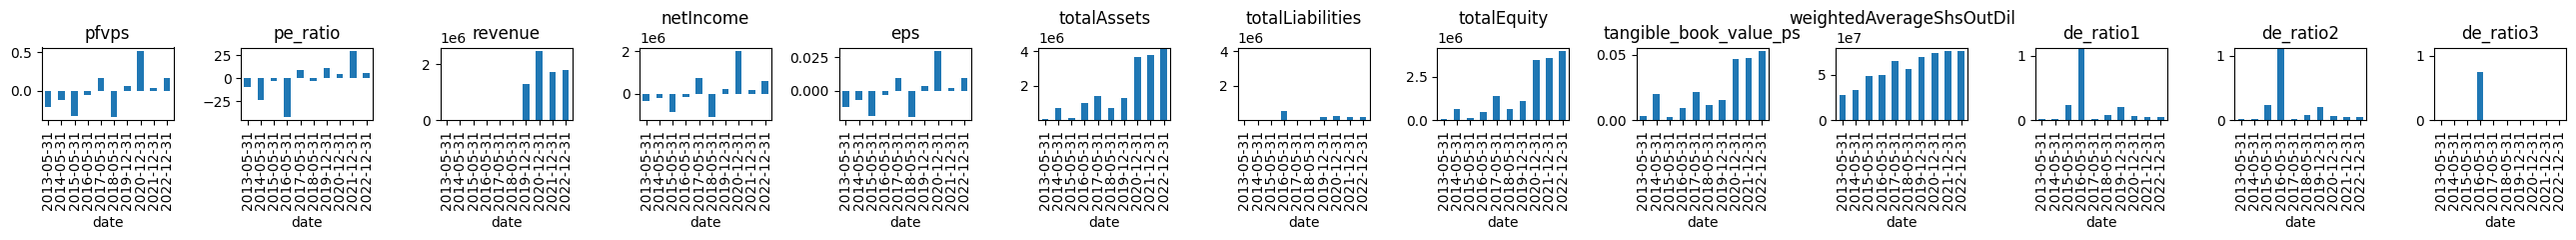

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1232/1495 [1:46:41<47:22, 10.81s/it]

length equals zero
less than 5 reports


 82%|██████████████████████████████████████████████████████████████████████████████████████████████                    | 1233/1495 [1:46:43<36:17,  8.31s/it]

only negative pe in history


 83%|██████████████████████████████████████████████████████████████████████████████████████████████                    | 1234/1495 [1:46:54<39:44,  9.14s/it]

length equals zero
less than 5 reports


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1235/1495 [1:46:57<31:21,  7.24s/it]

only negative pe in history


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1236/1495 [1:47:04<31:34,  7.32s/it]

length equals zero
less than 5 reports


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1237/1495 [1:47:07<25:13,  5.87s/it]

overvalued. price: 0.3302, pfvps: -0.007722118662398516


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1238/1495 [1:47:17<30:31,  7.13s/it]

negative growth


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1239/1495 [1:47:19<24:21,  5.71s/it]

overvalued. price: 75.22, pfvps: 35.32682194778065


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1240/1495 [1:47:31<32:06,  7.56s/it]

length equals zero
less than 5 reports


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1241/1495 [1:47:34<26:16,  6.21s/it]

overvalued. price: 2.39, pfvps: -13.190460938531082


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1242/1495 [1:47:45<32:04,  7.61s/it]

negative growth


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1243/1495 [1:47:48<25:22,  6.04s/it]

overvalued. price: 0.1839, pfvps: -6.593217149661289


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1244/1495 [1:48:00<33:18,  7.96s/it]

length equals zero
less than 5 reports


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1245/1495 [1:48:03<27:03,  6.49s/it]

length equals zero
less than 5 reports


 83%|███████████████████████████████████████████████████████████████████████████████████████████████                   | 1246/1495 [1:48:06<22:10,  5.34s/it]

length equals zero
less than 5 reports


 83%|███████████████████████████████████████████████████████████████████████████████████████████████                   | 1247/1495 [1:48:08<18:26,  4.46s/it]

negative growth


 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1248/1495 [1:48:11<15:48,  3.84s/it]

less than 5 reports


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1249/1495 [1:48:13<14:28,  3.53s/it]

length equals zero
less than 5 reports


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1250/1495 [1:48:16<13:04,  3.20s/it]

length equals zero
less than 5 reports


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1251/1495 [1:48:18<12:05,  2.97s/it]

JAKK.	 Current price: 18.59.	 Faire price: 24.356967775416408


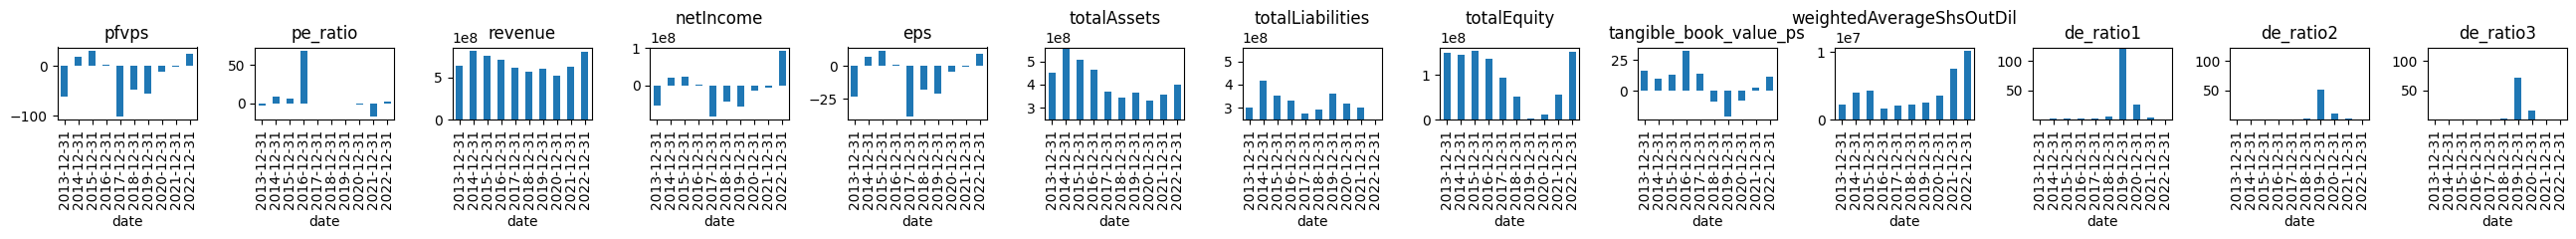

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1252/1495 [1:48:37<30:52,  7.62s/it]

length equals zero
less than 5 reports


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1253/1495 [1:48:39<24:28,  6.07s/it]

length equals zero
less than 5 reports


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1254/1495 [1:48:42<20:13,  5.04s/it]

overvalued. price: 36.25, pfvps: 33.046245916232905


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1255/1495 [1:48:53<28:06,  7.03s/it]

length equals zero
less than 5 reports


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1256/1495 [1:48:56<23:10,  5.82s/it]

overvalued. price: 13.05, pfvps: 6.768393743199805


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1257/1495 [1:49:07<28:18,  7.14s/it]

less than 5 reports


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1258/1495 [1:49:09<22:32,  5.71s/it]

length equals zero
less than 5 reports


 84%|████████████████████████████████████████████████████████████████████████████████████████████████                  | 1259/1495 [1:49:12<19:11,  4.88s/it]

length equals zero
less than 5 reports


 84%|████████████████████████████████████████████████████████████████████████████████████████████████                  | 1260/1495 [1:49:14<16:13,  4.14s/it]

negative growth


 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1261/1495 [1:49:17<14:09,  3.63s/it]

overvalued. price: 1.81, pfvps: -0.6976197572195737


 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1262/1495 [1:49:27<21:23,  5.51s/it]

length equals zero
less than 5 reports


 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1263/1495 [1:49:29<17:56,  4.64s/it]

length equals zero
less than 5 reports


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1264/1495 [1:49:32<15:19,  3.98s/it]

overvalued. price: 0.0031, pfvps: -0.0011108603097850606


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1265/1495 [1:49:41<20:57,  5.47s/it]

length equals zero
less than 5 reports


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1266/1495 [1:49:43<17:36,  4.61s/it]

length equals zero
less than 5 reports


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1267/1495 [1:49:46<15:20,  4.04s/it]

length equals zero
less than 5 reports


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1268/1495 [1:49:48<13:26,  3.55s/it]

length equals zero
less than 5 reports


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1269/1495 [1:49:51<12:08,  3.22s/it]

less than 5 reports


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1270/1495 [1:49:53<11:07,  2.97s/it]

overvalued. price: 3.02, pfvps: -29.958322199836143


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1271/1495 [1:50:00<15:05,  4.04s/it]

overvalued. price: 1.47, pfvps: -0.19238139443327668


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1272/1495 [1:50:09<20:25,  5.49s/it]

only negative pe in history


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████                 | 1273/1495 [1:50:20<26:37,  7.20s/it]

length equals zero
less than 5 reports


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1274/1495 [1:50:23<21:44,  5.90s/it]

length equals zero
less than 5 reports


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1275/1495 [1:50:25<17:48,  4.86s/it]

overvalued. price: 92.58, pfvps: 45.45080811955394


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1276/1495 [1:50:36<23:54,  6.55s/it]

less than 5 reports


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1277/1495 [1:50:38<19:19,  5.32s/it]

overvalued. price: 66.97, pfvps: 58.631833020155526


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1278/1495 [1:50:49<25:46,  7.13s/it]

length equals zero
less than 5 reports


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1279/1495 [1:50:52<20:36,  5.72s/it]

ASC.	 Current price: 13.01.	 Faire price: 29.936380192079017


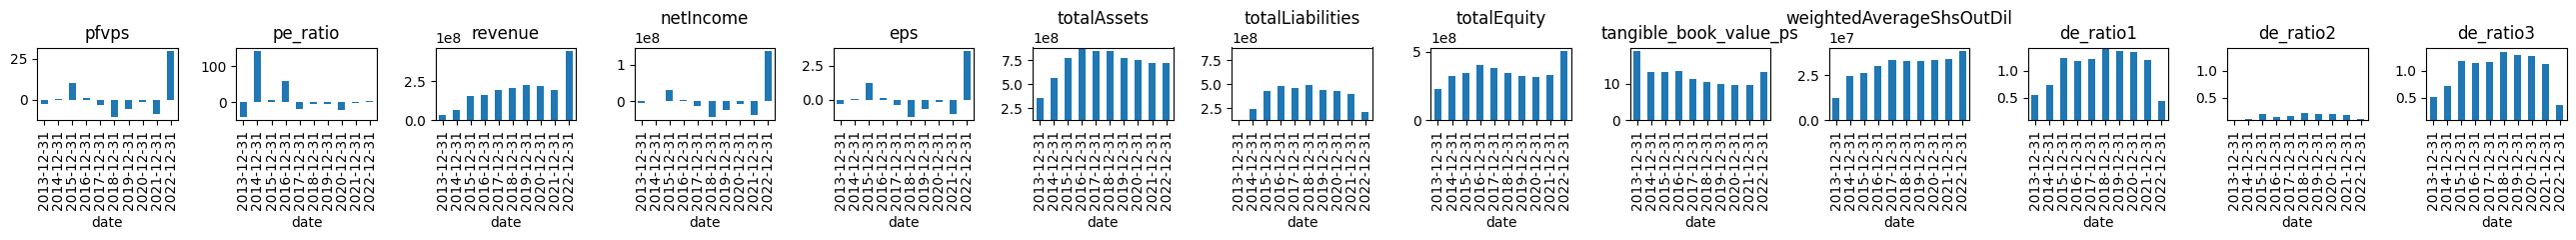

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1280/1495 [1:51:12<36:20, 10.14s/it]

less than 5 reports


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1281/1495 [1:51:15<28:11,  7.90s/it]

length equals zero
less than 5 reports


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1282/1495 [1:51:18<22:22,  6.30s/it]

PTSI.	 Current price: 21.55.	 Faire price: 54.550714579245565


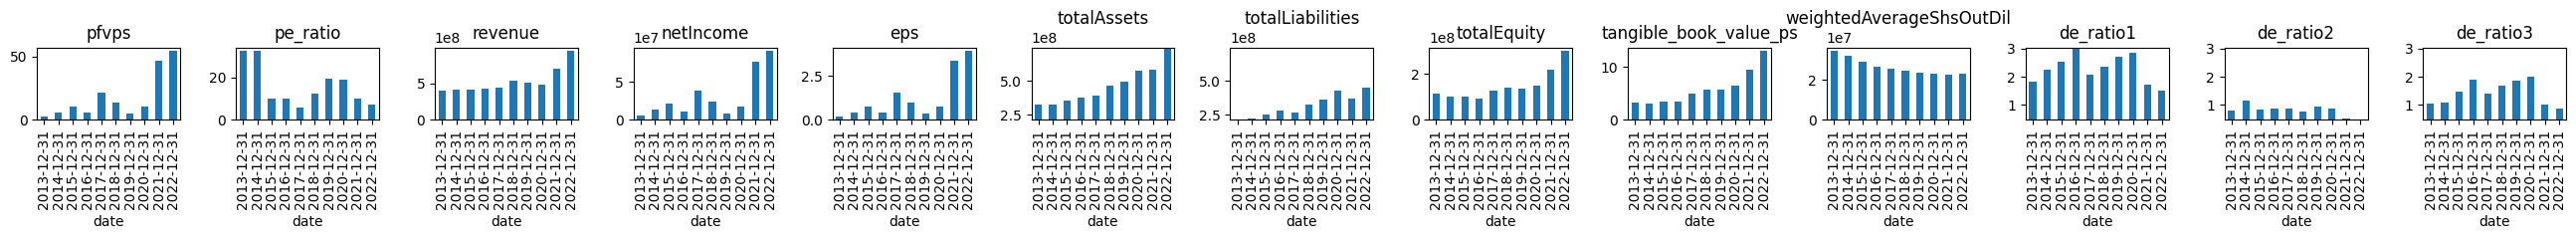

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1283/1495 [1:51:41<40:30, 11.47s/it]

less than 5 reports


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1284/1495 [1:51:44<31:08,  8.85s/it]

length equals zero
less than 5 reports


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1285/1495 [1:51:46<24:14,  6.93s/it]

negative growth


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████                | 1286/1495 [1:51:49<20:01,  5.75s/it]

negative growth


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1287/1495 [1:51:52<16:28,  4.75s/it]

only negative pe in history


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1288/1495 [1:52:03<23:08,  6.71s/it]

overvalued. price: 4.59, pfvps: -0.21273499221380432


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1289/1495 [1:52:13<26:22,  7.68s/it]

length equals zero
less than 5 reports


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1290/1495 [1:52:15<20:54,  6.12s/it]

negative growth


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1291/1495 [1:52:18<16:59,  5.00s/it]

less than 5 reports


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1292/1495 [1:52:21<14:43,  4.35s/it]

negative growth


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1293/1495 [1:52:23<12:49,  3.81s/it]

overvalued. price: 1.08, pfvps: 0.0863406799701079


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1294/1495 [1:52:35<21:05,  6.29s/it]

overvalued. price: 2.1, pfvps: -21.52467687081777


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1295/1495 [1:52:46<25:09,  7.55s/it]

less than 5 reports


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1296/1495 [1:52:48<20:09,  6.08s/it]

length equals zero
less than 5 reports


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1297/1495 [1:52:51<16:26,  4.98s/it]

negative growth


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1298/1495 [1:52:53<13:50,  4.21s/it]

length equals zero
less than 5 reports


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████               | 1299/1495 [1:52:56<12:01,  3.68s/it]

overvalued. price: 0.392, pfvps: -4.110149373603631


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1300/1495 [1:53:08<20:05,  6.18s/it]

length equals zero
less than 5 reports


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1301/1495 [1:53:10<16:30,  5.11s/it]

length equals zero
less than 5 reports


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1302/1495 [1:53:13<13:50,  4.30s/it]

length equals zero
less than 5 reports


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1303/1495 [1:53:16<12:28,  3.90s/it]

length equals zero
less than 5 reports


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1304/1495 [1:53:18<11:00,  3.46s/it]

only negative pe in history


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1305/1495 [1:53:29<18:03,  5.70s/it]

length equals zero
less than 5 reports


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1306/1495 [1:53:32<14:51,  4.72s/it]

less than 5 reports


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1307/1495 [1:53:35<13:14,  4.23s/it]

negative growth


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1308/1495 [1:53:37<11:31,  3.70s/it]

length equals zero
less than 5 reports


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1309/1495 [1:53:40<10:35,  3.42s/it]

length equals zero
less than 5 reports


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1310/1495 [1:53:42<09:36,  3.12s/it]

BRID.	 Current price: 10.95.	 Faire price: 69.69211187113912


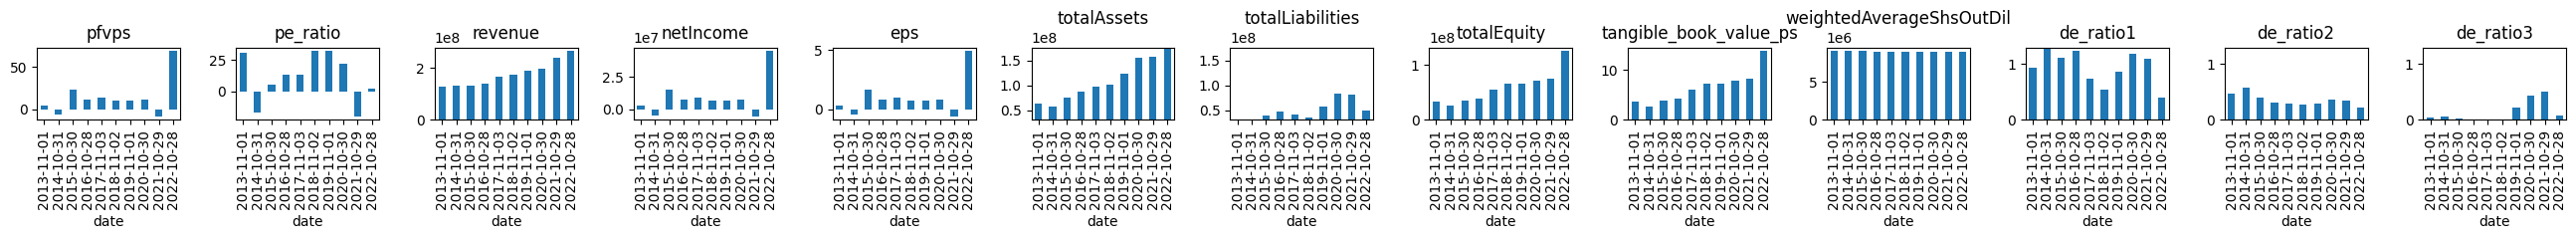

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1311/1495 [1:54:03<25:39,  8.37s/it]

length equals zero
less than 5 reports


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████              | 1312/1495 [1:54:05<20:04,  6.58s/it]

length equals zero
less than 5 reports


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████              | 1313/1495 [1:54:08<16:49,  5.55s/it]

less than 5 reports


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1314/1495 [1:54:11<14:19,  4.75s/it]

length equals zero
less than 5 reports


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1315/1495 [1:54:14<12:26,  4.15s/it]

overvalued. price: 0.1997, pfvps: -0.9794368645210105


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1316/1495 [1:54:26<19:10,  6.43s/it]

length equals zero
less than 5 reports


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1317/1495 [1:54:29<15:47,  5.32s/it]

negative growth


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1318/1495 [1:54:31<13:07,  4.45s/it]

length equals zero
less than 5 reports


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1319/1495 [1:54:33<11:17,  3.85s/it]

length equals zero
less than 5 reports


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1320/1495 [1:54:36<10:27,  3.58s/it]

overvalued. price: 12.99, pfvps: 6.786074798041093


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1321/1495 [1:54:46<15:57,  5.50s/it]

overvalued. price: 14.18, pfvps: 2.8719223080450305


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1322/1495 [1:54:55<18:54,  6.56s/it]

less than 5 reports


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1323/1495 [1:54:58<15:10,  5.30s/it]

length equals zero
less than 5 reports


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1324/1495 [1:55:00<12:37,  4.43s/it]

length equals zero
less than 5 reports


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████             | 1325/1495 [1:55:03<11:23,  4.02s/it]

length equals zero
less than 5 reports


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████             | 1326/1495 [1:55:06<10:01,  3.56s/it]

negative growth


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1327/1495 [1:55:09<09:32,  3.41s/it]

length equals zero
less than 5 reports


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1328/1495 [1:55:12<09:01,  3.24s/it]

overvalued. price: 0.8904, pfvps: -1.5709192149698303


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1329/1495 [1:55:22<15:00,  5.42s/it]

less than 5 reports


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1330/1495 [1:55:25<12:30,  4.55s/it]

overvalued. price: 0.14, pfvps: 0.039417598632178995


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1331/1495 [1:55:35<17:08,  6.27s/it]

less than 5 reports


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1332/1495 [1:55:37<13:50,  5.10s/it]

negative growth


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1333/1495 [1:55:40<11:32,  4.28s/it]

overvalued. price: 19.41, pfvps: 18.327611988615455


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1334/1495 [1:55:48<15:06,  5.63s/it]

only negative pe in history


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1335/1495 [1:55:59<18:38,  6.99s/it]

length equals zero
less than 5 reports


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1336/1495 [1:56:01<14:54,  5.62s/it]

overvalued. price: 1.35, pfvps: 0.8979020988337222


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1337/1495 [1:56:12<18:49,  7.15s/it]

negative growth


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████            | 1338/1495 [1:56:14<14:57,  5.72s/it]

overvalued. price: None, pfvps: 38.71940494791017


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████            | 1339/1495 [1:56:25<18:42,  7.20s/it]

length equals zero
less than 5 reports


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1340/1495 [1:56:27<15:03,  5.83s/it]

length equals zero
less than 5 reports


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1341/1495 [1:56:30<12:20,  4.81s/it]

only negative pe in history


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1342/1495 [1:56:39<15:35,  6.11s/it]

length equals zero
less than 5 reports


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1343/1495 [1:56:42<13:09,  5.19s/it]

length equals zero
less than 5 reports


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1344/1495 [1:56:45<11:04,  4.40s/it]

only negative pe in history


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1345/1495 [1:56:52<13:01,  5.21s/it]

less than 5 reports


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1346/1495 [1:56:54<10:49,  4.36s/it]

overvalued. price: 2.85, pfvps: 1.1448927534261215


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1347/1495 [1:57:04<14:59,  6.08s/it]

less than 5 reports


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1348/1495 [1:57:07<12:10,  4.97s/it]

length equals zero
less than 5 reports


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1349/1495 [1:57:09<10:13,  4.21s/it]

less than 5 reports


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1350/1495 [1:57:12<09:15,  3.83s/it]

length equals zero
less than 5 reports


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████           | 1351/1495 [1:57:15<08:35,  3.58s/it]

length equals zero
less than 5 reports


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████           | 1352/1495 [1:57:17<07:41,  3.23s/it]

length equals zero
less than 5 reports


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1353/1495 [1:57:20<07:29,  3.16s/it]

length equals zero
less than 5 reports


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1354/1495 [1:57:23<06:56,  2.96s/it]

only negative pe in history


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1355/1495 [1:57:29<08:50,  3.79s/it]

length equals zero
less than 5 reports


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1356/1495 [1:57:31<07:50,  3.38s/it]

overvalued. price: 0.0024, pfvps: 0.0


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1357/1495 [1:57:42<12:45,  5.55s/it]

length equals zero
less than 5 reports


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1358/1495 [1:57:44<10:35,  4.64s/it]

length equals zero
less than 5 reports


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1359/1495 [1:57:46<08:59,  3.97s/it]

length equals zero
less than 5 reports


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1360/1495 [1:57:49<07:53,  3.51s/it]

length equals zero
less than 5 reports


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1361/1495 [1:57:51<07:07,  3.19s/it]

length equals zero
less than 5 reports


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1362/1495 [1:57:54<06:41,  3.02s/it]

overvalued. price: 168.62, pfvps: 103.53670619391603


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1363/1495 [1:58:04<11:13,  5.10s/it]

overvalued. price: 19.9, pfvps: 0.9396074734107227


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1364/1495 [1:58:15<14:54,  6.83s/it]

length equals zero
less than 5 reports


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1365/1495 [1:58:17<11:56,  5.51s/it]

less than 5 reports


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1366/1495 [1:58:20<09:50,  4.58s/it]

less than 5 reports


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1367/1495 [1:58:22<08:21,  3.92s/it]

length equals zero
less than 5 reports


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1368/1495 [1:58:25<07:36,  3.59s/it]

CMBM.	 Current price: 7.33.	 Faire price: 10.292891785314906


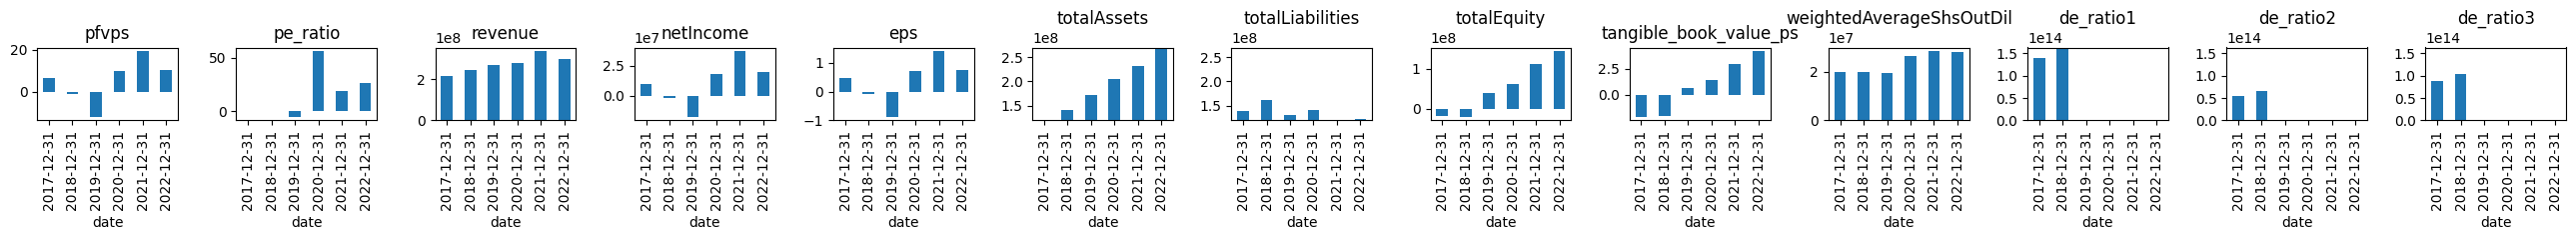

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1369/1495 [1:58:39<13:57,  6.65s/it]

negative growth


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1370/1495 [1:58:41<11:20,  5.44s/it]

CAN.	 Current price: 1.82.	 Faire price: 247.70776391746682


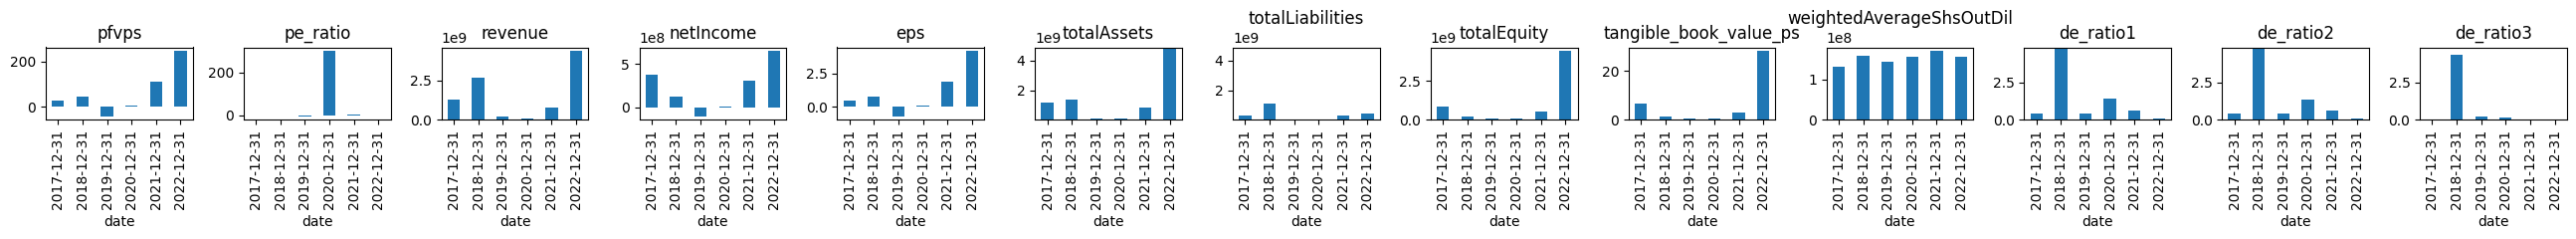

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1371/1495 [1:58:55<16:13,  7.85s/it]

length equals zero
less than 5 reports


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1372/1495 [1:58:57<12:49,  6.26s/it]

length equals zero
less than 5 reports


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1373/1495 [1:59:00<10:22,  5.10s/it]

overvalued. price: 25.23, pfvps: -1.9864958523726346


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1374/1495 [1:59:11<13:48,  6.85s/it]

length equals zero
less than 5 reports


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1375/1495 [1:59:13<11:01,  5.51s/it]

negative growth


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1376/1495 [1:59:15<09:03,  4.56s/it]

only negative pe in history


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1377/1495 [1:59:21<09:40,  4.92s/it]

length equals zero
less than 5 reports


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1378/1495 [1:59:24<08:12,  4.21s/it]

length equals zero
less than 5 reports


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1379/1495 [1:59:26<07:05,  3.67s/it]

only negative pe in history


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1380/1495 [1:59:32<08:12,  4.29s/it]

negative growth


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1381/1495 [1:59:34<07:03,  3.71s/it]

overvalued. price: 4.4, pfvps: 2.700270194612696


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1382/1495 [1:59:44<10:44,  5.70s/it]

length equals zero
less than 5 reports


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1383/1495 [1:59:47<08:47,  4.71s/it]

negative growth


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1384/1495 [1:59:49<07:24,  4.01s/it]

negative growth


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1385/1495 [1:59:52<06:38,  3.62s/it]

length equals zero
less than 5 reports


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1386/1495 [1:59:54<05:56,  3.27s/it]

NIHK.	 Current price: 0.009.	 Faire price: 0.05395031679903061


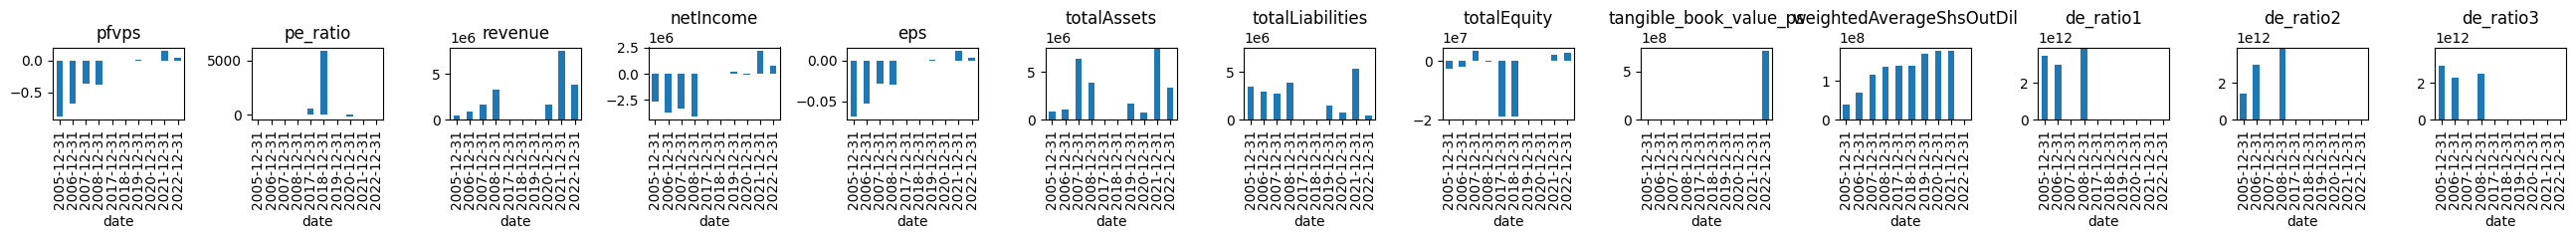

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1387/1495 [2:00:13<14:13,  7.90s/it]

length equals zero
less than 5 reports


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1388/1495 [2:00:16<11:11,  6.27s/it]

less than 5 reports


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1389/1495 [2:00:18<09:03,  5.13s/it]

length equals zero
less than 5 reports


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1390/1495 [2:00:20<07:33,  4.32s/it]

overvalued. price: 9.64, pfvps: 0.005331946938217941


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1391/1495 [2:00:32<11:01,  6.36s/it]

WGO.	 Current price: 59.45.	 Faire price: 332.85333814379453


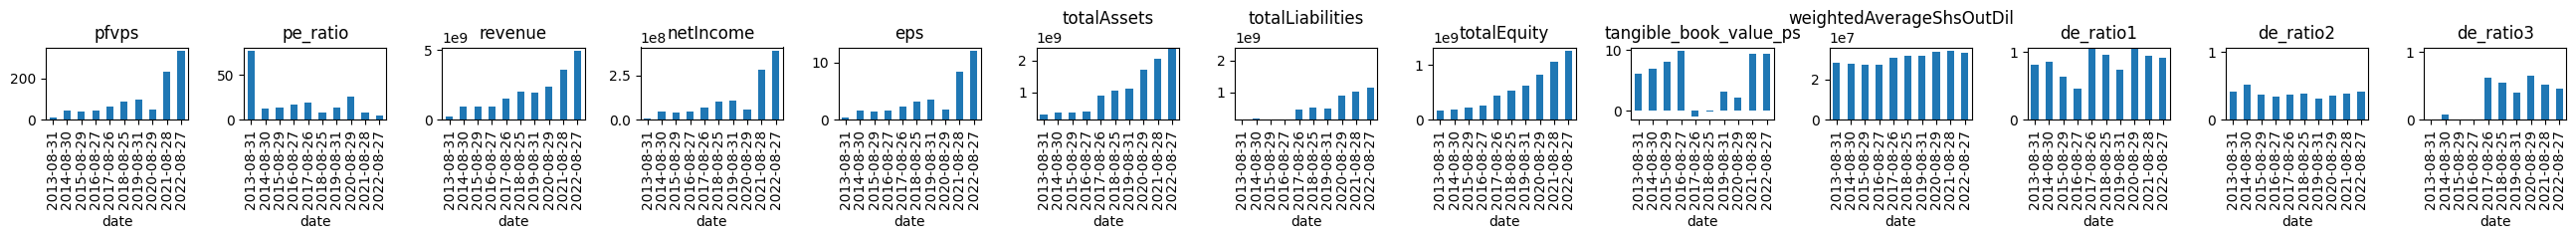

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1392/1495 [2:00:51<17:52, 10.41s/it]

negative growth


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1393/1495 [2:00:55<13:57,  8.21s/it]

length equals zero
less than 5 reports


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1394/1495 [2:00:57<11:04,  6.58s/it]

length equals zero
less than 5 reports


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1395/1495 [2:01:00<09:05,  5.45s/it]

overvalued. price: 0.2119, pfvps: -5.838534906879814


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1396/1495 [2:01:10<11:14,  6.81s/it]

less than 5 reports


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1397/1495 [2:01:12<08:57,  5.48s/it]

length equals zero
less than 5 reports


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1398/1495 [2:01:15<07:32,  4.66s/it]

overvalued. price: 0.85, pfvps: -0.7711380740526643


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1399/1495 [2:01:26<10:35,  6.62s/it]

length equals zero
less than 5 reports


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1400/1495 [2:01:29<08:37,  5.45s/it]

length equals zero
less than 5 reports


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1401/1495 [2:01:32<07:06,  4.54s/it]

overvalued. price: 0.41, pfvps: -0.0538857789606777


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1402/1495 [2:01:42<09:51,  6.36s/it]

length equals zero
less than 5 reports


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1403/1495 [2:01:45<07:56,  5.18s/it]

overvalued. price: 8.23, pfvps: -1.7215601996190144


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1404/1495 [2:01:55<10:15,  6.76s/it]

length equals zero
less than 5 reports


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1405/1495 [2:01:58<08:15,  5.51s/it]

length equals zero
less than 5 reports


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1406/1495 [2:02:00<06:48,  4.59s/it]

length equals zero
less than 5 reports


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1407/1495 [2:02:02<05:46,  3.94s/it]

length equals zero
less than 5 reports


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1408/1495 [2:02:05<05:02,  3.48s/it]

overvalued. price: 2.34, pfvps: -0.12273904015765212


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1409/1495 [2:02:15<07:59,  5.57s/it]

only negative pe in history


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1410/1495 [2:02:25<09:27,  6.68s/it]

less than 5 reports


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1411/1495 [2:02:27<07:32,  5.39s/it]

negative growth


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1412/1495 [2:02:30<06:23,  4.62s/it]

only negative pe in history


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1413/1495 [2:02:39<08:13,  6.02s/it]

length equals zero
less than 5 reports


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1414/1495 [2:02:42<06:39,  4.94s/it]

length equals zero
less than 5 reports


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1415/1495 [2:02:44<05:36,  4.21s/it]

overvalued. price: 202.02, pfvps: 38.06646607496397


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1416/1495 [2:02:54<08:00,  6.08s/it]

length equals zero
less than 5 reports


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1417/1495 [2:02:57<06:28,  4.97s/it]

length equals zero
less than 5 reports


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1418/1495 [2:02:59<05:28,  4.26s/it]

less than 5 reports


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1419/1495 [2:03:02<04:40,  3.70s/it]

overvalued. price: 0.3416, pfvps: 0.1265015896490626


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1420/1495 [2:03:12<07:09,  5.72s/it]

less than 5 reports


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1421/1495 [2:03:15<05:49,  4.72s/it]

overvalued. price: None, pfvps: 312.26761851348436


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1422/1495 [2:03:25<07:38,  6.28s/it]

negative growth


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1423/1495 [2:03:27<06:09,  5.13s/it]

length equals zero
less than 5 reports


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1424/1495 [2:03:30<05:07,  4.33s/it]

length equals zero
less than 5 reports


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1425/1495 [2:03:32<04:22,  3.76s/it]

overvalued. price: 0.5142, pfvps: 0.0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1426/1495 [2:03:40<05:45,  5.01s/it]

length equals zero
less than 5 reports


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1427/1495 [2:03:42<04:48,  4.24s/it]

length equals zero
less than 5 reports


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1428/1495 [2:03:45<04:07,  3.70s/it]

only negative pe in history


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1429/1495 [2:03:54<05:54,  5.37s/it]

overvalued. price: 1.14, pfvps: 0.21098337870272768


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1430/1495 [2:04:04<07:18,  6.74s/it]

overvalued. price: 39.21, pfvps: 12.329188554366285


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1431/1495 [2:04:14<08:18,  7.79s/it]

IMMR.	 Current price: 6.61.	 Faire price: 10.530878623382527


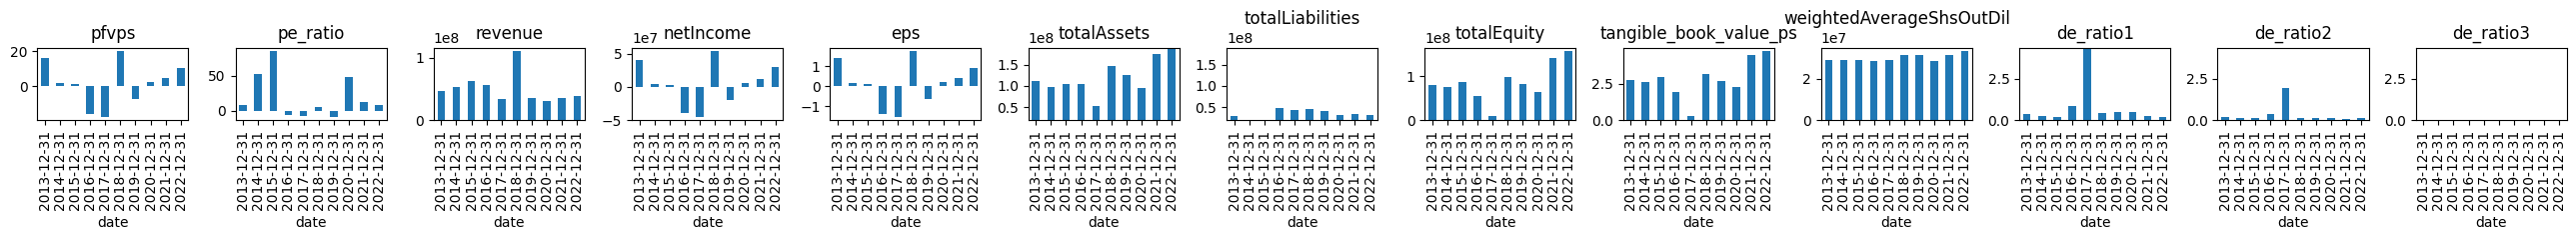

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1432/1495 [2:04:34<11:49, 11.27s/it]

less than 5 reports


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1433/1495 [2:04:36<08:53,  8.61s/it]

length equals zero
less than 5 reports


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1434/1495 [2:04:39<06:54,  6.80s/it]

negative growth


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1435/1495 [2:04:41<05:28,  5.47s/it]

overvalued. price: 4.0375, pfvps: -0.42323061866773426


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1436/1495 [2:04:52<06:56,  7.06s/it]

overvalued. price: 32.9, pfvps: 2.7664370496175907


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1437/1495 [2:05:02<07:37,  7.89s/it]

length equals zero
less than 5 reports


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1438/1495 [2:05:04<05:56,  6.25s/it]

overvalued. price: 16.92, pfvps: -0.021829104590942536


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1439/1495 [2:05:14<06:50,  7.34s/it]

overvalued. price: 27.35, pfvps: 12.811056815527431


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1440/1495 [2:05:25<07:46,  8.48s/it]

overvalued. price: 26.66, pfvps: 4.426325738717224


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1441/1495 [2:05:35<08:00,  8.90s/it]

only negative pe in history


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1442/1495 [2:05:41<07:13,  8.18s/it]

CNC.	 Current price: 68.88.	 Faire price: 89.04304896471756


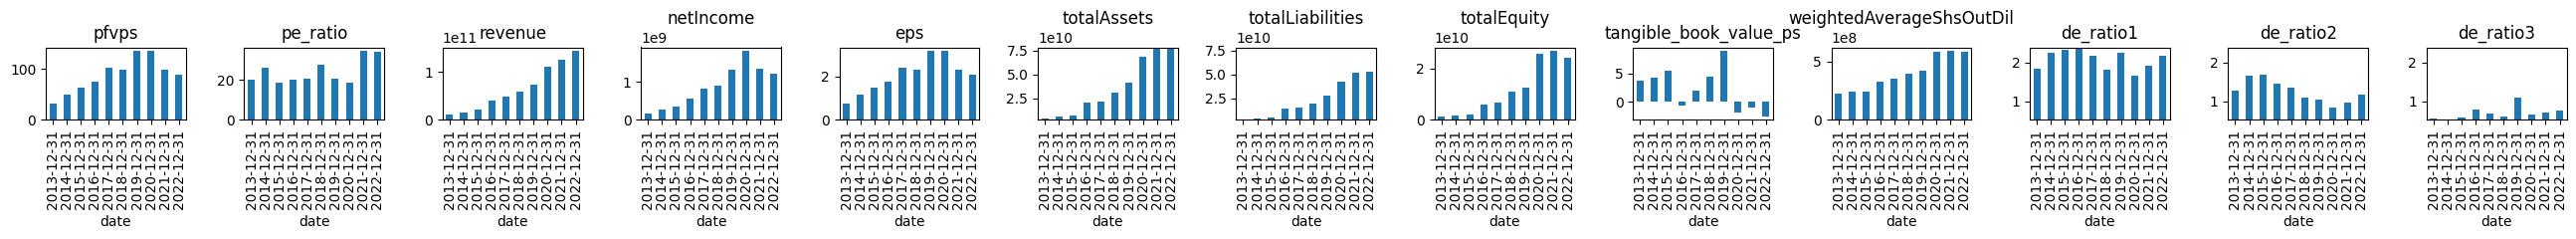

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1443/1495 [2:06:01<09:57, 11.49s/it]

length equals zero
less than 5 reports


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1444/1495 [2:06:03<07:26,  8.76s/it]

less than 5 reports


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1445/1495 [2:06:05<05:42,  6.85s/it]

length equals zero
less than 5 reports


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1446/1495 [2:06:08<04:35,  5.63s/it]

length equals zero
less than 5 reports


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1447/1495 [2:06:11<03:44,  4.67s/it]

overvalued. price: 1.6325, pfvps: -110.61534350708732


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1448/1495 [2:06:18<04:24,  5.62s/it]

negative growth


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1449/1495 [2:06:21<03:34,  4.66s/it]

length equals zero
less than 5 reports


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1450/1495 [2:06:23<02:59,  3.98s/it]

length equals zero
less than 5 reports


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1451/1495 [2:06:26<02:36,  3.56s/it]

only negative pe in history


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1452/1495 [2:06:35<03:45,  5.24s/it]

length equals zero
less than 5 reports


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1453/1495 [2:06:37<03:04,  4.40s/it]

length equals zero
less than 5 reports


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1454/1495 [2:06:40<02:36,  3.82s/it]

length equals zero
less than 5 reports


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1455/1495 [2:06:42<02:15,  3.40s/it]

length equals zero
less than 5 reports


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1456/1495 [2:06:45<02:02,  3.13s/it]

length equals zero
less than 5 reports


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1457/1495 [2:06:47<01:50,  2.91s/it]

length equals zero
less than 5 reports


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1458/1495 [2:06:50<01:42,  2.77s/it]

length equals zero
less than 5 reports


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1459/1495 [2:06:52<01:36,  2.67s/it]

negative growth


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1460/1495 [2:06:55<01:35,  2.72s/it]

length equals zero
less than 5 reports


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1461/1495 [2:06:58<01:34,  2.77s/it]

negative growth


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1462/1495 [2:07:00<01:27,  2.65s/it]

negative growth


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1463/1495 [2:07:03<01:22,  2.56s/it]

length equals zero
less than 5 reports


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1464/1495 [2:07:05<01:20,  2.60s/it]

only negative pe in history


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1465/1495 [2:07:14<02:17,  4.59s/it]

negative growth


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1466/1495 [2:07:17<01:53,  3.92s/it]

overvalued. price: 0.585, pfvps: -105.77592222865225


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1467/1495 [2:07:27<02:39,  5.71s/it]

only negative pe in history


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1468/1495 [2:07:33<02:40,  5.94s/it]

length equals zero
less than 5 reports


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1469/1495 [2:07:36<02:07,  4.89s/it]

length equals zero
less than 5 reports


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1470/1495 [2:07:38<01:43,  4.15s/it]

length equals zero
less than 5 reports


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1471/1495 [2:07:40<01:26,  3.62s/it]

length equals zero
less than 5 reports


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1472/1495 [2:07:43<01:18,  3.39s/it]

negative growth


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1473/1495 [2:07:46<01:11,  3.25s/it]

length equals zero
less than 5 reports


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1474/1495 [2:07:49<01:02,  3.00s/it]

only negative pe in history


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1475/1495 [2:07:56<01:29,  4.46s/it]

only negative pe in history


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1476/1495 [2:08:06<01:52,  5.90s/it]

length equals zero
less than 5 reports


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1477/1495 [2:08:08<01:27,  4.88s/it]

negative growth


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1478/1495 [2:08:11<01:10,  4.15s/it]

length equals zero
less than 5 reports


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1479/1495 [2:08:13<00:58,  3.64s/it]

length equals zero
less than 5 reports


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1480/1495 [2:08:16<00:51,  3.45s/it]

length equals zero
less than 5 reports


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1481/1495 [2:08:19<00:44,  3.16s/it]

length equals zero
less than 5 reports


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1482/1495 [2:08:21<00:38,  2.94s/it]

overvalued. price: 34.18, pfvps: 4.8789109354493


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1483/1495 [2:08:31<01:00,  5.05s/it]

length equals zero
less than 5 reports


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1484/1495 [2:08:34<00:47,  4.36s/it]

negative growth


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1485/1495 [2:08:37<00:39,  3.97s/it]

length equals zero
less than 5 reports


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1486/1495 [2:08:39<00:31,  3.52s/it]

length equals zero
less than 5 reports


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1487/1495 [2:08:42<00:25,  3.20s/it]

length equals zero
less than 5 reports


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1488/1495 [2:08:44<00:21,  3.07s/it]

negative growth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1489/1495 [2:08:47<00:17,  2.86s/it]

overvalued. price: 14.55, pfvps: 5.4788373447368945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1490/1495 [2:08:57<00:25,  5.09s/it]

less than 5 reports


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1491/1495 [2:09:00<00:17,  4.28s/it]

negative growth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1492/1495 [2:09:02<00:11,  3.73s/it]

overvalued. price: 9.86, pfvps: 9.325142371058286


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1493/1495 [2:09:12<00:11,  5.60s/it]

length equals zero
less than 5 reports


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1494/1495 [2:09:15<00:04,  4.83s/it]

length equals zero
less than 5 reports


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [2:09:18<00:00,  5.19s/it]


In [33]:
missing_tickers = []
overvalued_tickers = []
for ticker in tqdm(TICKERS[616:]):
    data_income_stmt = get_income_stmt_info(ticker=ticker, nb_years=10)
    data_balance_sheet = get_balance_sheet_info(ticker=ticker, nb_years=10)
    #print("after bs & is")
    #print(len(data_income_stmt), len(data_balance_sheet))
    if len(data_balance_sheet) == 0 or len(data_income_stmt) == 0:
        print("length equals zero")
        missing_tickers.append(ticker)
        
    if len(data_balance_sheet) < 5 or len(data_income_stmt) < 5:
        print("less than 5 reports")
        time.sleep(1)
        continue
    #print("after check of length of bs & is")
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]
    balance_sheet_df = balance_sheet_df.rename(columns={"fillingDate":"fillingDateBalanceSheet"})
    
    # get equity & compute growth
    all_equity = get_key_from_iterator(iterator=data_balance_sheet, key="totalStockholdersEquity")
    growths = []
    #print(all_equity)
    for nb_years in range(5, len(all_equity)+1):#6, 7, 8, 9]:
        single_growth = compute_growth(all_equity[0], all_equity[nb_years-1], nb_years-1)
        #print(nb_years, single_growth)
        #single_growth = (all_equity[0] / (all_equity[nb_years-1] + 0.001)) ** (1/(nb_years-1)) - 1
        growths.append(single_growth)
    growth_value = np.median(growths)
    #print(growths)
    if growth_value < 0: # not focusing on companies having historical negative growth_rate
        print("negative growth")
        time.sleep(1)
        continue
    # compute future pe ratio
    all_prices = []
    for single_income_stmt in data_income_stmt:
        reporting_start, reporting_end, filling_date_flag = get_reporting_window(single_income_stmt)
        data_prices = get_prices_in_range(ticker, reporting_start, reporting_end)
        try:
            range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
            avg_price_at_report = compute_avg_value(range_price_lows)
        except:
            avg_price_at_report = 0
        all_prices.append(avg_price_at_report)
        
    all_eps = get_key_from_iterator(iterator=data_income_stmt, key="eps")
    all_eps = [val if val != 0 else 1e-6 for val in all_eps]
    historical_pe = list(np.array(all_prices) / np.array(all_eps))
    historical_pe = handling_negative_vals(historical_pe)
    future_pe = compute_avg_value(historical_pe)
    
    if future_pe <= 0:
        print("only negative pe in history")
        time.sleep(1)
        continue
    # compute present faire value
    #print(growth_value, return_value, future_pe, years)
    pfvps = compute_pex_value(data_income_stmt[0], growth_value, return_value, future_pe, years)
    
    # get current price
    current_price = get_current_price(ticker)
    
    # filter out companies with price > fpv
    if current_price is None or current_price > pfvps:
        print(f"overvalued. price: {current_price}, pfvps: {pfvps}")
        overvalued_tickers.append(ticker)
        time.sleep(1)
        continue
    # compute stuff to plot
    try:
        fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    except:
        print("dates incoherence")
        continue
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    # compute PFV
    fs_df["pfvps"] = fs_df.apply(compute_pex_value, args=(growth_value, return_value, future_pe, years,), axis=1)
    # compute tangible book value per share
    fs_df["tangible_book_value_ps"] = fs_df.apply(compute_tangible_book_value_ps, axis=1)
    # compute discounted tangible book value per share
    #fs_df["dct_tangible_book_value_ps"] = fs_df.apply(compute_discounted_tangible_book_value_ps, args=(current_assets_factors, ), axis=1)
    # compute current ratio
    #fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # get price at report date
    fs_df["reporting_date_price"] = None
    windows = fs_df.reset_index().apply(get_reporting_window, axis=1)
    window_df = pd.DataFrame(windows, columns=["iter"])
    del windows
    window_df = pd.DataFrame(
        window_df.iter.tolist(),
        columns=["report_start", "report_end", "filling_date_bool"],
        index=fs_df.index,
    )
    window_df["prices"] = None
    for idx, row in window_df.iterrows():
        window_df.at[idx, "prices"] = get_prices_in_range(
            ticker, window_df.loc[idx, "report_start"], window_df.loc[idx, "report_end"],
        )
    window_df["prices"] = window_df["prices"].apply(get_price_history)
    fs_df["reporting_date_price"] = None
    for idx, row in window_df.iterrows():
        fs_df.at[idx, "reporting_date_price"] = compute_price_at_reporting_date(
            window_df.loc[idx, "prices"], window_df.loc[idx, "filling_date_bool"], "low",
        )
    del window_df
    #pd.Series(fs_df.reset_index().apply(compute_price_at_reporting_date, args=(filling_date_flag, "low"), axis=1), index=fs_df.index) # <- REVIEW THIS LINE
    # compute pe ratio
    fs_df["pe_ratio"] = fs_df.apply(compute_pe_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio, args=("totalLiabilities",), axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio, args=("totalCurrentLiabilities",), axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio, args=("totalDebt",), axis=1)
    #print(fs_df)
    # plot indicators
    print(f"{ticker}.\t Current price: {current_price}.\t Faire price: {pfvps}")
    plot_indicators(fs_df)

    time.sleep(1)